In [5]:
#CGAN代码实现及其Loss输出
from __future__ import print_function, division
from tensorflow import keras

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf #使用1.0版本的方法
tf.disable_v2_behavior() #禁用2.0版本的方法

class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)
    
    def load_data(self):
        fashion_mnist = keras.datasets.fashion_mnist
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#         path='D://机器学习//dataset//mnist.npz'
#         f = np.load(path)
#         x_train, y_train = f['x_train'], f['y_train']
#         x_test, y_test = f['x_test'], f['y_test']
#         f.close()
        return (x_train, y_train), (x_test, y_test)
    
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        fig_loss_gen = np.zeros([epochs])
        fig_loss_dis = np.zeros([epochs])
        fig_accuracy = np.zeros([epochs])
        
        # Load the dataset
        (X_train, y_train), (_, _) = self.load_data()
        X_train=X_train[0:len(X_train)]
        y_train=y_train[0:len(y_train)]
        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            fig_loss_dis[epoch]=d_loss[0]
            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)
            fig_loss_gen[epoch] = g_loss
            fig_accuracy[epoch] = 100*d_loss[1]
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
        return fig_loss_gen,fig_loss_dis,fig_accuracy

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    cgan = CGAN()
    fig_loss_gen,fig_loss_dis,fig_accuracy=cgan.train(epochs=20000, batch_size=32, sample_interval=200)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 512)              

C:\Users\15147\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.696773, acc.: 20.31%] [G loss: 0.683703]


C:\Users\15147\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.686376, acc.: 50.00%] [G loss: 0.674144]
2 [D loss: 0.680067, acc.: 50.00%] [G loss: 0.668879]
3 [D loss: 0.675731, acc.: 50.00%] [G loss: 0.658625]
4 [D loss: 0.666219, acc.: 50.00%] [G loss: 0.651769]
5 [D loss: 0.660395, acc.: 50.00%] [G loss: 0.639892]
6 [D loss: 0.647409, acc.: 50.00%] [G loss: 0.630422]
7 [D loss: 0.633948, acc.: 50.00%] [G loss: 0.621674]
8 [D loss: 0.610909, acc.: 50.00%] [G loss: 0.611458]
9 [D loss: 0.603310, acc.: 50.00%] [G loss: 0.595402]
10 [D loss: 0.566914, acc.: 50.00%] [G loss: 0.578090]
11 [D loss: 0.535400, acc.: 62.50%] [G loss: 0.561125]
12 [D loss: 0.487140, acc.: 90.62%] [G loss: 0.546947]
13 [D loss: 0.458055, acc.: 92.19%] [G loss: 0.531556]
14 [D loss: 0.403382, acc.: 96.88%] [G loss: 0.505640]
15 [D loss: 0.394337, acc.: 96.88%] [G loss: 0.484465]
16 [D loss: 0.360079, acc.: 100.00%] [G loss: 0.492839]
17 [D loss: 0.315993, acc.: 100.00%] [G loss: 0.517123]
18 [D loss: 0.274338, acc.: 100.00%] [G loss: 0.462582]
19 [D loss: 0.25

150 [D loss: 0.191906, acc.: 93.75%] [G loss: 4.985322]
151 [D loss: 0.160382, acc.: 92.19%] [G loss: 5.218001]
152 [D loss: 0.113548, acc.: 95.31%] [G loss: 5.940974]
153 [D loss: 0.308248, acc.: 89.06%] [G loss: 5.266792]
154 [D loss: 0.198005, acc.: 93.75%] [G loss: 5.189591]
155 [D loss: 0.127789, acc.: 95.31%] [G loss: 5.866431]
156 [D loss: 0.336305, acc.: 81.25%] [G loss: 5.521526]
157 [D loss: 0.153374, acc.: 93.75%] [G loss: 5.976631]
158 [D loss: 0.383643, acc.: 79.69%] [G loss: 5.106785]
159 [D loss: 0.357002, acc.: 92.19%] [G loss: 6.192510]
160 [D loss: 0.161241, acc.: 93.75%] [G loss: 5.837797]
161 [D loss: 0.379085, acc.: 84.38%] [G loss: 4.767310]
162 [D loss: 0.307436, acc.: 89.06%] [G loss: 5.399179]
163 [D loss: 0.206916, acc.: 95.31%] [G loss: 5.736915]
164 [D loss: 0.569714, acc.: 79.69%] [G loss: 5.074973]
165 [D loss: 0.190508, acc.: 93.75%] [G loss: 5.420278]
166 [D loss: 0.255931, acc.: 85.94%] [G loss: 5.136221]
167 [D loss: 0.102428, acc.: 98.44%] [G loss: 5.

299 [D loss: 0.414572, acc.: 85.94%] [G loss: 2.292696]
300 [D loss: 0.340472, acc.: 82.81%] [G loss: 2.356044]
301 [D loss: 0.535284, acc.: 70.31%] [G loss: 2.414789]
302 [D loss: 0.458053, acc.: 76.56%] [G loss: 2.598065]
303 [D loss: 0.511513, acc.: 70.31%] [G loss: 2.703219]
304 [D loss: 0.484708, acc.: 76.56%] [G loss: 2.509195]
305 [D loss: 0.392774, acc.: 84.38%] [G loss: 2.614419]
306 [D loss: 0.284626, acc.: 90.62%] [G loss: 2.218068]
307 [D loss: 0.498098, acc.: 78.12%] [G loss: 1.795159]
308 [D loss: 0.503351, acc.: 79.69%] [G loss: 2.175935]
309 [D loss: 0.362695, acc.: 82.81%] [G loss: 2.183902]
310 [D loss: 0.487013, acc.: 79.69%] [G loss: 2.546075]
311 [D loss: 0.444498, acc.: 81.25%] [G loss: 2.290550]
312 [D loss: 0.417734, acc.: 79.69%] [G loss: 2.194916]
313 [D loss: 0.343978, acc.: 84.38%] [G loss: 2.188662]
314 [D loss: 0.335505, acc.: 87.50%] [G loss: 2.177494]
315 [D loss: 0.440713, acc.: 76.56%] [G loss: 2.075156]
316 [D loss: 0.457143, acc.: 79.69%] [G loss: 2.

446 [D loss: 0.435786, acc.: 82.81%] [G loss: 1.758760]
447 [D loss: 0.527786, acc.: 71.88%] [G loss: 1.825282]
448 [D loss: 0.484148, acc.: 75.00%] [G loss: 1.845052]
449 [D loss: 0.595655, acc.: 71.88%] [G loss: 1.545527]
450 [D loss: 0.543957, acc.: 68.75%] [G loss: 1.557569]
451 [D loss: 0.479562, acc.: 79.69%] [G loss: 1.408771]
452 [D loss: 0.687727, acc.: 60.94%] [G loss: 1.823275]
453 [D loss: 0.426556, acc.: 75.00%] [G loss: 1.908387]
454 [D loss: 0.531627, acc.: 78.12%] [G loss: 1.692972]
455 [D loss: 0.626444, acc.: 71.88%] [G loss: 1.738005]
456 [D loss: 0.545658, acc.: 73.44%] [G loss: 1.814856]
457 [D loss: 0.430969, acc.: 81.25%] [G loss: 1.684527]
458 [D loss: 0.435314, acc.: 81.25%] [G loss: 1.856234]
459 [D loss: 0.561644, acc.: 75.00%] [G loss: 1.821243]
460 [D loss: 0.535687, acc.: 75.00%] [G loss: 1.445806]
461 [D loss: 0.555356, acc.: 73.44%] [G loss: 1.884279]
462 [D loss: 0.528464, acc.: 73.44%] [G loss: 2.137305]
463 [D loss: 0.603531, acc.: 68.75%] [G loss: 1.

595 [D loss: 0.575444, acc.: 67.19%] [G loss: 1.583301]
596 [D loss: 0.499689, acc.: 76.56%] [G loss: 1.411105]
597 [D loss: 0.550967, acc.: 67.19%] [G loss: 1.649183]
598 [D loss: 0.637152, acc.: 59.38%] [G loss: 1.572528]
599 [D loss: 0.483392, acc.: 76.56%] [G loss: 1.534735]
600 [D loss: 0.651110, acc.: 65.62%] [G loss: 1.666235]
601 [D loss: 0.605142, acc.: 68.75%] [G loss: 1.536944]
602 [D loss: 0.464284, acc.: 75.00%] [G loss: 1.329258]
603 [D loss: 0.494260, acc.: 76.56%] [G loss: 1.681492]
604 [D loss: 0.683239, acc.: 59.38%] [G loss: 1.467132]
605 [D loss: 0.568270, acc.: 67.19%] [G loss: 1.276228]
606 [D loss: 0.601771, acc.: 65.62%] [G loss: 1.539739]
607 [D loss: 0.460825, acc.: 82.81%] [G loss: 1.574397]
608 [D loss: 0.575318, acc.: 70.31%] [G loss: 1.430409]
609 [D loss: 0.504613, acc.: 81.25%] [G loss: 1.308437]
610 [D loss: 0.649928, acc.: 67.19%] [G loss: 1.311056]
611 [D loss: 0.495260, acc.: 81.25%] [G loss: 1.410795]
612 [D loss: 0.563782, acc.: 64.06%] [G loss: 1.

745 [D loss: 0.604328, acc.: 67.19%] [G loss: 1.307168]
746 [D loss: 0.541464, acc.: 71.88%] [G loss: 1.223101]
747 [D loss: 0.555048, acc.: 60.94%] [G loss: 1.264414]
748 [D loss: 0.575081, acc.: 73.44%] [G loss: 1.397943]
749 [D loss: 0.565958, acc.: 68.75%] [G loss: 1.230348]
750 [D loss: 0.631260, acc.: 65.62%] [G loss: 1.216113]
751 [D loss: 0.623770, acc.: 62.50%] [G loss: 1.235998]
752 [D loss: 0.569066, acc.: 71.88%] [G loss: 1.279748]
753 [D loss: 0.576015, acc.: 70.31%] [G loss: 1.174760]
754 [D loss: 0.635687, acc.: 65.62%] [G loss: 1.264593]
755 [D loss: 0.582025, acc.: 71.88%] [G loss: 1.275473]
756 [D loss: 0.494772, acc.: 76.56%] [G loss: 1.207404]
757 [D loss: 0.598215, acc.: 62.50%] [G loss: 1.323572]
758 [D loss: 0.613360, acc.: 62.50%] [G loss: 1.262362]
759 [D loss: 0.514500, acc.: 75.00%] [G loss: 1.396908]
760 [D loss: 0.618349, acc.: 60.94%] [G loss: 1.236209]
761 [D loss: 0.643544, acc.: 62.50%] [G loss: 1.353481]
762 [D loss: 0.587598, acc.: 68.75%] [G loss: 1.

894 [D loss: 0.638338, acc.: 70.31%] [G loss: 1.032221]
895 [D loss: 0.634109, acc.: 62.50%] [G loss: 1.113297]
896 [D loss: 0.648790, acc.: 64.06%] [G loss: 0.985750]
897 [D loss: 0.640907, acc.: 62.50%] [G loss: 0.955692]
898 [D loss: 0.658110, acc.: 57.81%] [G loss: 0.973860]
899 [D loss: 0.537868, acc.: 75.00%] [G loss: 1.033911]
900 [D loss: 0.633856, acc.: 70.31%] [G loss: 1.251797]
901 [D loss: 0.671829, acc.: 62.50%] [G loss: 1.082241]
902 [D loss: 0.650952, acc.: 65.62%] [G loss: 0.962864]
903 [D loss: 0.655950, acc.: 50.00%] [G loss: 0.977889]
904 [D loss: 0.673219, acc.: 50.00%] [G loss: 1.114066]
905 [D loss: 0.624326, acc.: 73.44%] [G loss: 1.093968]
906 [D loss: 0.564118, acc.: 62.50%] [G loss: 0.958380]
907 [D loss: 0.663280, acc.: 62.50%] [G loss: 1.001752]
908 [D loss: 0.596852, acc.: 64.06%] [G loss: 1.060059]
909 [D loss: 0.647737, acc.: 56.25%] [G loss: 1.126306]
910 [D loss: 0.644567, acc.: 62.50%] [G loss: 0.965969]
911 [D loss: 0.725568, acc.: 46.88%] [G loss: 1.

1041 [D loss: 0.668573, acc.: 51.56%] [G loss: 0.926885]
1042 [D loss: 0.695295, acc.: 60.94%] [G loss: 0.915631]
1043 [D loss: 0.640413, acc.: 60.94%] [G loss: 0.952470]
1044 [D loss: 0.675117, acc.: 53.12%] [G loss: 1.022941]
1045 [D loss: 0.655858, acc.: 60.94%] [G loss: 0.928985]
1046 [D loss: 0.652621, acc.: 57.81%] [G loss: 0.920920]
1047 [D loss: 0.636606, acc.: 71.88%] [G loss: 0.909574]
1048 [D loss: 0.676161, acc.: 59.38%] [G loss: 0.886574]
1049 [D loss: 0.647392, acc.: 67.19%] [G loss: 0.918463]
1050 [D loss: 0.709294, acc.: 54.69%] [G loss: 0.993638]
1051 [D loss: 0.630196, acc.: 64.06%] [G loss: 0.927008]
1052 [D loss: 0.592153, acc.: 68.75%] [G loss: 0.893769]
1053 [D loss: 0.668700, acc.: 56.25%] [G loss: 0.885741]
1054 [D loss: 0.690110, acc.: 53.12%] [G loss: 0.849883]
1055 [D loss: 0.629197, acc.: 62.50%] [G loss: 0.942551]
1056 [D loss: 0.687181, acc.: 48.44%] [G loss: 0.935437]
1057 [D loss: 0.636985, acc.: 59.38%] [G loss: 0.874771]
1058 [D loss: 0.640788, acc.: 6

1186 [D loss: 0.648809, acc.: 60.94%] [G loss: 0.859011]
1187 [D loss: 0.666253, acc.: 62.50%] [G loss: 0.869318]
1188 [D loss: 0.664162, acc.: 60.94%] [G loss: 0.830675]
1189 [D loss: 0.652694, acc.: 56.25%] [G loss: 0.855338]
1190 [D loss: 0.630010, acc.: 62.50%] [G loss: 0.816967]
1191 [D loss: 0.644959, acc.: 62.50%] [G loss: 0.885038]
1192 [D loss: 0.632793, acc.: 53.12%] [G loss: 0.878884]
1193 [D loss: 0.644384, acc.: 64.06%] [G loss: 0.926921]
1194 [D loss: 0.681199, acc.: 56.25%] [G loss: 0.874426]
1195 [D loss: 0.656769, acc.: 56.25%] [G loss: 0.850472]
1196 [D loss: 0.697163, acc.: 50.00%] [G loss: 0.826270]
1197 [D loss: 0.656387, acc.: 60.94%] [G loss: 0.881069]
1198 [D loss: 0.690243, acc.: 57.81%] [G loss: 0.905358]
1199 [D loss: 0.645157, acc.: 65.62%] [G loss: 0.862186]
1200 [D loss: 0.708793, acc.: 43.75%] [G loss: 0.911501]
1201 [D loss: 0.671183, acc.: 56.25%] [G loss: 0.913085]
1202 [D loss: 0.669299, acc.: 59.38%] [G loss: 0.867189]
1203 [D loss: 0.627435, acc.: 7

1333 [D loss: 0.700644, acc.: 53.12%] [G loss: 0.921986]
1334 [D loss: 0.614992, acc.: 65.62%] [G loss: 0.947235]
1335 [D loss: 0.662665, acc.: 57.81%] [G loss: 0.878484]
1336 [D loss: 0.665372, acc.: 57.81%] [G loss: 0.791073]
1337 [D loss: 0.689755, acc.: 60.94%] [G loss: 0.828424]
1338 [D loss: 0.627701, acc.: 71.88%] [G loss: 0.898615]
1339 [D loss: 0.715478, acc.: 57.81%] [G loss: 0.868297]
1340 [D loss: 0.674968, acc.: 50.00%] [G loss: 1.092792]
1341 [D loss: 0.693323, acc.: 62.50%] [G loss: 0.876035]
1342 [D loss: 0.688182, acc.: 53.12%] [G loss: 0.875349]
1343 [D loss: 0.663719, acc.: 60.94%] [G loss: 0.878372]
1344 [D loss: 0.679878, acc.: 56.25%] [G loss: 0.846092]
1345 [D loss: 0.648113, acc.: 62.50%] [G loss: 0.824158]
1346 [D loss: 0.644895, acc.: 60.94%] [G loss: 0.796552]
1347 [D loss: 0.647510, acc.: 62.50%] [G loss: 0.779423]
1348 [D loss: 0.636252, acc.: 68.75%] [G loss: 0.880766]
1349 [D loss: 0.669559, acc.: 59.38%] [G loss: 0.831938]
1350 [D loss: 0.654789, acc.: 5

1622 [D loss: 0.745339, acc.: 35.94%] [G loss: 0.805874]
1623 [D loss: 0.685137, acc.: 56.25%] [G loss: 0.777673]
1624 [D loss: 0.687602, acc.: 62.50%] [G loss: 0.794709]
1625 [D loss: 0.713909, acc.: 48.44%] [G loss: 0.758162]
1626 [D loss: 0.668541, acc.: 53.12%] [G loss: 0.797539]
1627 [D loss: 0.670449, acc.: 54.69%] [G loss: 0.753518]
1628 [D loss: 0.671642, acc.: 56.25%] [G loss: 0.791675]
1629 [D loss: 0.672087, acc.: 59.38%] [G loss: 0.780550]
1630 [D loss: 0.690863, acc.: 59.38%] [G loss: 0.806242]
1631 [D loss: 0.652713, acc.: 54.69%] [G loss: 0.805330]
1632 [D loss: 0.696374, acc.: 43.75%] [G loss: 0.847652]
1633 [D loss: 0.711460, acc.: 51.56%] [G loss: 0.815258]
1634 [D loss: 0.672525, acc.: 54.69%] [G loss: 0.829265]
1635 [D loss: 0.686403, acc.: 62.50%] [G loss: 0.765379]
1636 [D loss: 0.673473, acc.: 54.69%] [G loss: 0.777647]
1637 [D loss: 0.674848, acc.: 56.25%] [G loss: 0.897907]
1638 [D loss: 0.683260, acc.: 59.38%] [G loss: 0.849453]
1639 [D loss: 0.711156, acc.: 4

1766 [D loss: 0.687712, acc.: 48.44%] [G loss: 0.791378]
1767 [D loss: 0.673994, acc.: 54.69%] [G loss: 0.886936]
1768 [D loss: 0.672655, acc.: 65.62%] [G loss: 0.801283]
1769 [D loss: 0.684842, acc.: 50.00%] [G loss: 0.817967]
1770 [D loss: 0.716093, acc.: 51.56%] [G loss: 0.853796]
1771 [D loss: 0.687959, acc.: 53.12%] [G loss: 0.782086]
1772 [D loss: 0.677703, acc.: 53.12%] [G loss: 0.766405]
1773 [D loss: 0.662955, acc.: 59.38%] [G loss: 0.767346]
1774 [D loss: 0.667235, acc.: 54.69%] [G loss: 0.744617]
1775 [D loss: 0.660654, acc.: 64.06%] [G loss: 0.749449]
1776 [D loss: 0.692259, acc.: 56.25%] [G loss: 0.796845]
1777 [D loss: 0.688389, acc.: 53.12%] [G loss: 0.799983]
1778 [D loss: 0.710192, acc.: 54.69%] [G loss: 0.797840]
1779 [D loss: 0.708439, acc.: 51.56%] [G loss: 0.825221]
1780 [D loss: 0.691812, acc.: 46.88%] [G loss: 0.832029]
1781 [D loss: 0.661070, acc.: 56.25%] [G loss: 0.847118]
1782 [D loss: 0.652524, acc.: 68.75%] [G loss: 0.803823]
1783 [D loss: 0.645847, acc.: 5

1913 [D loss: 0.664291, acc.: 62.50%] [G loss: 0.803077]
1914 [D loss: 0.672221, acc.: 57.81%] [G loss: 0.761024]
1915 [D loss: 0.668891, acc.: 56.25%] [G loss: 0.824417]
1916 [D loss: 0.694103, acc.: 57.81%] [G loss: 0.800875]
1917 [D loss: 0.682780, acc.: 65.62%] [G loss: 0.794315]
1918 [D loss: 0.645949, acc.: 73.44%] [G loss: 0.802817]
1919 [D loss: 0.646841, acc.: 67.19%] [G loss: 0.861722]
1920 [D loss: 0.709792, acc.: 46.88%] [G loss: 0.784083]
1921 [D loss: 0.646891, acc.: 56.25%] [G loss: 0.794242]
1922 [D loss: 0.670684, acc.: 53.12%] [G loss: 0.842129]
1923 [D loss: 0.691312, acc.: 51.56%] [G loss: 0.787507]
1924 [D loss: 0.691950, acc.: 46.88%] [G loss: 0.807102]
1925 [D loss: 0.661957, acc.: 56.25%] [G loss: 0.807889]
1926 [D loss: 0.624616, acc.: 67.19%] [G loss: 0.840467]
1927 [D loss: 0.675547, acc.: 50.00%] [G loss: 0.788043]
1928 [D loss: 0.703894, acc.: 43.75%] [G loss: 0.791059]
1929 [D loss: 0.670280, acc.: 50.00%] [G loss: 0.838701]
1930 [D loss: 0.717385, acc.: 4

2058 [D loss: 0.700734, acc.: 56.25%] [G loss: 0.832480]
2059 [D loss: 0.676946, acc.: 54.69%] [G loss: 0.837811]
2060 [D loss: 0.671985, acc.: 54.69%] [G loss: 0.885800]
2061 [D loss: 0.667627, acc.: 51.56%] [G loss: 0.846680]
2062 [D loss: 0.693436, acc.: 54.69%] [G loss: 0.767936]
2063 [D loss: 0.645955, acc.: 65.62%] [G loss: 0.751225]
2064 [D loss: 0.680923, acc.: 54.69%] [G loss: 0.784612]
2065 [D loss: 0.684836, acc.: 57.81%] [G loss: 0.833149]
2066 [D loss: 0.670456, acc.: 54.69%] [G loss: 0.808476]
2067 [D loss: 0.670715, acc.: 51.56%] [G loss: 0.790915]
2068 [D loss: 0.680106, acc.: 62.50%] [G loss: 0.795162]
2069 [D loss: 0.694520, acc.: 45.31%] [G loss: 0.831472]
2070 [D loss: 0.646117, acc.: 67.19%] [G loss: 0.842618]
2071 [D loss: 0.684353, acc.: 46.88%] [G loss: 0.803713]
2072 [D loss: 0.658350, acc.: 59.38%] [G loss: 0.800233]
2073 [D loss: 0.683493, acc.: 48.44%] [G loss: 0.831589]
2074 [D loss: 0.674573, acc.: 53.12%] [G loss: 0.775174]
2075 [D loss: 0.654490, acc.: 6

2206 [D loss: 0.651548, acc.: 60.94%] [G loss: 0.837194]
2207 [D loss: 0.686006, acc.: 56.25%] [G loss: 0.826190]
2208 [D loss: 0.660223, acc.: 54.69%] [G loss: 0.831718]
2209 [D loss: 0.718630, acc.: 48.44%] [G loss: 0.863669]
2210 [D loss: 0.669443, acc.: 56.25%] [G loss: 0.860355]
2211 [D loss: 0.680654, acc.: 51.56%] [G loss: 0.806413]
2212 [D loss: 0.655772, acc.: 51.56%] [G loss: 0.822975]
2213 [D loss: 0.660202, acc.: 59.38%] [G loss: 0.825081]
2214 [D loss: 0.675560, acc.: 54.69%] [G loss: 0.829487]
2215 [D loss: 0.681909, acc.: 51.56%] [G loss: 0.839342]
2216 [D loss: 0.678853, acc.: 54.69%] [G loss: 0.799983]
2217 [D loss: 0.694077, acc.: 50.00%] [G loss: 0.812199]
2218 [D loss: 0.669931, acc.: 53.12%] [G loss: 0.852590]
2219 [D loss: 0.683614, acc.: 51.56%] [G loss: 0.876630]
2220 [D loss: 0.668966, acc.: 57.81%] [G loss: 0.818174]
2221 [D loss: 0.668219, acc.: 56.25%] [G loss: 0.809532]
2222 [D loss: 0.667865, acc.: 60.94%] [G loss: 0.837796]
2223 [D loss: 0.658014, acc.: 6

2496 [D loss: 0.654183, acc.: 57.81%] [G loss: 0.817774]
2497 [D loss: 0.697084, acc.: 59.38%] [G loss: 0.820119]
2498 [D loss: 0.718845, acc.: 43.75%] [G loss: 0.829380]
2499 [D loss: 0.685046, acc.: 51.56%] [G loss: 0.820223]
2500 [D loss: 0.682289, acc.: 53.12%] [G loss: 0.777275]
2501 [D loss: 0.690240, acc.: 54.69%] [G loss: 0.760371]
2502 [D loss: 0.666213, acc.: 57.81%] [G loss: 0.789495]
2503 [D loss: 0.673906, acc.: 57.81%] [G loss: 0.772195]
2504 [D loss: 0.684808, acc.: 60.94%] [G loss: 0.815237]
2505 [D loss: 0.665344, acc.: 60.94%] [G loss: 0.765402]
2506 [D loss: 0.664673, acc.: 59.38%] [G loss: 0.799588]
2507 [D loss: 0.679425, acc.: 50.00%] [G loss: 0.760782]
2508 [D loss: 0.702404, acc.: 54.69%] [G loss: 0.773339]
2509 [D loss: 0.685140, acc.: 60.94%] [G loss: 0.733270]
2510 [D loss: 0.686586, acc.: 51.56%] [G loss: 0.809362]
2511 [D loss: 0.685979, acc.: 51.56%] [G loss: 0.755981]
2512 [D loss: 0.676933, acc.: 62.50%] [G loss: 0.745300]
2513 [D loss: 0.656152, acc.: 5

2641 [D loss: 0.685197, acc.: 48.44%] [G loss: 0.787627]
2642 [D loss: 0.687120, acc.: 60.94%] [G loss: 0.813904]
2643 [D loss: 0.664585, acc.: 53.12%] [G loss: 0.774835]
2644 [D loss: 0.671593, acc.: 60.94%] [G loss: 0.824542]
2645 [D loss: 0.680975, acc.: 53.12%] [G loss: 0.794719]
2646 [D loss: 0.681517, acc.: 60.94%] [G loss: 0.780831]
2647 [D loss: 0.754798, acc.: 54.69%] [G loss: 0.786653]
2648 [D loss: 0.642639, acc.: 62.50%] [G loss: 0.809855]
2649 [D loss: 0.692355, acc.: 57.81%] [G loss: 0.801073]
2650 [D loss: 0.721244, acc.: 48.44%] [G loss: 0.773508]
2651 [D loss: 0.674683, acc.: 64.06%] [G loss: 0.745287]
2652 [D loss: 0.699621, acc.: 50.00%] [G loss: 0.750601]
2653 [D loss: 0.675019, acc.: 56.25%] [G loss: 0.767875]
2654 [D loss: 0.685339, acc.: 57.81%] [G loss: 0.758240]
2655 [D loss: 0.674073, acc.: 57.81%] [G loss: 0.776925]
2656 [D loss: 0.702556, acc.: 53.12%] [G loss: 0.789917]
2657 [D loss: 0.667210, acc.: 57.81%] [G loss: 0.780396]
2658 [D loss: 0.685842, acc.: 6

2786 [D loss: 0.701334, acc.: 56.25%] [G loss: 0.768482]
2787 [D loss: 0.682142, acc.: 53.12%] [G loss: 0.761244]
2788 [D loss: 0.695767, acc.: 51.56%] [G loss: 0.806939]
2789 [D loss: 0.642614, acc.: 65.62%] [G loss: 0.886015]
2790 [D loss: 0.683912, acc.: 62.50%] [G loss: 0.736693]
2791 [D loss: 0.673976, acc.: 59.38%] [G loss: 0.772035]
2792 [D loss: 0.675650, acc.: 60.94%] [G loss: 0.756875]
2793 [D loss: 0.668384, acc.: 57.81%] [G loss: 0.762027]
2794 [D loss: 0.668265, acc.: 62.50%] [G loss: 0.793962]
2795 [D loss: 0.680370, acc.: 54.69%] [G loss: 0.774414]
2796 [D loss: 0.659498, acc.: 53.12%] [G loss: 0.827309]
2797 [D loss: 0.642416, acc.: 64.06%] [G loss: 0.811322]
2798 [D loss: 0.687432, acc.: 51.56%] [G loss: 0.738522]
2799 [D loss: 0.684603, acc.: 57.81%] [G loss: 0.803118]
2800 [D loss: 0.716194, acc.: 54.69%] [G loss: 0.756418]
2801 [D loss: 0.676312, acc.: 51.56%] [G loss: 0.821510]
2802 [D loss: 0.654558, acc.: 62.50%] [G loss: 0.845582]
2803 [D loss: 0.640833, acc.: 6

3074 [D loss: 0.685443, acc.: 46.88%] [G loss: 0.827714]
3075 [D loss: 0.694315, acc.: 53.12%] [G loss: 0.791477]
3076 [D loss: 0.680020, acc.: 50.00%] [G loss: 0.731388]
3077 [D loss: 0.710012, acc.: 51.56%] [G loss: 0.730193]
3078 [D loss: 0.661860, acc.: 56.25%] [G loss: 0.820849]
3079 [D loss: 0.670766, acc.: 54.69%] [G loss: 0.800557]
3080 [D loss: 0.650681, acc.: 59.38%] [G loss: 0.763581]
3081 [D loss: 0.682741, acc.: 51.56%] [G loss: 0.791001]
3082 [D loss: 0.709714, acc.: 46.88%] [G loss: 0.818367]
3083 [D loss: 0.690655, acc.: 43.75%] [G loss: 0.797834]
3084 [D loss: 0.685217, acc.: 56.25%] [G loss: 0.810461]
3085 [D loss: 0.683133, acc.: 48.44%] [G loss: 0.723376]
3086 [D loss: 0.680171, acc.: 50.00%] [G loss: 0.746153]
3087 [D loss: 0.689034, acc.: 54.69%] [G loss: 0.739314]
3088 [D loss: 0.665542, acc.: 51.56%] [G loss: 0.741808]
3089 [D loss: 0.684517, acc.: 56.25%] [G loss: 0.758336]
3090 [D loss: 0.675444, acc.: 53.12%] [G loss: 0.788806]
3091 [D loss: 0.670423, acc.: 5

3221 [D loss: 0.680611, acc.: 57.81%] [G loss: 0.731213]
3222 [D loss: 0.694631, acc.: 51.56%] [G loss: 0.751970]
3223 [D loss: 0.707478, acc.: 51.56%] [G loss: 0.766097]
3224 [D loss: 0.672446, acc.: 54.69%] [G loss: 0.783448]
3225 [D loss: 0.709218, acc.: 46.88%] [G loss: 0.809456]
3226 [D loss: 0.746055, acc.: 51.56%] [G loss: 0.783761]
3227 [D loss: 0.649009, acc.: 68.75%] [G loss: 0.816620]
3228 [D loss: 0.677104, acc.: 64.06%] [G loss: 0.747762]
3229 [D loss: 0.680063, acc.: 56.25%] [G loss: 0.761843]
3230 [D loss: 0.672665, acc.: 59.38%] [G loss: 0.783442]
3231 [D loss: 0.688019, acc.: 54.69%] [G loss: 0.750088]
3232 [D loss: 0.689760, acc.: 56.25%] [G loss: 0.759286]
3233 [D loss: 0.691638, acc.: 54.69%] [G loss: 0.729963]
3234 [D loss: 0.731761, acc.: 42.19%] [G loss: 0.772999]
3235 [D loss: 0.689371, acc.: 57.81%] [G loss: 0.745145]
3236 [D loss: 0.651773, acc.: 65.62%] [G loss: 0.777836]
3237 [D loss: 0.680853, acc.: 54.69%] [G loss: 0.781903]
3238 [D loss: 0.679914, acc.: 5

3366 [D loss: 0.652769, acc.: 57.81%] [G loss: 0.816667]
3367 [D loss: 0.668641, acc.: 60.94%] [G loss: 0.802633]
3368 [D loss: 0.707326, acc.: 51.56%] [G loss: 0.817503]
3369 [D loss: 0.663737, acc.: 54.69%] [G loss: 0.838808]
3370 [D loss: 0.705111, acc.: 48.44%] [G loss: 0.779438]
3371 [D loss: 0.654320, acc.: 59.38%] [G loss: 0.743947]
3372 [D loss: 0.699084, acc.: 45.31%] [G loss: 0.763474]
3373 [D loss: 0.687883, acc.: 50.00%] [G loss: 0.794672]
3374 [D loss: 0.678414, acc.: 45.31%] [G loss: 0.775019]
3375 [D loss: 0.691119, acc.: 53.12%] [G loss: 0.802509]
3376 [D loss: 0.695764, acc.: 50.00%] [G loss: 0.749956]
3377 [D loss: 0.679939, acc.: 54.69%] [G loss: 0.778073]
3378 [D loss: 0.705854, acc.: 51.56%] [G loss: 0.760228]
3379 [D loss: 0.646169, acc.: 65.62%] [G loss: 0.763576]
3380 [D loss: 0.669504, acc.: 46.88%] [G loss: 0.766041]
3381 [D loss: 0.703258, acc.: 51.56%] [G loss: 0.767497]
3382 [D loss: 0.703941, acc.: 46.88%] [G loss: 0.752339]
3383 [D loss: 0.683778, acc.: 4

3511 [D loss: 0.689244, acc.: 59.38%] [G loss: 0.737720]
3512 [D loss: 0.687018, acc.: 57.81%] [G loss: 0.758507]
3513 [D loss: 0.667491, acc.: 53.12%] [G loss: 0.776660]
3514 [D loss: 0.666591, acc.: 57.81%] [G loss: 0.751039]
3515 [D loss: 0.656688, acc.: 60.94%] [G loss: 0.792414]
3516 [D loss: 0.647149, acc.: 62.50%] [G loss: 0.786178]
3517 [D loss: 0.647134, acc.: 65.62%] [G loss: 0.761325]
3518 [D loss: 0.677386, acc.: 57.81%] [G loss: 0.762520]
3519 [D loss: 0.651700, acc.: 50.00%] [G loss: 0.752204]
3520 [D loss: 0.642415, acc.: 60.94%] [G loss: 0.759355]
3521 [D loss: 0.690810, acc.: 56.25%] [G loss: 0.793229]
3522 [D loss: 0.690915, acc.: 51.56%] [G loss: 0.795253]
3523 [D loss: 0.666305, acc.: 62.50%] [G loss: 0.836396]
3524 [D loss: 0.686321, acc.: 65.62%] [G loss: 0.798336]
3525 [D loss: 0.672497, acc.: 53.12%] [G loss: 0.789488]
3526 [D loss: 0.705458, acc.: 48.44%] [G loss: 0.756492]
3527 [D loss: 0.671866, acc.: 53.12%] [G loss: 0.723007]
3528 [D loss: 0.683009, acc.: 6

3657 [D loss: 0.686805, acc.: 48.44%] [G loss: 0.815795]
3658 [D loss: 0.665122, acc.: 59.38%] [G loss: 0.795964]
3659 [D loss: 0.682213, acc.: 60.94%] [G loss: 0.754119]
3660 [D loss: 0.689583, acc.: 54.69%] [G loss: 0.729781]
3661 [D loss: 0.672629, acc.: 54.69%] [G loss: 0.783898]
3662 [D loss: 0.682531, acc.: 59.38%] [G loss: 0.766391]
3663 [D loss: 0.767887, acc.: 45.31%] [G loss: 0.765683]
3664 [D loss: 0.689123, acc.: 53.12%] [G loss: 0.756892]
3665 [D loss: 0.685072, acc.: 53.12%] [G loss: 0.737777]
3666 [D loss: 0.669049, acc.: 56.25%] [G loss: 0.746637]
3667 [D loss: 0.703151, acc.: 53.12%] [G loss: 0.754616]
3668 [D loss: 0.672796, acc.: 64.06%] [G loss: 0.705302]
3669 [D loss: 0.669006, acc.: 54.69%] [G loss: 0.732155]
3670 [D loss: 0.701271, acc.: 50.00%] [G loss: 0.712230]
3671 [D loss: 0.664028, acc.: 56.25%] [G loss: 0.747645]
3672 [D loss: 0.674483, acc.: 46.88%] [G loss: 0.774289]
3673 [D loss: 0.716298, acc.: 42.19%] [G loss: 0.745948]
3674 [D loss: 0.656364, acc.: 6

3945 [D loss: 0.719747, acc.: 42.19%] [G loss: 0.751115]
3946 [D loss: 0.685386, acc.: 56.25%] [G loss: 0.758480]
3947 [D loss: 0.667528, acc.: 51.56%] [G loss: 0.745025]
3948 [D loss: 0.679095, acc.: 51.56%] [G loss: 0.735435]
3949 [D loss: 0.674818, acc.: 57.81%] [G loss: 0.777393]
3950 [D loss: 0.652327, acc.: 67.19%] [G loss: 0.755738]
3951 [D loss: 0.682086, acc.: 43.75%] [G loss: 0.800327]
3952 [D loss: 0.665905, acc.: 48.44%] [G loss: 0.756418]
3953 [D loss: 0.691200, acc.: 43.75%] [G loss: 0.732629]
3954 [D loss: 0.688551, acc.: 51.56%] [G loss: 0.764532]
3955 [D loss: 0.692104, acc.: 46.88%] [G loss: 0.738513]
3956 [D loss: 0.675138, acc.: 48.44%] [G loss: 0.717002]
3957 [D loss: 0.705613, acc.: 51.56%] [G loss: 0.730893]
3958 [D loss: 0.673732, acc.: 51.56%] [G loss: 0.752430]
3959 [D loss: 0.677582, acc.: 59.38%] [G loss: 0.779379]
3960 [D loss: 0.670944, acc.: 62.50%] [G loss: 0.791393]
3961 [D loss: 0.681169, acc.: 57.81%] [G loss: 0.764978]
3962 [D loss: 0.727959, acc.: 5

4090 [D loss: 0.687963, acc.: 45.31%] [G loss: 0.725846]
4091 [D loss: 0.683796, acc.: 59.38%] [G loss: 0.753392]
4092 [D loss: 0.679122, acc.: 48.44%] [G loss: 0.737641]
4093 [D loss: 0.666397, acc.: 53.12%] [G loss: 0.723588]
4094 [D loss: 0.665770, acc.: 60.94%] [G loss: 0.746319]
4095 [D loss: 0.682858, acc.: 53.12%] [G loss: 0.761080]
4096 [D loss: 0.706266, acc.: 50.00%] [G loss: 0.721972]
4097 [D loss: 0.672497, acc.: 56.25%] [G loss: 0.754665]
4098 [D loss: 0.691042, acc.: 46.88%] [G loss: 0.743179]
4099 [D loss: 0.672865, acc.: 57.81%] [G loss: 0.775593]
4100 [D loss: 0.685381, acc.: 51.56%] [G loss: 0.788473]
4101 [D loss: 0.673836, acc.: 53.12%] [G loss: 0.738800]
4102 [D loss: 0.686177, acc.: 60.94%] [G loss: 0.749318]
4103 [D loss: 0.681080, acc.: 56.25%] [G loss: 0.788153]
4104 [D loss: 0.674483, acc.: 51.56%] [G loss: 0.790375]
4105 [D loss: 0.657235, acc.: 64.06%] [G loss: 0.779172]
4106 [D loss: 0.678661, acc.: 54.69%] [G loss: 0.755761]
4107 [D loss: 0.664253, acc.: 5

4236 [D loss: 0.673743, acc.: 54.69%] [G loss: 0.743590]
4237 [D loss: 0.669541, acc.: 56.25%] [G loss: 0.754811]
4238 [D loss: 0.678939, acc.: 57.81%] [G loss: 0.708922]
4239 [D loss: 0.671925, acc.: 51.56%] [G loss: 0.741349]
4240 [D loss: 0.666996, acc.: 51.56%] [G loss: 0.716168]
4241 [D loss: 0.666047, acc.: 56.25%] [G loss: 0.728398]
4242 [D loss: 0.670328, acc.: 59.38%] [G loss: 0.737929]
4243 [D loss: 0.643670, acc.: 64.06%] [G loss: 0.729919]
4244 [D loss: 0.695217, acc.: 53.12%] [G loss: 0.703835]
4245 [D loss: 0.659741, acc.: 59.38%] [G loss: 0.743919]
4246 [D loss: 0.707250, acc.: 43.75%] [G loss: 0.759712]
4247 [D loss: 0.693064, acc.: 48.44%] [G loss: 0.743202]
4248 [D loss: 0.663669, acc.: 51.56%] [G loss: 0.792719]
4249 [D loss: 0.684439, acc.: 46.88%] [G loss: 0.798124]
4250 [D loss: 0.732751, acc.: 51.56%] [G loss: 0.774824]
4251 [D loss: 0.695158, acc.: 46.88%] [G loss: 0.745485]
4252 [D loss: 0.669736, acc.: 43.75%] [G loss: 0.752422]
4253 [D loss: 0.710900, acc.: 4

4380 [D loss: 0.669602, acc.: 64.06%] [G loss: 0.740915]
4381 [D loss: 0.671728, acc.: 53.12%] [G loss: 0.744932]
4382 [D loss: 0.711587, acc.: 53.12%] [G loss: 0.767889]
4383 [D loss: 0.701201, acc.: 45.31%] [G loss: 0.741662]
4384 [D loss: 0.674850, acc.: 54.69%] [G loss: 0.800839]
4385 [D loss: 0.673535, acc.: 48.44%] [G loss: 0.732857]
4386 [D loss: 0.675010, acc.: 54.69%] [G loss: 0.732671]
4387 [D loss: 0.688079, acc.: 43.75%] [G loss: 0.752330]
4388 [D loss: 0.695877, acc.: 59.38%] [G loss: 0.765142]
4389 [D loss: 0.663924, acc.: 59.38%] [G loss: 0.740645]
4390 [D loss: 0.685827, acc.: 46.88%] [G loss: 0.766064]
4391 [D loss: 0.667371, acc.: 56.25%] [G loss: 0.744596]
4392 [D loss: 0.691159, acc.: 53.12%] [G loss: 0.753107]
4393 [D loss: 0.723230, acc.: 46.88%] [G loss: 0.774556]
4394 [D loss: 0.685333, acc.: 53.12%] [G loss: 0.837848]
4395 [D loss: 0.700250, acc.: 43.75%] [G loss: 0.775248]
4396 [D loss: 0.672047, acc.: 56.25%] [G loss: 0.735452]
4397 [D loss: 0.695025, acc.: 5

4526 [D loss: 0.696649, acc.: 53.12%] [G loss: 0.784205]
4527 [D loss: 0.692659, acc.: 50.00%] [G loss: 0.737563]
4528 [D loss: 0.678900, acc.: 54.69%] [G loss: 0.741246]
4529 [D loss: 0.683287, acc.: 54.69%] [G loss: 0.722456]
4530 [D loss: 0.687097, acc.: 51.56%] [G loss: 0.724864]
4531 [D loss: 0.708847, acc.: 45.31%] [G loss: 0.749864]
4532 [D loss: 0.680776, acc.: 53.12%] [G loss: 0.748076]
4533 [D loss: 0.703678, acc.: 50.00%] [G loss: 0.786992]
4534 [D loss: 0.683593, acc.: 54.69%] [G loss: 0.814869]
4535 [D loss: 0.683001, acc.: 53.12%] [G loss: 0.785134]
4536 [D loss: 0.661644, acc.: 57.81%] [G loss: 0.758179]
4537 [D loss: 0.685935, acc.: 53.12%] [G loss: 0.796629]
4538 [D loss: 0.676121, acc.: 53.12%] [G loss: 0.737495]
4539 [D loss: 0.694008, acc.: 51.56%] [G loss: 0.740759]
4540 [D loss: 0.681150, acc.: 46.88%] [G loss: 0.714785]
4541 [D loss: 0.664675, acc.: 54.69%] [G loss: 0.775826]
4542 [D loss: 0.689777, acc.: 53.12%] [G loss: 0.752300]
4543 [D loss: 0.698692, acc.: 4

4671 [D loss: 0.676624, acc.: 53.12%] [G loss: 0.749360]
4672 [D loss: 0.677370, acc.: 50.00%] [G loss: 0.780712]
4673 [D loss: 0.680356, acc.: 51.56%] [G loss: 0.737786]
4674 [D loss: 0.687668, acc.: 59.38%] [G loss: 0.710642]
4675 [D loss: 0.684817, acc.: 48.44%] [G loss: 0.728152]
4676 [D loss: 0.688152, acc.: 46.88%] [G loss: 0.738839]
4677 [D loss: 0.675876, acc.: 46.88%] [G loss: 0.761219]
4678 [D loss: 0.718660, acc.: 50.00%] [G loss: 0.747712]
4679 [D loss: 0.668382, acc.: 57.81%] [G loss: 0.716307]
4680 [D loss: 0.680901, acc.: 48.44%] [G loss: 0.750099]
4681 [D loss: 0.686663, acc.: 62.50%] [G loss: 0.720496]
4682 [D loss: 0.680676, acc.: 45.31%] [G loss: 0.739949]
4683 [D loss: 0.679481, acc.: 57.81%] [G loss: 0.740123]
4684 [D loss: 0.675710, acc.: 56.25%] [G loss: 0.741034]
4685 [D loss: 0.679591, acc.: 51.56%] [G loss: 0.708226]
4686 [D loss: 0.691420, acc.: 48.44%] [G loss: 0.741396]
4687 [D loss: 0.657381, acc.: 53.12%] [G loss: 0.737236]
4688 [D loss: 0.689648, acc.: 5

4816 [D loss: 0.745118, acc.: 51.56%] [G loss: 0.768991]
4817 [D loss: 0.678427, acc.: 56.25%] [G loss: 0.743012]
4818 [D loss: 0.666219, acc.: 51.56%] [G loss: 0.771439]
4819 [D loss: 0.699731, acc.: 43.75%] [G loss: 0.742333]
4820 [D loss: 0.678248, acc.: 57.81%] [G loss: 0.755564]
4821 [D loss: 0.681976, acc.: 59.38%] [G loss: 0.772937]
4822 [D loss: 0.687221, acc.: 48.44%] [G loss: 0.756022]
4823 [D loss: 0.668594, acc.: 62.50%] [G loss: 0.744909]
4824 [D loss: 0.679330, acc.: 60.94%] [G loss: 0.744394]
4825 [D loss: 0.687372, acc.: 54.69%] [G loss: 0.752628]
4826 [D loss: 0.687392, acc.: 59.38%] [G loss: 0.711341]
4827 [D loss: 0.702401, acc.: 57.81%] [G loss: 0.736533]
4828 [D loss: 0.663291, acc.: 65.62%] [G loss: 0.744898]
4829 [D loss: 0.673306, acc.: 50.00%] [G loss: 0.748981]
4830 [D loss: 0.700451, acc.: 53.12%] [G loss: 0.723897]
4831 [D loss: 0.674936, acc.: 53.12%] [G loss: 0.736332]
4832 [D loss: 0.683347, acc.: 53.12%] [G loss: 0.757008]
4833 [D loss: 0.699830, acc.: 5

4962 [D loss: 0.680399, acc.: 56.25%] [G loss: 0.782927]
4963 [D loss: 0.699352, acc.: 54.69%] [G loss: 0.780577]
4964 [D loss: 0.718238, acc.: 48.44%] [G loss: 0.778692]
4965 [D loss: 0.663035, acc.: 54.69%] [G loss: 0.739384]
4966 [D loss: 0.674708, acc.: 59.38%] [G loss: 0.817413]
4967 [D loss: 0.696078, acc.: 48.44%] [G loss: 0.778353]
4968 [D loss: 0.688101, acc.: 46.88%] [G loss: 0.781406]
4969 [D loss: 0.690471, acc.: 50.00%] [G loss: 0.774548]
4970 [D loss: 0.691570, acc.: 51.56%] [G loss: 0.752510]
4971 [D loss: 0.683190, acc.: 57.81%] [G loss: 0.744598]
4972 [D loss: 0.685497, acc.: 48.44%] [G loss: 0.772353]
4973 [D loss: 0.704796, acc.: 50.00%] [G loss: 0.770833]
4974 [D loss: 0.672505, acc.: 54.69%] [G loss: 0.768051]
4975 [D loss: 0.702228, acc.: 54.69%] [G loss: 0.795567]
4976 [D loss: 0.691674, acc.: 46.88%] [G loss: 0.794434]
4977 [D loss: 0.689648, acc.: 54.69%] [G loss: 0.757246]
4978 [D loss: 0.664931, acc.: 57.81%] [G loss: 0.791524]
4979 [D loss: 0.659858, acc.: 5

5106 [D loss: 0.702120, acc.: 48.44%] [G loss: 0.748281]
5107 [D loss: 0.696922, acc.: 43.75%] [G loss: 0.757687]
5108 [D loss: 0.683631, acc.: 59.38%] [G loss: 0.749085]
5109 [D loss: 0.687438, acc.: 53.12%] [G loss: 0.749770]
5110 [D loss: 0.679368, acc.: 56.25%] [G loss: 0.750262]
5111 [D loss: 0.677975, acc.: 54.69%] [G loss: 0.786088]
5112 [D loss: 0.674402, acc.: 54.69%] [G loss: 0.740925]
5113 [D loss: 0.683921, acc.: 50.00%] [G loss: 0.768545]
5114 [D loss: 0.699284, acc.: 53.12%] [G loss: 0.780652]
5115 [D loss: 0.673895, acc.: 51.56%] [G loss: 0.814972]
5116 [D loss: 0.668424, acc.: 62.50%] [G loss: 0.771185]
5117 [D loss: 0.691558, acc.: 48.44%] [G loss: 0.757291]
5118 [D loss: 0.661329, acc.: 56.25%] [G loss: 0.772736]
5119 [D loss: 0.677822, acc.: 57.81%] [G loss: 0.735020]
5120 [D loss: 0.691948, acc.: 56.25%] [G loss: 0.727144]
5121 [D loss: 0.666091, acc.: 57.81%] [G loss: 0.752769]
5122 [D loss: 0.699475, acc.: 46.88%] [G loss: 0.777390]
5123 [D loss: 0.679601, acc.: 5

5250 [D loss: 0.689074, acc.: 54.69%] [G loss: 0.739678]
5251 [D loss: 0.679604, acc.: 51.56%] [G loss: 0.771945]
5252 [D loss: 0.659720, acc.: 48.44%] [G loss: 0.764204]
5253 [D loss: 0.684003, acc.: 56.25%] [G loss: 0.766307]
5254 [D loss: 0.694170, acc.: 50.00%] [G loss: 0.725607]
5255 [D loss: 0.666601, acc.: 51.56%] [G loss: 0.745669]
5256 [D loss: 0.671359, acc.: 59.38%] [G loss: 0.772526]
5257 [D loss: 0.668390, acc.: 54.69%] [G loss: 0.754026]
5258 [D loss: 0.766341, acc.: 46.88%] [G loss: 0.784191]
5259 [D loss: 0.681801, acc.: 51.56%] [G loss: 0.775614]
5260 [D loss: 0.668415, acc.: 60.94%] [G loss: 0.766945]
5261 [D loss: 0.707106, acc.: 48.44%] [G loss: 0.782707]
5262 [D loss: 0.677344, acc.: 54.69%] [G loss: 0.762959]
5263 [D loss: 0.685900, acc.: 50.00%] [G loss: 0.735795]
5264 [D loss: 0.688470, acc.: 50.00%] [G loss: 0.794111]
5265 [D loss: 0.655168, acc.: 57.81%] [G loss: 0.769189]
5266 [D loss: 0.693851, acc.: 65.62%] [G loss: 0.782961]
5267 [D loss: 0.692409, acc.: 5

5397 [D loss: 0.702306, acc.: 46.88%] [G loss: 0.784967]
5398 [D loss: 0.667118, acc.: 64.06%] [G loss: 0.796425]
5399 [D loss: 0.687193, acc.: 54.69%] [G loss: 0.760932]
5400 [D loss: 0.690005, acc.: 53.12%] [G loss: 0.776438]
5401 [D loss: 0.678285, acc.: 51.56%] [G loss: 0.776603]
5402 [D loss: 0.675495, acc.: 51.56%] [G loss: 0.730460]
5403 [D loss: 0.701113, acc.: 46.88%] [G loss: 0.738835]
5404 [D loss: 0.709775, acc.: 48.44%] [G loss: 0.759093]
5405 [D loss: 0.670207, acc.: 56.25%] [G loss: 0.745490]
5406 [D loss: 0.699642, acc.: 50.00%] [G loss: 0.778591]
5407 [D loss: 0.688770, acc.: 53.12%] [G loss: 0.764705]
5408 [D loss: 0.685362, acc.: 50.00%] [G loss: 0.732615]
5409 [D loss: 0.688175, acc.: 45.31%] [G loss: 0.754146]
5410 [D loss: 0.680385, acc.: 54.69%] [G loss: 0.831188]
5411 [D loss: 0.701301, acc.: 48.44%] [G loss: 0.790020]
5412 [D loss: 0.704128, acc.: 53.12%] [G loss: 0.774808]
5413 [D loss: 0.686618, acc.: 54.69%] [G loss: 0.790408]
5414 [D loss: 0.684811, acc.: 6

5542 [D loss: 0.665829, acc.: 56.25%] [G loss: 0.742008]
5543 [D loss: 0.691513, acc.: 53.12%] [G loss: 0.729894]
5544 [D loss: 0.697919, acc.: 53.12%] [G loss: 0.753662]
5545 [D loss: 0.685043, acc.: 60.94%] [G loss: 0.710144]
5546 [D loss: 0.666980, acc.: 56.25%] [G loss: 0.680554]
5547 [D loss: 0.684791, acc.: 60.94%] [G loss: 0.744822]
5548 [D loss: 0.704547, acc.: 46.88%] [G loss: 0.724951]
5549 [D loss: 0.691010, acc.: 56.25%] [G loss: 0.719576]
5550 [D loss: 0.677530, acc.: 62.50%] [G loss: 0.761706]
5551 [D loss: 0.648326, acc.: 62.50%] [G loss: 0.694194]
5552 [D loss: 0.669166, acc.: 57.81%] [G loss: 0.698657]
5553 [D loss: 0.691811, acc.: 56.25%] [G loss: 0.781782]
5554 [D loss: 0.690360, acc.: 48.44%] [G loss: 0.712044]
5555 [D loss: 0.694000, acc.: 56.25%] [G loss: 0.720274]
5556 [D loss: 0.662121, acc.: 68.75%] [G loss: 0.742170]
5557 [D loss: 0.702791, acc.: 53.12%] [G loss: 0.734072]
5558 [D loss: 0.665961, acc.: 56.25%] [G loss: 0.715456]
5559 [D loss: 0.697967, acc.: 4

5689 [D loss: 0.745133, acc.: 45.31%] [G loss: 0.759379]
5690 [D loss: 0.667452, acc.: 50.00%] [G loss: 0.696707]
5691 [D loss: 0.683013, acc.: 53.12%] [G loss: 0.791891]
5692 [D loss: 0.715696, acc.: 43.75%] [G loss: 0.745767]
5693 [D loss: 0.660001, acc.: 51.56%] [G loss: 0.732750]
5694 [D loss: 0.674640, acc.: 51.56%] [G loss: 0.783892]
5695 [D loss: 0.664249, acc.: 54.69%] [G loss: 0.764147]
5696 [D loss: 0.678136, acc.: 59.38%] [G loss: 0.748672]
5697 [D loss: 0.693790, acc.: 56.25%] [G loss: 0.745261]
5698 [D loss: 0.698506, acc.: 48.44%] [G loss: 0.751418]
5699 [D loss: 0.660103, acc.: 62.50%] [G loss: 0.819291]
5700 [D loss: 0.699922, acc.: 48.44%] [G loss: 0.727192]
5701 [D loss: 0.714823, acc.: 37.50%] [G loss: 0.832026]
5702 [D loss: 0.688074, acc.: 57.81%] [G loss: 0.785838]
5703 [D loss: 0.692560, acc.: 48.44%] [G loss: 0.817441]
5704 [D loss: 0.727883, acc.: 50.00%] [G loss: 0.822400]
5705 [D loss: 0.694776, acc.: 51.56%] [G loss: 0.816558]
5706 [D loss: 0.661879, acc.: 6

5835 [D loss: 0.670563, acc.: 51.56%] [G loss: 0.713997]
5836 [D loss: 0.700912, acc.: 54.69%] [G loss: 0.741119]
5837 [D loss: 0.695063, acc.: 48.44%] [G loss: 0.756361]
5838 [D loss: 0.692400, acc.: 48.44%] [G loss: 0.693321]
5839 [D loss: 0.688509, acc.: 56.25%] [G loss: 0.718652]
5840 [D loss: 0.682055, acc.: 54.69%] [G loss: 0.707172]
5841 [D loss: 0.647810, acc.: 51.56%] [G loss: 0.786221]
5842 [D loss: 0.710086, acc.: 50.00%] [G loss: 0.722017]
5843 [D loss: 0.674608, acc.: 50.00%] [G loss: 0.737589]
5844 [D loss: 0.672391, acc.: 62.50%] [G loss: 0.746859]
5845 [D loss: 0.698095, acc.: 54.69%] [G loss: 0.745770]
5846 [D loss: 0.657437, acc.: 64.06%] [G loss: 0.704213]
5847 [D loss: 0.687080, acc.: 50.00%] [G loss: 0.729220]
5848 [D loss: 0.660177, acc.: 51.56%] [G loss: 0.715183]
5849 [D loss: 0.701888, acc.: 53.12%] [G loss: 0.763096]
5850 [D loss: 0.686292, acc.: 56.25%] [G loss: 0.743303]
5851 [D loss: 0.659080, acc.: 59.38%] [G loss: 0.808632]
5852 [D loss: 0.692733, acc.: 4

5980 [D loss: 0.728246, acc.: 42.19%] [G loss: 0.724352]
5981 [D loss: 0.706365, acc.: 46.88%] [G loss: 0.714578]
5982 [D loss: 0.678107, acc.: 51.56%] [G loss: 0.710150]
5983 [D loss: 0.668114, acc.: 60.94%] [G loss: 0.756483]
5984 [D loss: 0.668722, acc.: 57.81%] [G loss: 0.768735]
5985 [D loss: 0.687274, acc.: 59.38%] [G loss: 0.734816]
5986 [D loss: 0.705352, acc.: 48.44%] [G loss: 0.737683]
5987 [D loss: 0.678204, acc.: 57.81%] [G loss: 0.749411]
5988 [D loss: 0.675484, acc.: 50.00%] [G loss: 0.763574]
5989 [D loss: 0.684140, acc.: 56.25%] [G loss: 0.728651]
5990 [D loss: 0.679338, acc.: 51.56%] [G loss: 0.723330]
5991 [D loss: 0.674823, acc.: 50.00%] [G loss: 0.727606]
5992 [D loss: 0.709743, acc.: 53.12%] [G loss: 0.730705]
5993 [D loss: 0.674398, acc.: 59.38%] [G loss: 0.738834]
5994 [D loss: 0.671607, acc.: 57.81%] [G loss: 0.741314]
5995 [D loss: 0.666276, acc.: 57.81%] [G loss: 0.711813]
5996 [D loss: 0.704272, acc.: 45.31%] [G loss: 0.754879]
5997 [D loss: 0.687277, acc.: 5

6125 [D loss: 0.682697, acc.: 60.94%] [G loss: 0.722622]
6126 [D loss: 0.679929, acc.: 48.44%] [G loss: 0.724509]
6127 [D loss: 0.693606, acc.: 46.88%] [G loss: 0.732214]
6128 [D loss: 0.671517, acc.: 62.50%] [G loss: 0.709480]
6129 [D loss: 0.677798, acc.: 51.56%] [G loss: 0.740205]
6130 [D loss: 0.693945, acc.: 50.00%] [G loss: 0.715969]
6131 [D loss: 0.674030, acc.: 53.12%] [G loss: 0.748164]
6132 [D loss: 0.725411, acc.: 50.00%] [G loss: 0.723556]
6133 [D loss: 0.699675, acc.: 60.94%] [G loss: 0.750914]
6134 [D loss: 0.687542, acc.: 50.00%] [G loss: 0.733997]
6135 [D loss: 0.711138, acc.: 51.56%] [G loss: 0.783066]
6136 [D loss: 0.668988, acc.: 67.19%] [G loss: 0.734890]
6137 [D loss: 0.692471, acc.: 53.12%] [G loss: 0.747011]
6138 [D loss: 0.693374, acc.: 50.00%] [G loss: 0.731101]
6139 [D loss: 0.676847, acc.: 56.25%] [G loss: 0.755646]
6140 [D loss: 0.682672, acc.: 57.81%] [G loss: 0.719532]
6141 [D loss: 0.699323, acc.: 50.00%] [G loss: 0.725145]
6142 [D loss: 0.669734, acc.: 5

6269 [D loss: 0.708766, acc.: 43.75%] [G loss: 0.734769]
6270 [D loss: 0.685553, acc.: 57.81%] [G loss: 0.735463]
6271 [D loss: 0.688136, acc.: 51.56%] [G loss: 0.727204]
6272 [D loss: 0.684671, acc.: 53.12%] [G loss: 0.722329]
6273 [D loss: 0.694890, acc.: 45.31%] [G loss: 0.738780]
6274 [D loss: 0.675499, acc.: 53.12%] [G loss: 0.716288]
6275 [D loss: 0.680796, acc.: 53.12%] [G loss: 0.707520]
6276 [D loss: 0.701347, acc.: 50.00%] [G loss: 0.770034]
6277 [D loss: 0.672287, acc.: 56.25%] [G loss: 0.752158]
6278 [D loss: 0.703730, acc.: 45.31%] [G loss: 0.722660]
6279 [D loss: 0.677380, acc.: 60.94%] [G loss: 0.717777]
6280 [D loss: 0.693458, acc.: 53.12%] [G loss: 0.745581]
6281 [D loss: 0.675082, acc.: 57.81%] [G loss: 0.737612]
6282 [D loss: 0.681638, acc.: 50.00%] [G loss: 0.742582]
6283 [D loss: 0.688008, acc.: 51.56%] [G loss: 0.755569]
6284 [D loss: 0.694253, acc.: 51.56%] [G loss: 0.747801]
6285 [D loss: 0.675825, acc.: 60.94%] [G loss: 0.766499]
6286 [D loss: 0.692430, acc.: 4

6413 [D loss: 0.672894, acc.: 59.38%] [G loss: 0.743545]
6414 [D loss: 0.694519, acc.: 59.38%] [G loss: 0.752796]
6415 [D loss: 0.653594, acc.: 57.81%] [G loss: 0.728699]
6416 [D loss: 0.679549, acc.: 57.81%] [G loss: 0.740240]
6417 [D loss: 0.703154, acc.: 51.56%] [G loss: 0.787391]
6418 [D loss: 0.665956, acc.: 57.81%] [G loss: 0.762205]
6419 [D loss: 0.680240, acc.: 50.00%] [G loss: 0.811114]
6420 [D loss: 0.666297, acc.: 57.81%] [G loss: 0.753533]
6421 [D loss: 0.683514, acc.: 50.00%] [G loss: 0.765443]
6422 [D loss: 0.686877, acc.: 60.94%] [G loss: 0.725875]
6423 [D loss: 0.693992, acc.: 48.44%] [G loss: 0.739125]
6424 [D loss: 0.693414, acc.: 50.00%] [G loss: 0.729675]
6425 [D loss: 0.676536, acc.: 43.75%] [G loss: 0.772787]
6426 [D loss: 0.707888, acc.: 42.19%] [G loss: 0.720030]
6427 [D loss: 0.691142, acc.: 43.75%] [G loss: 0.700965]
6428 [D loss: 0.656565, acc.: 68.75%] [G loss: 0.739611]
6429 [D loss: 0.711975, acc.: 51.56%] [G loss: 0.787823]
6430 [D loss: 0.716960, acc.: 4

6558 [D loss: 0.680599, acc.: 57.81%] [G loss: 0.727591]
6559 [D loss: 0.686470, acc.: 46.88%] [G loss: 0.733986]
6560 [D loss: 0.670787, acc.: 50.00%] [G loss: 0.789383]
6561 [D loss: 0.706326, acc.: 43.75%] [G loss: 0.784828]
6562 [D loss: 0.664673, acc.: 57.81%] [G loss: 0.775103]
6563 [D loss: 0.680607, acc.: 56.25%] [G loss: 0.737488]
6564 [D loss: 0.683702, acc.: 57.81%] [G loss: 0.713441]
6565 [D loss: 0.669472, acc.: 60.94%] [G loss: 0.722756]
6566 [D loss: 0.679527, acc.: 64.06%] [G loss: 0.705874]
6567 [D loss: 0.717236, acc.: 54.69%] [G loss: 0.690392]
6568 [D loss: 0.685476, acc.: 56.25%] [G loss: 0.750987]
6569 [D loss: 0.686579, acc.: 57.81%] [G loss: 0.708100]
6570 [D loss: 0.684173, acc.: 56.25%] [G loss: 0.691223]
6571 [D loss: 0.680760, acc.: 56.25%] [G loss: 0.700842]
6572 [D loss: 0.684989, acc.: 62.50%] [G loss: 0.709123]
6573 [D loss: 0.713446, acc.: 48.44%] [G loss: 0.703186]
6574 [D loss: 0.656513, acc.: 60.94%] [G loss: 0.708484]
6575 [D loss: 0.664203, acc.: 5

6706 [D loss: 0.692644, acc.: 51.56%] [G loss: 0.739655]
6707 [D loss: 0.683421, acc.: 56.25%] [G loss: 0.739743]
6708 [D loss: 0.681039, acc.: 54.69%] [G loss: 0.712744]
6709 [D loss: 0.693384, acc.: 42.19%] [G loss: 0.730886]
6710 [D loss: 0.707568, acc.: 43.75%] [G loss: 0.728171]
6711 [D loss: 0.671204, acc.: 59.38%] [G loss: 0.710429]
6712 [D loss: 0.676298, acc.: 54.69%] [G loss: 0.736295]
6713 [D loss: 0.690013, acc.: 50.00%] [G loss: 0.717651]
6714 [D loss: 0.674532, acc.: 60.94%] [G loss: 0.714185]
6715 [D loss: 0.698075, acc.: 46.88%] [G loss: 0.700900]
6716 [D loss: 0.696619, acc.: 45.31%] [G loss: 0.724564]
6717 [D loss: 0.676988, acc.: 57.81%] [G loss: 0.694706]
6718 [D loss: 0.653605, acc.: 64.06%] [G loss: 0.720129]
6719 [D loss: 0.680842, acc.: 51.56%] [G loss: 0.711364]
6720 [D loss: 0.668221, acc.: 59.38%] [G loss: 0.705312]
6721 [D loss: 0.689849, acc.: 53.12%] [G loss: 0.708637]
6722 [D loss: 0.711473, acc.: 51.56%] [G loss: 0.718242]
6723 [D loss: 0.722198, acc.: 4

6851 [D loss: 0.680738, acc.: 59.38%] [G loss: 0.696564]
6852 [D loss: 0.686200, acc.: 53.12%] [G loss: 0.713596]
6853 [D loss: 0.706614, acc.: 53.12%] [G loss: 0.697664]
6854 [D loss: 0.695610, acc.: 48.44%] [G loss: 0.731468]
6855 [D loss: 0.700655, acc.: 48.44%] [G loss: 0.715221]
6856 [D loss: 0.675130, acc.: 56.25%] [G loss: 0.725271]
6857 [D loss: 0.692413, acc.: 53.12%] [G loss: 0.715658]
6858 [D loss: 0.675240, acc.: 64.06%] [G loss: 0.724523]
6859 [D loss: 0.700505, acc.: 40.62%] [G loss: 0.711934]
6860 [D loss: 0.668113, acc.: 62.50%] [G loss: 0.709820]
6861 [D loss: 0.672113, acc.: 51.56%] [G loss: 0.693969]
6862 [D loss: 0.678849, acc.: 42.19%] [G loss: 0.706593]
6863 [D loss: 0.678511, acc.: 53.12%] [G loss: 0.734536]
6864 [D loss: 0.672966, acc.: 57.81%] [G loss: 0.702213]
6865 [D loss: 0.693112, acc.: 51.56%] [G loss: 0.700198]
6866 [D loss: 0.691444, acc.: 48.44%] [G loss: 0.719456]
6867 [D loss: 0.698195, acc.: 54.69%] [G loss: 0.739970]
6868 [D loss: 0.698371, acc.: 5

6996 [D loss: 0.678617, acc.: 54.69%] [G loss: 0.747190]
6997 [D loss: 0.692393, acc.: 51.56%] [G loss: 0.728540]
6998 [D loss: 0.698029, acc.: 57.81%] [G loss: 0.706455]
6999 [D loss: 0.681485, acc.: 51.56%] [G loss: 0.729927]
7000 [D loss: 0.676484, acc.: 53.12%] [G loss: 0.721908]
7001 [D loss: 0.676090, acc.: 50.00%] [G loss: 0.731355]
7002 [D loss: 0.683223, acc.: 56.25%] [G loss: 0.708951]
7003 [D loss: 0.700437, acc.: 50.00%] [G loss: 0.720961]
7004 [D loss: 0.689146, acc.: 54.69%] [G loss: 0.699847]
7005 [D loss: 0.687701, acc.: 40.62%] [G loss: 0.698752]
7006 [D loss: 0.693818, acc.: 43.75%] [G loss: 0.721477]
7007 [D loss: 0.662812, acc.: 54.69%] [G loss: 0.703916]
7008 [D loss: 0.684544, acc.: 59.38%] [G loss: 0.727698]
7009 [D loss: 0.695416, acc.: 48.44%] [G loss: 0.689840]
7010 [D loss: 0.722077, acc.: 42.19%] [G loss: 0.707234]
7011 [D loss: 0.686129, acc.: 56.25%] [G loss: 0.714495]
7012 [D loss: 0.677245, acc.: 54.69%] [G loss: 0.701802]
7013 [D loss: 0.713924, acc.: 4

7144 [D loss: 0.692514, acc.: 51.56%] [G loss: 0.729912]
7145 [D loss: 0.685489, acc.: 50.00%] [G loss: 0.719451]
7146 [D loss: 0.678124, acc.: 48.44%] [G loss: 0.723025]
7147 [D loss: 0.689578, acc.: 48.44%] [G loss: 0.747340]
7148 [D loss: 0.684192, acc.: 50.00%] [G loss: 0.735693]
7149 [D loss: 0.681999, acc.: 48.44%] [G loss: 0.736425]
7150 [D loss: 0.682813, acc.: 51.56%] [G loss: 0.722853]
7151 [D loss: 0.708293, acc.: 51.56%] [G loss: 0.729297]
7152 [D loss: 0.694931, acc.: 46.88%] [G loss: 0.704973]
7153 [D loss: 0.687139, acc.: 56.25%] [G loss: 0.724542]
7154 [D loss: 0.699865, acc.: 43.75%] [G loss: 0.710006]
7155 [D loss: 0.697842, acc.: 50.00%] [G loss: 0.727830]
7156 [D loss: 0.692232, acc.: 48.44%] [G loss: 0.710271]
7157 [D loss: 0.697177, acc.: 53.12%] [G loss: 0.739456]
7158 [D loss: 0.690452, acc.: 48.44%] [G loss: 0.715197]
7159 [D loss: 0.700040, acc.: 45.31%] [G loss: 0.708164]
7160 [D loss: 0.686036, acc.: 54.69%] [G loss: 0.712670]
7161 [D loss: 0.715808, acc.: 4

7288 [D loss: 0.707062, acc.: 45.31%] [G loss: 0.739620]
7289 [D loss: 0.698536, acc.: 51.56%] [G loss: 0.719221]
7290 [D loss: 0.685499, acc.: 53.12%] [G loss: 0.720762]
7291 [D loss: 0.692056, acc.: 45.31%] [G loss: 0.719795]
7292 [D loss: 0.686792, acc.: 56.25%] [G loss: 0.710891]
7293 [D loss: 0.686735, acc.: 46.88%] [G loss: 0.727286]
7294 [D loss: 0.691394, acc.: 40.62%] [G loss: 0.712671]
7295 [D loss: 0.657727, acc.: 56.25%] [G loss: 0.720113]
7296 [D loss: 0.691463, acc.: 43.75%] [G loss: 0.696218]
7297 [D loss: 0.694210, acc.: 45.31%] [G loss: 0.681307]
7298 [D loss: 0.674706, acc.: 50.00%] [G loss: 0.686284]
7299 [D loss: 0.688066, acc.: 46.88%] [G loss: 0.698424]
7300 [D loss: 0.700560, acc.: 51.56%] [G loss: 0.690254]
7301 [D loss: 0.693748, acc.: 51.56%] [G loss: 0.702915]
7302 [D loss: 0.694051, acc.: 50.00%] [G loss: 0.699775]
7303 [D loss: 0.690256, acc.: 54.69%] [G loss: 0.681329]
7304 [D loss: 0.687539, acc.: 51.56%] [G loss: 0.696897]
7305 [D loss: 0.697180, acc.: 4

7433 [D loss: 0.700821, acc.: 43.75%] [G loss: 0.674895]
7434 [D loss: 0.721729, acc.: 53.12%] [G loss: 0.717264]
7435 [D loss: 0.690057, acc.: 50.00%] [G loss: 0.727401]
7436 [D loss: 0.685161, acc.: 51.56%] [G loss: 0.706877]
7437 [D loss: 0.678367, acc.: 54.69%] [G loss: 0.724385]
7438 [D loss: 0.700134, acc.: 48.44%] [G loss: 0.702242]
7439 [D loss: 0.692280, acc.: 54.69%] [G loss: 0.726978]
7440 [D loss: 0.687887, acc.: 51.56%] [G loss: 0.736132]
7441 [D loss: 0.709535, acc.: 50.00%] [G loss: 0.713991]
7442 [D loss: 0.682343, acc.: 56.25%] [G loss: 0.710822]
7443 [D loss: 0.701751, acc.: 48.44%] [G loss: 0.732912]
7444 [D loss: 0.682583, acc.: 50.00%] [G loss: 0.712972]
7445 [D loss: 0.682340, acc.: 51.56%] [G loss: 0.693367]
7446 [D loss: 0.685445, acc.: 45.31%] [G loss: 0.725250]
7447 [D loss: 0.683551, acc.: 62.50%] [G loss: 0.700224]
7448 [D loss: 0.715506, acc.: 54.69%] [G loss: 0.716037]
7449 [D loss: 0.684760, acc.: 56.25%] [G loss: 0.715345]
7450 [D loss: 0.703156, acc.: 4

7577 [D loss: 0.679620, acc.: 56.25%] [G loss: 0.696353]
7578 [D loss: 0.709487, acc.: 42.19%] [G loss: 0.712192]
7579 [D loss: 0.696938, acc.: 48.44%] [G loss: 0.704725]
7580 [D loss: 0.689735, acc.: 56.25%] [G loss: 0.717650]
7581 [D loss: 0.697791, acc.: 50.00%] [G loss: 0.699875]
7582 [D loss: 0.695292, acc.: 45.31%] [G loss: 0.721980]
7583 [D loss: 0.707894, acc.: 45.31%] [G loss: 0.652994]
7584 [D loss: 0.695719, acc.: 50.00%] [G loss: 0.722722]
7585 [D loss: 0.719426, acc.: 48.44%] [G loss: 0.736367]
7586 [D loss: 0.677542, acc.: 53.12%] [G loss: 0.727751]
7587 [D loss: 0.690431, acc.: 56.25%] [G loss: 0.700090]
7588 [D loss: 0.685160, acc.: 53.12%] [G loss: 0.730640]
7589 [D loss: 0.683681, acc.: 51.56%] [G loss: 0.741465]
7590 [D loss: 0.692565, acc.: 50.00%] [G loss: 0.748756]
7591 [D loss: 0.693082, acc.: 53.12%] [G loss: 0.715843]
7592 [D loss: 0.698036, acc.: 46.88%] [G loss: 0.743619]
7593 [D loss: 0.697877, acc.: 53.12%] [G loss: 0.757921]
7594 [D loss: 0.696772, acc.: 4

7723 [D loss: 0.693658, acc.: 51.56%] [G loss: 0.762869]
7724 [D loss: 0.683882, acc.: 57.81%] [G loss: 0.744173]
7725 [D loss: 0.694262, acc.: 51.56%] [G loss: 0.727542]
7726 [D loss: 0.689785, acc.: 46.88%] [G loss: 0.759416]
7727 [D loss: 0.695444, acc.: 50.00%] [G loss: 0.735987]
7728 [D loss: 0.690280, acc.: 54.69%] [G loss: 0.728051]
7729 [D loss: 0.678606, acc.: 56.25%] [G loss: 0.742707]
7730 [D loss: 0.693509, acc.: 56.25%] [G loss: 0.729029]
7731 [D loss: 0.686790, acc.: 53.12%] [G loss: 0.728010]
7732 [D loss: 0.687907, acc.: 53.12%] [G loss: 0.715654]
7733 [D loss: 0.700868, acc.: 46.88%] [G loss: 0.738990]
7734 [D loss: 0.698885, acc.: 45.31%] [G loss: 0.716939]
7735 [D loss: 0.677643, acc.: 57.81%] [G loss: 0.729433]
7736 [D loss: 0.699062, acc.: 53.12%] [G loss: 0.705823]
7737 [D loss: 0.682815, acc.: 46.88%] [G loss: 0.709998]
7738 [D loss: 0.672420, acc.: 56.25%] [G loss: 0.704056]
7739 [D loss: 0.688135, acc.: 53.12%] [G loss: 0.698307]
7740 [D loss: 0.700294, acc.: 4

7868 [D loss: 0.689668, acc.: 56.25%] [G loss: 0.731837]
7869 [D loss: 0.683708, acc.: 57.81%] [G loss: 0.716448]
7870 [D loss: 0.686251, acc.: 50.00%] [G loss: 0.700731]
7871 [D loss: 0.688901, acc.: 50.00%] [G loss: 0.699712]
7872 [D loss: 0.699987, acc.: 50.00%] [G loss: 0.716032]
7873 [D loss: 0.694874, acc.: 42.19%] [G loss: 0.724972]
7874 [D loss: 0.708395, acc.: 53.12%] [G loss: 0.722386]
7875 [D loss: 0.694219, acc.: 46.88%] [G loss: 0.726893]
7876 [D loss: 0.697340, acc.: 42.19%] [G loss: 0.686219]
7877 [D loss: 0.687089, acc.: 56.25%] [G loss: 0.712423]
7878 [D loss: 0.696886, acc.: 51.56%] [G loss: 0.703517]
7879 [D loss: 0.688303, acc.: 53.12%] [G loss: 0.721117]
7880 [D loss: 0.681991, acc.: 59.38%] [G loss: 0.718443]
7881 [D loss: 0.690599, acc.: 56.25%] [G loss: 0.703036]
7882 [D loss: 0.696357, acc.: 56.25%] [G loss: 0.728274]
7883 [D loss: 0.693400, acc.: 48.44%] [G loss: 0.701686]
7884 [D loss: 0.694691, acc.: 48.44%] [G loss: 0.720393]
7885 [D loss: 0.694411, acc.: 5

8015 [D loss: 0.703507, acc.: 43.75%] [G loss: 0.721648]
8016 [D loss: 0.691609, acc.: 54.69%] [G loss: 0.728679]
8017 [D loss: 0.690375, acc.: 50.00%] [G loss: 0.707685]
8018 [D loss: 0.688872, acc.: 48.44%] [G loss: 0.709602]
8019 [D loss: 0.694801, acc.: 54.69%] [G loss: 0.717508]
8020 [D loss: 0.683756, acc.: 51.56%] [G loss: 0.710930]
8021 [D loss: 0.700896, acc.: 46.88%] [G loss: 0.704187]
8022 [D loss: 0.697475, acc.: 48.44%] [G loss: 0.719119]
8023 [D loss: 0.692948, acc.: 54.69%] [G loss: 0.705163]
8024 [D loss: 0.695608, acc.: 51.56%] [G loss: 0.713749]
8025 [D loss: 0.685407, acc.: 51.56%] [G loss: 0.704119]
8026 [D loss: 0.707613, acc.: 40.62%] [G loss: 0.735200]
8027 [D loss: 0.686888, acc.: 53.12%] [G loss: 0.710387]
8028 [D loss: 0.684588, acc.: 45.31%] [G loss: 0.700524]
8029 [D loss: 0.690758, acc.: 46.88%] [G loss: 0.705270]
8030 [D loss: 0.693075, acc.: 54.69%] [G loss: 0.720177]
8031 [D loss: 0.690651, acc.: 48.44%] [G loss: 0.697249]
8032 [D loss: 0.706371, acc.: 4

8161 [D loss: 0.698194, acc.: 45.31%] [G loss: 0.721789]
8162 [D loss: 0.695979, acc.: 46.88%] [G loss: 0.731301]
8163 [D loss: 0.690243, acc.: 51.56%] [G loss: 0.724574]
8164 [D loss: 0.695576, acc.: 50.00%] [G loss: 0.722667]
8165 [D loss: 0.692234, acc.: 54.69%] [G loss: 0.719936]
8166 [D loss: 0.702066, acc.: 45.31%] [G loss: 0.719134]
8167 [D loss: 0.686732, acc.: 56.25%] [G loss: 0.720633]
8168 [D loss: 0.687777, acc.: 56.25%] [G loss: 0.718581]
8169 [D loss: 0.692663, acc.: 57.81%] [G loss: 0.724005]
8170 [D loss: 0.691781, acc.: 45.31%] [G loss: 0.720156]
8171 [D loss: 0.696794, acc.: 51.56%] [G loss: 0.716307]
8172 [D loss: 0.688922, acc.: 53.12%] [G loss: 0.717379]
8173 [D loss: 0.698063, acc.: 46.88%] [G loss: 0.716390]
8174 [D loss: 0.686793, acc.: 51.56%] [G loss: 0.721726]
8175 [D loss: 0.684966, acc.: 51.56%] [G loss: 0.710386]
8176 [D loss: 0.678836, acc.: 60.94%] [G loss: 0.710245]
8177 [D loss: 0.701971, acc.: 50.00%] [G loss: 0.685125]
8178 [D loss: 0.683222, acc.: 6

8305 [D loss: 0.687712, acc.: 50.00%] [G loss: 0.738674]
8306 [D loss: 0.693019, acc.: 51.56%] [G loss: 0.725316]
8307 [D loss: 0.686914, acc.: 51.56%] [G loss: 0.729688]
8308 [D loss: 0.695403, acc.: 50.00%] [G loss: 0.706735]
8309 [D loss: 0.679483, acc.: 60.94%] [G loss: 0.726890]
8310 [D loss: 0.685654, acc.: 57.81%] [G loss: 0.740907]
8311 [D loss: 0.696381, acc.: 48.44%] [G loss: 0.712007]
8312 [D loss: 0.686482, acc.: 53.12%] [G loss: 0.717066]
8313 [D loss: 0.689243, acc.: 54.69%] [G loss: 0.720995]
8314 [D loss: 0.678902, acc.: 51.56%] [G loss: 0.720830]
8315 [D loss: 0.685715, acc.: 45.31%] [G loss: 0.715064]
8316 [D loss: 0.686232, acc.: 56.25%] [G loss: 0.705208]
8317 [D loss: 0.695962, acc.: 51.56%] [G loss: 0.694598]
8318 [D loss: 0.698839, acc.: 48.44%] [G loss: 0.703461]
8319 [D loss: 0.689744, acc.: 54.69%] [G loss: 0.722622]
8320 [D loss: 0.699940, acc.: 42.19%] [G loss: 0.712330]
8321 [D loss: 0.693655, acc.: 46.88%] [G loss: 0.708515]
8322 [D loss: 0.682896, acc.: 4

8450 [D loss: 0.699429, acc.: 57.81%] [G loss: 0.723954]
8451 [D loss: 0.690948, acc.: 51.56%] [G loss: 0.745552]
8452 [D loss: 0.709044, acc.: 42.19%] [G loss: 0.736085]
8453 [D loss: 0.709063, acc.: 46.88%] [G loss: 0.731370]
8454 [D loss: 0.692109, acc.: 46.88%] [G loss: 0.749270]
8455 [D loss: 0.684041, acc.: 51.56%] [G loss: 0.720326]
8456 [D loss: 0.690310, acc.: 48.44%] [G loss: 0.735036]
8457 [D loss: 0.684260, acc.: 60.94%] [G loss: 0.722412]
8458 [D loss: 0.680453, acc.: 54.69%] [G loss: 0.745257]
8459 [D loss: 0.694381, acc.: 51.56%] [G loss: 0.722381]
8460 [D loss: 0.687910, acc.: 54.69%] [G loss: 0.720635]
8461 [D loss: 0.685817, acc.: 59.38%] [G loss: 0.718129]
8462 [D loss: 0.693501, acc.: 43.75%] [G loss: 0.708515]
8463 [D loss: 0.702134, acc.: 37.50%] [G loss: 0.707754]
8464 [D loss: 0.672928, acc.: 65.62%] [G loss: 0.715406]
8465 [D loss: 0.693860, acc.: 43.75%] [G loss: 0.719387]
8466 [D loss: 0.673585, acc.: 60.94%] [G loss: 0.700462]
8467 [D loss: 0.692531, acc.: 5

8596 [D loss: 0.694992, acc.: 51.56%] [G loss: 0.713112]
8597 [D loss: 0.688569, acc.: 57.81%] [G loss: 0.723452]
8598 [D loss: 0.684417, acc.: 56.25%] [G loss: 0.722768]
8599 [D loss: 0.663721, acc.: 60.94%] [G loss: 0.761854]
8600 [D loss: 0.693669, acc.: 56.25%] [G loss: 0.736515]
8601 [D loss: 0.709142, acc.: 40.62%] [G loss: 0.714207]
8602 [D loss: 0.707507, acc.: 53.12%] [G loss: 0.705042]
8603 [D loss: 0.698039, acc.: 50.00%] [G loss: 0.717959]
8604 [D loss: 0.694584, acc.: 51.56%] [G loss: 0.747152]
8605 [D loss: 0.684673, acc.: 50.00%] [G loss: 0.720414]
8606 [D loss: 0.693485, acc.: 43.75%] [G loss: 0.718971]
8607 [D loss: 0.681483, acc.: 50.00%] [G loss: 0.729162]
8608 [D loss: 0.695277, acc.: 42.19%] [G loss: 0.715321]
8609 [D loss: 0.686774, acc.: 57.81%] [G loss: 0.720487]
8610 [D loss: 0.687624, acc.: 57.81%] [G loss: 0.723073]
8611 [D loss: 0.682634, acc.: 54.69%] [G loss: 0.734003]
8612 [D loss: 0.684312, acc.: 59.38%] [G loss: 0.741258]
8613 [D loss: 0.680488, acc.: 5

8743 [D loss: 0.689742, acc.: 48.44%] [G loss: 0.732625]
8744 [D loss: 0.681994, acc.: 48.44%] [G loss: 0.718686]
8745 [D loss: 0.704081, acc.: 45.31%] [G loss: 0.723006]
8746 [D loss: 0.701294, acc.: 45.31%] [G loss: 0.693581]
8747 [D loss: 0.693183, acc.: 50.00%] [G loss: 0.680345]
8748 [D loss: 0.708793, acc.: 50.00%] [G loss: 0.725175]
8749 [D loss: 0.716866, acc.: 53.12%] [G loss: 0.714510]
8750 [D loss: 0.686713, acc.: 45.31%] [G loss: 0.731291]
8751 [D loss: 0.704295, acc.: 51.56%] [G loss: 0.724959]
8752 [D loss: 0.691307, acc.: 59.38%] [G loss: 0.746501]
8753 [D loss: 0.684447, acc.: 48.44%] [G loss: 0.763149]
8754 [D loss: 0.688608, acc.: 57.81%] [G loss: 0.740204]
8755 [D loss: 0.692181, acc.: 48.44%] [G loss: 0.736356]
8756 [D loss: 0.695051, acc.: 43.75%] [G loss: 0.744593]
8757 [D loss: 0.689363, acc.: 57.81%] [G loss: 0.751153]
8758 [D loss: 0.690195, acc.: 46.88%] [G loss: 0.737337]
8759 [D loss: 0.675022, acc.: 51.56%] [G loss: 0.749424]
8760 [D loss: 0.692903, acc.: 4

8890 [D loss: 0.694212, acc.: 51.56%] [G loss: 0.709431]
8891 [D loss: 0.694721, acc.: 54.69%] [G loss: 0.729910]
8892 [D loss: 0.676708, acc.: 50.00%] [G loss: 0.735785]
8893 [D loss: 0.695301, acc.: 45.31%] [G loss: 0.717433]
8894 [D loss: 0.702248, acc.: 51.56%] [G loss: 0.731886]
8895 [D loss: 0.688479, acc.: 59.38%] [G loss: 0.740119]
8896 [D loss: 0.682546, acc.: 56.25%] [G loss: 0.735700]
8897 [D loss: 0.692512, acc.: 50.00%] [G loss: 0.735396]
8898 [D loss: 0.690396, acc.: 48.44%] [G loss: 0.739855]
8899 [D loss: 0.683354, acc.: 51.56%] [G loss: 0.717210]
8900 [D loss: 0.677381, acc.: 57.81%] [G loss: 0.745355]
8901 [D loss: 0.686065, acc.: 56.25%] [G loss: 0.728551]
8902 [D loss: 0.671024, acc.: 64.06%] [G loss: 0.738704]
8903 [D loss: 0.684181, acc.: 48.44%] [G loss: 0.727862]
8904 [D loss: 0.687771, acc.: 54.69%] [G loss: 0.719192]
8905 [D loss: 0.688586, acc.: 56.25%] [G loss: 0.741367]
8906 [D loss: 0.691392, acc.: 51.56%] [G loss: 0.719148]
8907 [D loss: 0.688190, acc.: 4

9180 [D loss: 0.680485, acc.: 54.69%] [G loss: 0.715777]
9181 [D loss: 0.679152, acc.: 57.81%] [G loss: 0.715408]
9182 [D loss: 0.699475, acc.: 53.12%] [G loss: 0.717988]
9183 [D loss: 0.683146, acc.: 53.12%] [G loss: 0.719216]
9184 [D loss: 0.708015, acc.: 43.75%] [G loss: 0.701404]
9185 [D loss: 0.678764, acc.: 50.00%] [G loss: 0.737818]
9186 [D loss: 0.709634, acc.: 51.56%] [G loss: 0.743532]
9187 [D loss: 0.675728, acc.: 59.38%] [G loss: 0.728848]
9188 [D loss: 0.687605, acc.: 48.44%] [G loss: 0.741585]
9189 [D loss: 0.686750, acc.: 57.81%] [G loss: 0.725900]
9190 [D loss: 0.705648, acc.: 37.50%] [G loss: 0.729435]
9191 [D loss: 0.703589, acc.: 48.44%] [G loss: 0.748191]
9192 [D loss: 0.686128, acc.: 51.56%] [G loss: 0.737293]
9193 [D loss: 0.704986, acc.: 40.62%] [G loss: 0.716003]
9194 [D loss: 0.691272, acc.: 51.56%] [G loss: 0.718395]
9195 [D loss: 0.688272, acc.: 51.56%] [G loss: 0.707604]
9196 [D loss: 0.686398, acc.: 45.31%] [G loss: 0.721350]
9197 [D loss: 0.691074, acc.: 5

9326 [D loss: 0.678337, acc.: 51.56%] [G loss: 0.720096]
9327 [D loss: 0.686167, acc.: 64.06%] [G loss: 0.718723]
9328 [D loss: 0.690190, acc.: 56.25%] [G loss: 0.726633]
9329 [D loss: 0.685191, acc.: 56.25%] [G loss: 0.686544]
9330 [D loss: 0.704210, acc.: 48.44%] [G loss: 0.706258]
9331 [D loss: 0.673094, acc.: 56.25%] [G loss: 0.718672]
9332 [D loss: 0.658757, acc.: 65.62%] [G loss: 0.681964]
9333 [D loss: 0.671229, acc.: 57.81%] [G loss: 0.695219]
9334 [D loss: 0.721420, acc.: 39.06%] [G loss: 0.728471]
9335 [D loss: 0.687586, acc.: 51.56%] [G loss: 0.738969]
9336 [D loss: 0.706265, acc.: 45.31%] [G loss: 0.712972]
9337 [D loss: 0.690408, acc.: 57.81%] [G loss: 0.739501]
9338 [D loss: 0.687569, acc.: 65.62%] [G loss: 0.718265]
9339 [D loss: 0.674303, acc.: 59.38%] [G loss: 0.704196]
9340 [D loss: 0.688795, acc.: 56.25%] [G loss: 0.728992]
9341 [D loss: 0.702089, acc.: 53.12%] [G loss: 0.724281]
9342 [D loss: 0.669066, acc.: 59.38%] [G loss: 0.717034]
9343 [D loss: 0.665150, acc.: 5

9470 [D loss: 0.686701, acc.: 42.19%] [G loss: 0.690440]
9471 [D loss: 0.693749, acc.: 48.44%] [G loss: 0.693226]
9472 [D loss: 0.676618, acc.: 57.81%] [G loss: 0.696433]
9473 [D loss: 0.695227, acc.: 57.81%] [G loss: 0.697081]
9474 [D loss: 0.703042, acc.: 48.44%] [G loss: 0.708916]
9475 [D loss: 0.672732, acc.: 56.25%] [G loss: 0.722496]
9476 [D loss: 0.679968, acc.: 51.56%] [G loss: 0.727234]
9477 [D loss: 0.699406, acc.: 50.00%] [G loss: 0.697443]
9478 [D loss: 0.686420, acc.: 53.12%] [G loss: 0.700357]
9479 [D loss: 0.666039, acc.: 60.94%] [G loss: 0.726461]
9480 [D loss: 0.677977, acc.: 53.12%] [G loss: 0.731248]
9481 [D loss: 0.671843, acc.: 56.25%] [G loss: 0.698104]
9482 [D loss: 0.669920, acc.: 51.56%] [G loss: 0.702963]
9483 [D loss: 0.688112, acc.: 53.12%] [G loss: 0.720824]
9484 [D loss: 0.682770, acc.: 57.81%] [G loss: 0.721753]
9485 [D loss: 0.671286, acc.: 56.25%] [G loss: 0.699720]
9486 [D loss: 0.690643, acc.: 51.56%] [G loss: 0.733781]
9487 [D loss: 0.676073, acc.: 5

9618 [D loss: 0.699173, acc.: 54.69%] [G loss: 0.698365]
9619 [D loss: 0.688091, acc.: 59.38%] [G loss: 0.706882]
9620 [D loss: 0.691033, acc.: 50.00%] [G loss: 0.698042]
9621 [D loss: 0.691570, acc.: 54.69%] [G loss: 0.721474]
9622 [D loss: 0.695036, acc.: 48.44%] [G loss: 0.711742]
9623 [D loss: 0.720687, acc.: 40.62%] [G loss: 0.714599]
9624 [D loss: 0.684997, acc.: 45.31%] [G loss: 0.722197]
9625 [D loss: 0.680640, acc.: 50.00%] [G loss: 0.717646]
9626 [D loss: 0.706863, acc.: 42.19%] [G loss: 0.736182]
9627 [D loss: 0.701111, acc.: 42.19%] [G loss: 0.724805]
9628 [D loss: 0.703850, acc.: 37.50%] [G loss: 0.693867]
9629 [D loss: 0.713892, acc.: 56.25%] [G loss: 0.727134]
9630 [D loss: 0.687952, acc.: 54.69%] [G loss: 0.715331]
9631 [D loss: 0.691938, acc.: 54.69%] [G loss: 0.725374]
9632 [D loss: 0.687048, acc.: 51.56%] [G loss: 0.733577]
9633 [D loss: 0.684445, acc.: 56.25%] [G loss: 0.723953]
9634 [D loss: 0.686939, acc.: 53.12%] [G loss: 0.724835]
9635 [D loss: 0.684085, acc.: 4

9765 [D loss: 0.683353, acc.: 51.56%] [G loss: 0.702153]
9766 [D loss: 0.693942, acc.: 51.56%] [G loss: 0.710868]
9767 [D loss: 0.691728, acc.: 53.12%] [G loss: 0.712410]
9768 [D loss: 0.682052, acc.: 51.56%] [G loss: 0.707511]
9769 [D loss: 0.707784, acc.: 50.00%] [G loss: 0.704899]
9770 [D loss: 0.691563, acc.: 40.62%] [G loss: 0.725277]
9771 [D loss: 0.700009, acc.: 50.00%] [G loss: 0.698131]
9772 [D loss: 0.690117, acc.: 46.88%] [G loss: 0.704926]
9773 [D loss: 0.700422, acc.: 48.44%] [G loss: 0.689824]
9774 [D loss: 0.696096, acc.: 56.25%] [G loss: 0.708929]
9775 [D loss: 0.701653, acc.: 45.31%] [G loss: 0.709871]
9776 [D loss: 0.701894, acc.: 50.00%] [G loss: 0.709465]
9777 [D loss: 0.685134, acc.: 48.44%] [G loss: 0.714418]
9778 [D loss: 0.690360, acc.: 54.69%] [G loss: 0.713031]
9779 [D loss: 0.673644, acc.: 54.69%] [G loss: 0.701341]
9780 [D loss: 0.679687, acc.: 54.69%] [G loss: 0.699344]
9781 [D loss: 0.686376, acc.: 46.88%] [G loss: 0.711626]
9782 [D loss: 0.695343, acc.: 4

9910 [D loss: 0.674773, acc.: 60.94%] [G loss: 0.698496]
9911 [D loss: 0.678955, acc.: 54.69%] [G loss: 0.694770]
9912 [D loss: 0.693163, acc.: 53.12%] [G loss: 0.694031]
9913 [D loss: 0.691778, acc.: 48.44%] [G loss: 0.704687]
9914 [D loss: 0.687399, acc.: 45.31%] [G loss: 0.712520]
9915 [D loss: 0.688336, acc.: 48.44%] [G loss: 0.699427]
9916 [D loss: 0.688308, acc.: 48.44%] [G loss: 0.715058]
9917 [D loss: 0.679667, acc.: 59.38%] [G loss: 0.714452]
9918 [D loss: 0.680243, acc.: 54.69%] [G loss: 0.708239]
9919 [D loss: 0.713195, acc.: 42.19%] [G loss: 0.720096]
9920 [D loss: 0.684081, acc.: 56.25%] [G loss: 0.726985]
9921 [D loss: 0.677907, acc.: 53.12%] [G loss: 0.722242]
9922 [D loss: 0.688678, acc.: 51.56%] [G loss: 0.702109]
9923 [D loss: 0.704977, acc.: 46.88%] [G loss: 0.707820]
9924 [D loss: 0.690133, acc.: 53.12%] [G loss: 0.727892]
9925 [D loss: 0.691527, acc.: 50.00%] [G loss: 0.706795]
9926 [D loss: 0.702381, acc.: 46.88%] [G loss: 0.722131]
9927 [D loss: 0.695699, acc.: 5

10055 [D loss: 0.691769, acc.: 43.75%] [G loss: 0.693072]
10056 [D loss: 0.692161, acc.: 48.44%] [G loss: 0.709016]
10057 [D loss: 0.705989, acc.: 57.81%] [G loss: 0.706984]
10058 [D loss: 0.699584, acc.: 46.88%] [G loss: 0.694058]
10059 [D loss: 0.695408, acc.: 48.44%] [G loss: 0.724469]
10060 [D loss: 0.695348, acc.: 45.31%] [G loss: 0.720457]
10061 [D loss: 0.688273, acc.: 51.56%] [G loss: 0.713340]
10062 [D loss: 0.702860, acc.: 48.44%] [G loss: 0.714473]
10063 [D loss: 0.684449, acc.: 50.00%] [G loss: 0.714676]
10064 [D loss: 0.688386, acc.: 60.94%] [G loss: 0.701367]
10065 [D loss: 0.685698, acc.: 50.00%] [G loss: 0.693958]
10066 [D loss: 0.695361, acc.: 51.56%] [G loss: 0.699037]
10067 [D loss: 0.698261, acc.: 46.88%] [G loss: 0.713814]
10068 [D loss: 0.689192, acc.: 50.00%] [G loss: 0.715617]
10069 [D loss: 0.689404, acc.: 60.94%] [G loss: 0.710546]
10070 [D loss: 0.694828, acc.: 48.44%] [G loss: 0.698201]
10071 [D loss: 0.685402, acc.: 50.00%] [G loss: 0.728495]
10072 [D loss:

10200 [D loss: 0.700446, acc.: 43.75%] [G loss: 0.690171]
10201 [D loss: 0.714110, acc.: 45.31%] [G loss: 0.711241]
10202 [D loss: 0.697816, acc.: 48.44%] [G loss: 0.716161]
10203 [D loss: 0.698496, acc.: 46.88%] [G loss: 0.706631]
10204 [D loss: 0.688866, acc.: 42.19%] [G loss: 0.704884]
10205 [D loss: 0.683008, acc.: 59.38%] [G loss: 0.698524]
10206 [D loss: 0.702814, acc.: 43.75%] [G loss: 0.718522]
10207 [D loss: 0.665498, acc.: 57.81%] [G loss: 0.711956]
10208 [D loss: 0.698830, acc.: 50.00%] [G loss: 0.683545]
10209 [D loss: 0.687723, acc.: 51.56%] [G loss: 0.708176]
10210 [D loss: 0.673124, acc.: 62.50%] [G loss: 0.713705]
10211 [D loss: 0.697589, acc.: 42.19%] [G loss: 0.703479]
10212 [D loss: 0.669479, acc.: 50.00%] [G loss: 0.714166]
10213 [D loss: 0.698440, acc.: 50.00%] [G loss: 0.680257]
10214 [D loss: 0.686434, acc.: 46.88%] [G loss: 0.728834]
10215 [D loss: 0.711657, acc.: 54.69%] [G loss: 0.698279]
10216 [D loss: 0.700346, acc.: 43.75%] [G loss: 0.719447]
10217 [D loss:

10343 [D loss: 0.688755, acc.: 53.12%] [G loss: 0.693223]
10344 [D loss: 0.698569, acc.: 43.75%] [G loss: 0.718149]
10345 [D loss: 0.696796, acc.: 53.12%] [G loss: 0.714295]
10346 [D loss: 0.689758, acc.: 53.12%] [G loss: 0.722989]
10347 [D loss: 0.697821, acc.: 53.12%] [G loss: 0.721269]
10348 [D loss: 0.698022, acc.: 57.81%] [G loss: 0.692231]
10349 [D loss: 0.703914, acc.: 53.12%] [G loss: 0.713542]
10350 [D loss: 0.681139, acc.: 60.94%] [G loss: 0.709423]
10351 [D loss: 0.704848, acc.: 54.69%] [G loss: 0.701888]
10352 [D loss: 0.678584, acc.: 53.12%] [G loss: 0.720746]
10353 [D loss: 0.693901, acc.: 42.19%] [G loss: 0.712801]
10354 [D loss: 0.700341, acc.: 50.00%] [G loss: 0.707143]
10355 [D loss: 0.678676, acc.: 75.00%] [G loss: 0.718854]
10356 [D loss: 0.686839, acc.: 53.12%] [G loss: 0.723461]
10357 [D loss: 0.687161, acc.: 48.44%] [G loss: 0.729770]
10358 [D loss: 0.676782, acc.: 54.69%] [G loss: 0.706913]
10359 [D loss: 0.685115, acc.: 56.25%] [G loss: 0.727384]
10360 [D loss:

10485 [D loss: 0.686208, acc.: 54.69%] [G loss: 0.717250]
10486 [D loss: 0.685304, acc.: 48.44%] [G loss: 0.710842]
10487 [D loss: 0.698662, acc.: 45.31%] [G loss: 0.700008]
10488 [D loss: 0.688272, acc.: 53.12%] [G loss: 0.709040]
10489 [D loss: 0.679877, acc.: 56.25%] [G loss: 0.693052]
10490 [D loss: 0.693290, acc.: 53.12%] [G loss: 0.723217]
10491 [D loss: 0.696590, acc.: 42.19%] [G loss: 0.716966]
10492 [D loss: 0.703291, acc.: 48.44%] [G loss: 0.716143]
10493 [D loss: 0.699383, acc.: 53.12%] [G loss: 0.719947]
10494 [D loss: 0.694063, acc.: 50.00%] [G loss: 0.731152]
10495 [D loss: 0.690518, acc.: 43.75%] [G loss: 0.723521]
10496 [D loss: 0.698517, acc.: 40.62%] [G loss: 0.716597]
10497 [D loss: 0.702031, acc.: 46.88%] [G loss: 0.734100]
10498 [D loss: 0.695213, acc.: 54.69%] [G loss: 0.705953]
10499 [D loss: 0.688951, acc.: 42.19%] [G loss: 0.739931]
10500 [D loss: 0.680072, acc.: 59.38%] [G loss: 0.711734]
10501 [D loss: 0.689892, acc.: 46.88%] [G loss: 0.717462]
10502 [D loss:

10631 [D loss: 0.694839, acc.: 56.25%] [G loss: 0.739296]
10632 [D loss: 0.687974, acc.: 37.50%] [G loss: 0.733289]
10633 [D loss: 0.670097, acc.: 57.81%] [G loss: 0.710750]
10634 [D loss: 0.704175, acc.: 51.56%] [G loss: 0.713866]
10635 [D loss: 0.695551, acc.: 54.69%] [G loss: 0.710487]
10636 [D loss: 0.700726, acc.: 39.06%] [G loss: 0.698352]
10637 [D loss: 0.695429, acc.: 46.88%] [G loss: 0.705003]
10638 [D loss: 0.693850, acc.: 42.19%] [G loss: 0.698488]
10639 [D loss: 0.692948, acc.: 46.88%] [G loss: 0.699723]
10640 [D loss: 0.689184, acc.: 51.56%] [G loss: 0.703941]
10641 [D loss: 0.695053, acc.: 53.12%] [G loss: 0.721815]
10642 [D loss: 0.698570, acc.: 45.31%] [G loss: 0.714174]
10643 [D loss: 0.691849, acc.: 50.00%] [G loss: 0.709355]
10644 [D loss: 0.695984, acc.: 48.44%] [G loss: 0.697624]
10645 [D loss: 0.678913, acc.: 45.31%] [G loss: 0.697666]
10646 [D loss: 0.682074, acc.: 46.88%] [G loss: 0.682824]
10647 [D loss: 0.709094, acc.: 45.31%] [G loss: 0.690636]
10648 [D loss:

10776 [D loss: 0.686816, acc.: 50.00%] [G loss: 0.721379]
10777 [D loss: 0.689796, acc.: 56.25%] [G loss: 0.687158]
10778 [D loss: 0.688104, acc.: 56.25%] [G loss: 0.702883]
10779 [D loss: 0.697241, acc.: 51.56%] [G loss: 0.730541]
10780 [D loss: 0.677867, acc.: 57.81%] [G loss: 0.722307]
10781 [D loss: 0.691553, acc.: 42.19%] [G loss: 0.719049]
10782 [D loss: 0.671396, acc.: 67.19%] [G loss: 0.712966]
10783 [D loss: 0.669468, acc.: 64.06%] [G loss: 0.729535]
10784 [D loss: 0.694588, acc.: 40.62%] [G loss: 0.720160]
10785 [D loss: 0.715189, acc.: 37.50%] [G loss: 0.719926]
10786 [D loss: 0.692273, acc.: 48.44%] [G loss: 0.714873]
10787 [D loss: 0.682628, acc.: 45.31%] [G loss: 0.729799]
10788 [D loss: 0.691539, acc.: 53.12%] [G loss: 0.740319]
10789 [D loss: 0.693722, acc.: 45.31%] [G loss: 0.732691]
10790 [D loss: 0.663753, acc.: 65.62%] [G loss: 0.716873]
10791 [D loss: 0.683433, acc.: 59.38%] [G loss: 0.721495]
10792 [D loss: 0.678921, acc.: 59.38%] [G loss: 0.729531]
10793 [D loss:

10920 [D loss: 0.709217, acc.: 42.19%] [G loss: 0.700117]
10921 [D loss: 0.709743, acc.: 46.88%] [G loss: 0.719023]
10922 [D loss: 0.696283, acc.: 51.56%] [G loss: 0.692484]
10923 [D loss: 0.688151, acc.: 35.94%] [G loss: 0.751698]
10924 [D loss: 0.682828, acc.: 56.25%] [G loss: 0.748263]
10925 [D loss: 0.697380, acc.: 51.56%] [G loss: 0.739737]
10926 [D loss: 0.713229, acc.: 43.75%] [G loss: 0.712141]
10927 [D loss: 0.692470, acc.: 59.38%] [G loss: 0.739959]
10928 [D loss: 0.677587, acc.: 57.81%] [G loss: 0.728783]
10929 [D loss: 0.697587, acc.: 40.62%] [G loss: 0.733725]
10930 [D loss: 0.678443, acc.: 60.94%] [G loss: 0.729922]
10931 [D loss: 0.687147, acc.: 54.69%] [G loss: 0.720827]
10932 [D loss: 0.685428, acc.: 48.44%] [G loss: 0.725205]
10933 [D loss: 0.688329, acc.: 56.25%] [G loss: 0.704147]
10934 [D loss: 0.694965, acc.: 48.44%] [G loss: 0.697358]
10935 [D loss: 0.705425, acc.: 50.00%] [G loss: 0.697738]
10936 [D loss: 0.681201, acc.: 57.81%] [G loss: 0.719504]
10937 [D loss:

11066 [D loss: 0.701408, acc.: 48.44%] [G loss: 0.706286]
11067 [D loss: 0.686182, acc.: 60.94%] [G loss: 0.723197]
11068 [D loss: 0.680347, acc.: 51.56%] [G loss: 0.710333]
11069 [D loss: 0.682863, acc.: 56.25%] [G loss: 0.713331]
11070 [D loss: 0.680024, acc.: 53.12%] [G loss: 0.735593]
11071 [D loss: 0.673930, acc.: 60.94%] [G loss: 0.698911]
11072 [D loss: 0.669287, acc.: 51.56%] [G loss: 0.727842]
11073 [D loss: 0.672234, acc.: 57.81%] [G loss: 0.724208]
11074 [D loss: 0.678513, acc.: 51.56%] [G loss: 0.677410]
11075 [D loss: 0.696190, acc.: 50.00%] [G loss: 0.711625]
11076 [D loss: 0.683158, acc.: 53.12%] [G loss: 0.717470]
11077 [D loss: 0.698062, acc.: 53.12%] [G loss: 0.708878]
11078 [D loss: 0.696479, acc.: 42.19%] [G loss: 0.711971]
11079 [D loss: 0.683756, acc.: 48.44%] [G loss: 0.730513]
11080 [D loss: 0.700737, acc.: 43.75%] [G loss: 0.718642]
11081 [D loss: 0.676434, acc.: 60.94%] [G loss: 0.731785]
11082 [D loss: 0.697359, acc.: 42.19%] [G loss: 0.736621]
11083 [D loss:

11211 [D loss: 0.665559, acc.: 54.69%] [G loss: 0.736372]
11212 [D loss: 0.697879, acc.: 54.69%] [G loss: 0.744722]
11213 [D loss: 0.691577, acc.: 53.12%] [G loss: 0.742801]
11214 [D loss: 0.679879, acc.: 45.31%] [G loss: 0.745047]
11215 [D loss: 0.690021, acc.: 57.81%] [G loss: 0.721078]
11216 [D loss: 0.675270, acc.: 54.69%] [G loss: 0.728323]
11217 [D loss: 0.688272, acc.: 42.19%] [G loss: 0.707881]
11218 [D loss: 0.703095, acc.: 53.12%] [G loss: 0.722025]
11219 [D loss: 0.687960, acc.: 54.69%] [G loss: 0.719805]
11220 [D loss: 0.691215, acc.: 53.12%] [G loss: 0.718814]
11221 [D loss: 0.709315, acc.: 40.62%] [G loss: 0.746076]
11222 [D loss: 0.696466, acc.: 48.44%] [G loss: 0.715773]
11223 [D loss: 0.676062, acc.: 50.00%] [G loss: 0.742001]
11224 [D loss: 0.686882, acc.: 51.56%] [G loss: 0.734675]
11225 [D loss: 0.699620, acc.: 46.88%] [G loss: 0.725150]
11226 [D loss: 0.671074, acc.: 65.62%] [G loss: 0.735852]
11227 [D loss: 0.695904, acc.: 46.88%] [G loss: 0.719703]
11228 [D loss:

11354 [D loss: 0.701478, acc.: 39.06%] [G loss: 0.738876]
11355 [D loss: 0.700265, acc.: 51.56%] [G loss: 0.708732]
11356 [D loss: 0.689711, acc.: 51.56%] [G loss: 0.728295]
11357 [D loss: 0.683592, acc.: 54.69%] [G loss: 0.712240]
11358 [D loss: 0.686118, acc.: 57.81%] [G loss: 0.731233]
11359 [D loss: 0.682296, acc.: 56.25%] [G loss: 0.722382]
11360 [D loss: 0.701723, acc.: 54.69%] [G loss: 0.715655]
11361 [D loss: 0.679001, acc.: 53.12%] [G loss: 0.692617]
11362 [D loss: 0.697174, acc.: 50.00%] [G loss: 0.718030]
11363 [D loss: 0.696457, acc.: 53.12%] [G loss: 0.713387]
11364 [D loss: 0.686852, acc.: 57.81%] [G loss: 0.741600]
11365 [D loss: 0.687009, acc.: 60.94%] [G loss: 0.720217]
11366 [D loss: 0.683892, acc.: 53.12%] [G loss: 0.718873]
11367 [D loss: 0.688999, acc.: 45.31%] [G loss: 0.721983]
11368 [D loss: 0.702140, acc.: 43.75%] [G loss: 0.720336]
11369 [D loss: 0.701814, acc.: 42.19%] [G loss: 0.721176]
11370 [D loss: 0.700752, acc.: 50.00%] [G loss: 0.718263]
11371 [D loss:

11496 [D loss: 0.693272, acc.: 53.12%] [G loss: 0.719672]
11497 [D loss: 0.671702, acc.: 59.38%] [G loss: 0.722788]
11498 [D loss: 0.688157, acc.: 51.56%] [G loss: 0.739615]
11499 [D loss: 0.668842, acc.: 59.38%] [G loss: 0.722458]
11500 [D loss: 0.701647, acc.: 43.75%] [G loss: 0.695765]
11501 [D loss: 0.679725, acc.: 57.81%] [G loss: 0.680544]
11502 [D loss: 0.710853, acc.: 37.50%] [G loss: 0.717626]
11503 [D loss: 0.683330, acc.: 51.56%] [G loss: 0.716400]
11504 [D loss: 0.706504, acc.: 45.31%] [G loss: 0.699252]
11505 [D loss: 0.696286, acc.: 45.31%] [G loss: 0.712748]
11506 [D loss: 0.683466, acc.: 54.69%] [G loss: 0.703918]
11507 [D loss: 0.691039, acc.: 51.56%] [G loss: 0.723882]
11508 [D loss: 0.683787, acc.: 46.88%] [G loss: 0.736912]
11509 [D loss: 0.680415, acc.: 53.12%] [G loss: 0.724390]
11510 [D loss: 0.702985, acc.: 50.00%] [G loss: 0.699109]
11511 [D loss: 0.693673, acc.: 40.62%] [G loss: 0.707012]
11512 [D loss: 0.682713, acc.: 60.94%] [G loss: 0.718739]
11513 [D loss:

11641 [D loss: 0.702781, acc.: 51.56%] [G loss: 0.717405]
11642 [D loss: 0.679207, acc.: 54.69%] [G loss: 0.725379]
11643 [D loss: 0.693035, acc.: 53.12%] [G loss: 0.714327]
11644 [D loss: 0.689929, acc.: 48.44%] [G loss: 0.717313]
11645 [D loss: 0.701117, acc.: 48.44%] [G loss: 0.705639]
11646 [D loss: 0.693168, acc.: 50.00%] [G loss: 0.706978]
11647 [D loss: 0.685867, acc.: 51.56%] [G loss: 0.716738]
11648 [D loss: 0.680305, acc.: 53.12%] [G loss: 0.729520]
11649 [D loss: 0.687360, acc.: 56.25%] [G loss: 0.720311]
11650 [D loss: 0.669251, acc.: 60.94%] [G loss: 0.712574]
11651 [D loss: 0.682786, acc.: 53.12%] [G loss: 0.695375]
11652 [D loss: 0.690655, acc.: 51.56%] [G loss: 0.712341]
11653 [D loss: 0.691199, acc.: 53.12%] [G loss: 0.716019]
11654 [D loss: 0.688029, acc.: 50.00%] [G loss: 0.698179]
11655 [D loss: 0.697206, acc.: 50.00%] [G loss: 0.666282]
11656 [D loss: 0.690073, acc.: 53.12%] [G loss: 0.695359]
11657 [D loss: 0.683200, acc.: 54.69%] [G loss: 0.729245]
11658 [D loss:

11926 [D loss: 0.680557, acc.: 54.69%] [G loss: 0.736503]
11927 [D loss: 0.645330, acc.: 59.38%] [G loss: 0.720369]
11928 [D loss: 0.683286, acc.: 50.00%] [G loss: 0.717664]
11929 [D loss: 0.698532, acc.: 46.88%] [G loss: 0.711507]
11930 [D loss: 0.689494, acc.: 53.12%] [G loss: 0.762398]
11931 [D loss: 0.662473, acc.: 56.25%] [G loss: 0.723130]
11932 [D loss: 0.688821, acc.: 54.69%] [G loss: 0.727555]
11933 [D loss: 0.678676, acc.: 59.38%] [G loss: 0.751938]
11934 [D loss: 0.684197, acc.: 60.94%] [G loss: 0.735933]
11935 [D loss: 0.687481, acc.: 54.69%] [G loss: 0.734937]
11936 [D loss: 0.698214, acc.: 43.75%] [G loss: 0.767425]
11937 [D loss: 0.708438, acc.: 51.56%] [G loss: 0.727592]
11938 [D loss: 0.693008, acc.: 50.00%] [G loss: 0.726989]
11939 [D loss: 0.658253, acc.: 60.94%] [G loss: 0.699622]
11940 [D loss: 0.694546, acc.: 50.00%] [G loss: 0.717277]
11941 [D loss: 0.696867, acc.: 45.31%] [G loss: 0.754196]
11942 [D loss: 0.695022, acc.: 50.00%] [G loss: 0.719376]
11943 [D loss:

12070 [D loss: 0.702663, acc.: 45.31%] [G loss: 0.738219]
12071 [D loss: 0.703873, acc.: 46.88%] [G loss: 0.717556]
12072 [D loss: 0.728410, acc.: 32.81%] [G loss: 0.731893]
12073 [D loss: 0.665074, acc.: 51.56%] [G loss: 0.716331]
12074 [D loss: 0.692403, acc.: 40.62%] [G loss: 0.712115]
12075 [D loss: 0.678212, acc.: 50.00%] [G loss: 0.740055]
12076 [D loss: 0.696872, acc.: 46.88%] [G loss: 0.728418]
12077 [D loss: 0.675672, acc.: 50.00%] [G loss: 0.697514]
12078 [D loss: 0.697980, acc.: 50.00%] [G loss: 0.721527]
12079 [D loss: 0.698823, acc.: 50.00%] [G loss: 0.736163]
12080 [D loss: 0.692229, acc.: 50.00%] [G loss: 0.720502]
12081 [D loss: 0.678625, acc.: 56.25%] [G loss: 0.736985]
12082 [D loss: 0.685207, acc.: 57.81%] [G loss: 0.704541]
12083 [D loss: 0.692087, acc.: 56.25%] [G loss: 0.697561]
12084 [D loss: 0.667455, acc.: 62.50%] [G loss: 0.721746]
12085 [D loss: 0.675959, acc.: 51.56%] [G loss: 0.700014]
12086 [D loss: 0.696692, acc.: 46.88%] [G loss: 0.719222]
12087 [D loss:

12212 [D loss: 0.654709, acc.: 64.06%] [G loss: 0.720374]
12213 [D loss: 0.695696, acc.: 42.19%] [G loss: 0.763954]
12214 [D loss: 0.669804, acc.: 56.25%] [G loss: 0.717337]
12215 [D loss: 0.693823, acc.: 53.12%] [G loss: 0.709076]
12216 [D loss: 0.719164, acc.: 53.12%] [G loss: 0.709001]
12217 [D loss: 0.701430, acc.: 37.50%] [G loss: 0.759713]
12218 [D loss: 0.698254, acc.: 46.88%] [G loss: 0.710750]
12219 [D loss: 0.676755, acc.: 62.50%] [G loss: 0.710056]
12220 [D loss: 0.679787, acc.: 57.81%] [G loss: 0.724641]
12221 [D loss: 0.691921, acc.: 50.00%] [G loss: 0.710095]
12222 [D loss: 0.673315, acc.: 56.25%] [G loss: 0.733810]
12223 [D loss: 0.669938, acc.: 56.25%] [G loss: 0.728734]
12224 [D loss: 0.693456, acc.: 54.69%] [G loss: 0.732073]
12225 [D loss: 0.698948, acc.: 60.94%] [G loss: 0.746454]
12226 [D loss: 0.680217, acc.: 59.38%] [G loss: 0.746469]
12227 [D loss: 0.706807, acc.: 45.31%] [G loss: 0.734719]
12228 [D loss: 0.683027, acc.: 53.12%] [G loss: 0.734729]
12229 [D loss:

12355 [D loss: 0.681010, acc.: 53.12%] [G loss: 0.788837]
12356 [D loss: 0.701562, acc.: 45.31%] [G loss: 0.746660]
12357 [D loss: 0.688361, acc.: 42.19%] [G loss: 0.798919]
12358 [D loss: 0.691824, acc.: 57.81%] [G loss: 0.719726]
12359 [D loss: 0.692200, acc.: 50.00%] [G loss: 0.779466]
12360 [D loss: 0.673566, acc.: 57.81%] [G loss: 0.721778]
12361 [D loss: 0.703866, acc.: 51.56%] [G loss: 0.727761]
12362 [D loss: 0.709998, acc.: 43.75%] [G loss: 0.761839]
12363 [D loss: 0.683288, acc.: 46.88%] [G loss: 0.712175]
12364 [D loss: 0.677663, acc.: 56.25%] [G loss: 0.718739]
12365 [D loss: 0.688034, acc.: 48.44%] [G loss: 0.722872]
12366 [D loss: 0.695027, acc.: 53.12%] [G loss: 0.731435]
12367 [D loss: 0.677040, acc.: 53.12%] [G loss: 0.751023]
12368 [D loss: 0.680317, acc.: 53.12%] [G loss: 0.751155]
12369 [D loss: 0.688834, acc.: 54.69%] [G loss: 0.739380]
12370 [D loss: 0.686852, acc.: 50.00%] [G loss: 0.741629]
12371 [D loss: 0.666174, acc.: 57.81%] [G loss: 0.713313]
12372 [D loss:

12499 [D loss: 0.695680, acc.: 50.00%] [G loss: 0.760425]
12500 [D loss: 0.692222, acc.: 54.69%] [G loss: 0.742060]
12501 [D loss: 0.684275, acc.: 54.69%] [G loss: 0.729471]
12502 [D loss: 0.678152, acc.: 56.25%] [G loss: 0.746135]
12503 [D loss: 0.674701, acc.: 56.25%] [G loss: 0.743428]
12504 [D loss: 0.688241, acc.: 60.94%] [G loss: 0.744481]
12505 [D loss: 0.690736, acc.: 57.81%] [G loss: 0.723167]
12506 [D loss: 0.679370, acc.: 57.81%] [G loss: 0.711999]
12507 [D loss: 0.676087, acc.: 57.81%] [G loss: 0.755936]
12508 [D loss: 0.689820, acc.: 46.88%] [G loss: 0.732896]
12509 [D loss: 0.682185, acc.: 51.56%] [G loss: 0.721455]
12510 [D loss: 0.691587, acc.: 54.69%] [G loss: 0.747248]
12511 [D loss: 0.659602, acc.: 64.06%] [G loss: 0.708572]
12512 [D loss: 0.661682, acc.: 57.81%] [G loss: 0.705860]
12513 [D loss: 0.681439, acc.: 56.25%] [G loss: 0.673116]
12514 [D loss: 0.712163, acc.: 48.44%] [G loss: 0.716156]
12515 [D loss: 0.747738, acc.: 42.19%] [G loss: 0.756273]
12516 [D loss:

12643 [D loss: 0.675832, acc.: 54.69%] [G loss: 0.772156]
12644 [D loss: 0.713114, acc.: 48.44%] [G loss: 0.711550]
12645 [D loss: 0.693591, acc.: 46.88%] [G loss: 0.732660]
12646 [D loss: 0.680452, acc.: 56.25%] [G loss: 0.730916]
12647 [D loss: 0.699313, acc.: 53.12%] [G loss: 0.722090]
12648 [D loss: 0.681825, acc.: 50.00%] [G loss: 0.713229]
12649 [D loss: 0.702537, acc.: 50.00%] [G loss: 0.732949]
12650 [D loss: 0.672933, acc.: 45.31%] [G loss: 0.730358]
12651 [D loss: 0.693369, acc.: 50.00%] [G loss: 0.756903]
12652 [D loss: 0.689597, acc.: 50.00%] [G loss: 0.759843]
12653 [D loss: 0.688371, acc.: 51.56%] [G loss: 0.752695]
12654 [D loss: 0.707442, acc.: 48.44%] [G loss: 0.747796]
12655 [D loss: 0.685592, acc.: 50.00%] [G loss: 0.732483]
12656 [D loss: 0.689416, acc.: 54.69%] [G loss: 0.731668]
12657 [D loss: 0.667032, acc.: 57.81%] [G loss: 0.715824]
12658 [D loss: 0.682422, acc.: 53.12%] [G loss: 0.743700]
12659 [D loss: 0.673575, acc.: 51.56%] [G loss: 0.745384]
12660 [D loss:

12787 [D loss: 0.681570, acc.: 50.00%] [G loss: 0.736230]
12788 [D loss: 0.705505, acc.: 46.88%] [G loss: 0.727015]
12789 [D loss: 0.697844, acc.: 53.12%] [G loss: 0.762316]
12790 [D loss: 0.694961, acc.: 48.44%] [G loss: 0.717195]
12791 [D loss: 0.690337, acc.: 48.44%] [G loss: 0.726760]
12792 [D loss: 0.674507, acc.: 60.94%] [G loss: 0.708454]
12793 [D loss: 0.697816, acc.: 51.56%] [G loss: 0.706806]
12794 [D loss: 0.688261, acc.: 54.69%] [G loss: 0.738770]
12795 [D loss: 0.698177, acc.: 46.88%] [G loss: 0.733127]
12796 [D loss: 0.706165, acc.: 39.06%] [G loss: 0.728340]
12797 [D loss: 0.690104, acc.: 51.56%] [G loss: 0.713958]
12798 [D loss: 0.691484, acc.: 45.31%] [G loss: 0.743858]
12799 [D loss: 0.687998, acc.: 48.44%] [G loss: 0.731139]
12800 [D loss: 0.679001, acc.: 54.69%] [G loss: 0.707458]
12801 [D loss: 0.682062, acc.: 50.00%] [G loss: 0.735586]
12802 [D loss: 0.698852, acc.: 51.56%] [G loss: 0.717484]
12803 [D loss: 0.690491, acc.: 51.56%] [G loss: 0.681440]
12804 [D loss:

13073 [D loss: 0.712267, acc.: 50.00%] [G loss: 0.725112]
13074 [D loss: 0.691518, acc.: 46.88%] [G loss: 0.703165]
13075 [D loss: 0.678313, acc.: 64.06%] [G loss: 0.710909]
13076 [D loss: 0.691374, acc.: 53.12%] [G loss: 0.710111]
13077 [D loss: 0.709007, acc.: 45.31%] [G loss: 0.704324]
13078 [D loss: 0.689038, acc.: 51.56%] [G loss: 0.732553]
13079 [D loss: 0.685255, acc.: 59.38%] [G loss: 0.711207]
13080 [D loss: 0.684172, acc.: 50.00%] [G loss: 0.725518]
13081 [D loss: 0.696912, acc.: 53.12%] [G loss: 0.719239]
13082 [D loss: 0.688153, acc.: 45.31%] [G loss: 0.732645]
13083 [D loss: 0.699383, acc.: 50.00%] [G loss: 0.731962]
13084 [D loss: 0.678462, acc.: 54.69%] [G loss: 0.718679]
13085 [D loss: 0.683454, acc.: 46.88%] [G loss: 0.715978]
13086 [D loss: 0.678841, acc.: 43.75%] [G loss: 0.730021]
13087 [D loss: 0.687580, acc.: 54.69%] [G loss: 0.708230]
13088 [D loss: 0.691385, acc.: 46.88%] [G loss: 0.703632]
13089 [D loss: 0.676820, acc.: 50.00%] [G loss: 0.691730]
13090 [D loss:

13217 [D loss: 0.685887, acc.: 57.81%] [G loss: 0.705168]
13218 [D loss: 0.689815, acc.: 50.00%] [G loss: 0.724639]
13219 [D loss: 0.682680, acc.: 48.44%] [G loss: 0.700506]
13220 [D loss: 0.679787, acc.: 50.00%] [G loss: 0.718139]
13221 [D loss: 0.690639, acc.: 57.81%] [G loss: 0.713800]
13222 [D loss: 0.679022, acc.: 57.81%] [G loss: 0.716928]
13223 [D loss: 0.701747, acc.: 56.25%] [G loss: 0.713790]
13224 [D loss: 0.706035, acc.: 51.56%] [G loss: 0.716284]
13225 [D loss: 0.707301, acc.: 48.44%] [G loss: 0.728758]
13226 [D loss: 0.660646, acc.: 57.81%] [G loss: 0.730900]
13227 [D loss: 0.684033, acc.: 46.88%] [G loss: 0.726659]
13228 [D loss: 0.682124, acc.: 57.81%] [G loss: 0.761520]
13229 [D loss: 0.694747, acc.: 50.00%] [G loss: 0.752633]
13230 [D loss: 0.693299, acc.: 50.00%] [G loss: 0.737827]
13231 [D loss: 0.679602, acc.: 59.38%] [G loss: 0.739447]
13232 [D loss: 0.685552, acc.: 56.25%] [G loss: 0.705848]
13233 [D loss: 0.702962, acc.: 53.12%] [G loss: 0.730937]
13234 [D loss:

13362 [D loss: 0.697284, acc.: 45.31%] [G loss: 0.732575]
13363 [D loss: 0.692243, acc.: 53.12%] [G loss: 0.747764]
13364 [D loss: 0.702936, acc.: 46.88%] [G loss: 0.729092]
13365 [D loss: 0.682870, acc.: 48.44%] [G loss: 0.728062]
13366 [D loss: 0.686830, acc.: 56.25%] [G loss: 0.746614]
13367 [D loss: 0.677245, acc.: 54.69%] [G loss: 0.746336]
13368 [D loss: 0.686809, acc.: 50.00%] [G loss: 0.724732]
13369 [D loss: 0.663417, acc.: 62.50%] [G loss: 0.741317]
13370 [D loss: 0.690295, acc.: 51.56%] [G loss: 0.731404]
13371 [D loss: 0.694076, acc.: 48.44%] [G loss: 0.719660]
13372 [D loss: 0.683396, acc.: 51.56%] [G loss: 0.709793]
13373 [D loss: 0.694458, acc.: 50.00%] [G loss: 0.723079]
13374 [D loss: 0.703771, acc.: 53.12%] [G loss: 0.737670]
13375 [D loss: 0.678510, acc.: 54.69%] [G loss: 0.732795]
13376 [D loss: 0.677050, acc.: 48.44%] [G loss: 0.719380]
13377 [D loss: 0.703095, acc.: 43.75%] [G loss: 0.707178]
13378 [D loss: 0.664570, acc.: 60.94%] [G loss: 0.714763]
13379 [D loss:

13506 [D loss: 0.690820, acc.: 54.69%] [G loss: 0.697989]
13507 [D loss: 0.695890, acc.: 54.69%] [G loss: 0.713886]
13508 [D loss: 0.680648, acc.: 56.25%] [G loss: 0.722689]
13509 [D loss: 0.665107, acc.: 56.25%] [G loss: 0.761818]
13510 [D loss: 0.702623, acc.: 53.12%] [G loss: 0.725465]
13511 [D loss: 0.692781, acc.: 57.81%] [G loss: 0.720389]
13512 [D loss: 0.681763, acc.: 50.00%] [G loss: 0.714131]
13513 [D loss: 0.669397, acc.: 54.69%] [G loss: 0.721025]
13514 [D loss: 0.674491, acc.: 60.94%] [G loss: 0.716325]
13515 [D loss: 0.689532, acc.: 54.69%] [G loss: 0.736612]
13516 [D loss: 0.677327, acc.: 54.69%] [G loss: 0.723856]
13517 [D loss: 0.681399, acc.: 51.56%] [G loss: 0.715140]
13518 [D loss: 0.674670, acc.: 60.94%] [G loss: 0.711299]
13519 [D loss: 0.692082, acc.: 53.12%] [G loss: 0.740845]
13520 [D loss: 0.695386, acc.: 51.56%] [G loss: 0.726641]
13521 [D loss: 0.689797, acc.: 50.00%] [G loss: 0.746178]
13522 [D loss: 0.687531, acc.: 56.25%] [G loss: 0.720443]
13523 [D loss:

13790 [D loss: 0.694003, acc.: 50.00%] [G loss: 0.704383]
13791 [D loss: 0.683836, acc.: 59.38%] [G loss: 0.737812]
13792 [D loss: 0.689685, acc.: 48.44%] [G loss: 0.729782]
13793 [D loss: 0.684962, acc.: 45.31%] [G loss: 0.721883]
13794 [D loss: 0.690611, acc.: 45.31%] [G loss: 0.711518]
13795 [D loss: 0.691245, acc.: 53.12%] [G loss: 0.714166]
13796 [D loss: 0.679269, acc.: 54.69%] [G loss: 0.740800]
13797 [D loss: 0.685403, acc.: 59.38%] [G loss: 0.702587]
13798 [D loss: 0.681896, acc.: 54.69%] [G loss: 0.688930]
13799 [D loss: 0.686287, acc.: 54.69%] [G loss: 0.744816]
13800 [D loss: 0.684547, acc.: 53.12%] [G loss: 0.718990]
13801 [D loss: 0.719128, acc.: 40.62%] [G loss: 0.721768]
13802 [D loss: 0.686928, acc.: 48.44%] [G loss: 0.743407]
13803 [D loss: 0.675969, acc.: 51.56%] [G loss: 0.727864]
13804 [D loss: 0.698985, acc.: 57.81%] [G loss: 0.718668]
13805 [D loss: 0.692629, acc.: 45.31%] [G loss: 0.706661]
13806 [D loss: 0.687843, acc.: 60.94%] [G loss: 0.733553]
13807 [D loss:

13934 [D loss: 0.690923, acc.: 45.31%] [G loss: 0.721379]
13935 [D loss: 0.676791, acc.: 53.12%] [G loss: 0.727417]
13936 [D loss: 0.704811, acc.: 51.56%] [G loss: 0.719438]
13937 [D loss: 0.702274, acc.: 43.75%] [G loss: 0.733518]
13938 [D loss: 0.692290, acc.: 56.25%] [G loss: 0.713953]
13939 [D loss: 0.679386, acc.: 62.50%] [G loss: 0.725977]
13940 [D loss: 0.688877, acc.: 51.56%] [G loss: 0.714737]
13941 [D loss: 0.686161, acc.: 51.56%] [G loss: 0.712470]
13942 [D loss: 0.699215, acc.: 37.50%] [G loss: 0.729692]
13943 [D loss: 0.663933, acc.: 68.75%] [G loss: 0.719724]
13944 [D loss: 0.693515, acc.: 45.31%] [G loss: 0.699898]
13945 [D loss: 0.683409, acc.: 45.31%] [G loss: 0.725343]
13946 [D loss: 0.692998, acc.: 48.44%] [G loss: 0.709948]
13947 [D loss: 0.685560, acc.: 60.94%] [G loss: 0.713169]
13948 [D loss: 0.685661, acc.: 53.12%] [G loss: 0.728226]
13949 [D loss: 0.695893, acc.: 48.44%] [G loss: 0.720450]
13950 [D loss: 0.670825, acc.: 59.38%] [G loss: 0.709873]
13951 [D loss:

14217 [D loss: 0.695295, acc.: 51.56%] [G loss: 0.718397]
14218 [D loss: 0.674614, acc.: 68.75%] [G loss: 0.704469]
14219 [D loss: 0.689721, acc.: 51.56%] [G loss: 0.707188]
14220 [D loss: 0.693643, acc.: 43.75%] [G loss: 0.696152]
14221 [D loss: 0.689308, acc.: 46.88%] [G loss: 0.705588]
14222 [D loss: 0.686814, acc.: 60.94%] [G loss: 0.714160]
14223 [D loss: 0.699154, acc.: 48.44%] [G loss: 0.744403]
14224 [D loss: 0.677998, acc.: 56.25%] [G loss: 0.717935]
14225 [D loss: 0.700258, acc.: 46.88%] [G loss: 0.746217]
14226 [D loss: 0.685509, acc.: 46.88%] [G loss: 0.718264]
14227 [D loss: 0.701051, acc.: 53.12%] [G loss: 0.729939]
14228 [D loss: 0.684164, acc.: 60.94%] [G loss: 0.718008]
14229 [D loss: 0.694500, acc.: 56.25%] [G loss: 0.765632]
14230 [D loss: 0.699679, acc.: 43.75%] [G loss: 0.712009]
14231 [D loss: 0.685380, acc.: 50.00%] [G loss: 0.720866]
14232 [D loss: 0.678717, acc.: 56.25%] [G loss: 0.710519]
14233 [D loss: 0.688014, acc.: 51.56%] [G loss: 0.722127]
14234 [D loss:

14360 [D loss: 0.701093, acc.: 53.12%] [G loss: 0.730298]
14361 [D loss: 0.694145, acc.: 53.12%] [G loss: 0.709732]
14362 [D loss: 0.663499, acc.: 65.62%] [G loss: 0.723566]
14363 [D loss: 0.697615, acc.: 46.88%] [G loss: 0.735858]
14364 [D loss: 0.706319, acc.: 34.38%] [G loss: 0.712385]
14365 [D loss: 0.690749, acc.: 60.94%] [G loss: 0.730622]
14366 [D loss: 0.668965, acc.: 56.25%] [G loss: 0.744175]
14367 [D loss: 0.691181, acc.: 51.56%] [G loss: 0.692986]
14368 [D loss: 0.692773, acc.: 45.31%] [G loss: 0.751331]
14369 [D loss: 0.704770, acc.: 46.88%] [G loss: 0.721334]
14370 [D loss: 0.686645, acc.: 43.75%] [G loss: 0.718314]
14371 [D loss: 0.677415, acc.: 51.56%] [G loss: 0.738828]
14372 [D loss: 0.686439, acc.: 60.94%] [G loss: 0.725957]
14373 [D loss: 0.690525, acc.: 45.31%] [G loss: 0.735175]
14374 [D loss: 0.692207, acc.: 46.88%] [G loss: 0.704838]
14375 [D loss: 0.688396, acc.: 46.88%] [G loss: 0.724517]
14376 [D loss: 0.689389, acc.: 46.88%] [G loss: 0.735558]
14377 [D loss:

14503 [D loss: 0.679406, acc.: 56.25%] [G loss: 0.730534]
14504 [D loss: 0.705108, acc.: 45.31%] [G loss: 0.702763]
14505 [D loss: 0.686789, acc.: 54.69%] [G loss: 0.725909]
14506 [D loss: 0.698061, acc.: 50.00%] [G loss: 0.721730]
14507 [D loss: 0.682488, acc.: 51.56%] [G loss: 0.704641]
14508 [D loss: 0.680584, acc.: 56.25%] [G loss: 0.699508]
14509 [D loss: 0.675822, acc.: 50.00%] [G loss: 0.729023]
14510 [D loss: 0.686079, acc.: 57.81%] [G loss: 0.742751]
14511 [D loss: 0.699617, acc.: 43.75%] [G loss: 0.729555]
14512 [D loss: 0.673917, acc.: 53.12%] [G loss: 0.768708]
14513 [D loss: 0.681310, acc.: 59.38%] [G loss: 0.726142]
14514 [D loss: 0.686269, acc.: 57.81%] [G loss: 0.741166]
14515 [D loss: 0.694897, acc.: 56.25%] [G loss: 0.730428]
14516 [D loss: 0.697502, acc.: 50.00%] [G loss: 0.742625]
14517 [D loss: 0.692085, acc.: 53.12%] [G loss: 0.741261]
14518 [D loss: 0.674690, acc.: 64.06%] [G loss: 0.723607]
14519 [D loss: 0.693627, acc.: 43.75%] [G loss: 0.744345]
14520 [D loss:

14648 [D loss: 0.687533, acc.: 54.69%] [G loss: 0.715713]
14649 [D loss: 0.690194, acc.: 46.88%] [G loss: 0.731109]
14650 [D loss: 0.685062, acc.: 51.56%] [G loss: 0.701168]
14651 [D loss: 0.696660, acc.: 45.31%] [G loss: 0.712697]
14652 [D loss: 0.690003, acc.: 50.00%] [G loss: 0.710391]
14653 [D loss: 0.691156, acc.: 54.69%] [G loss: 0.714527]
14654 [D loss: 0.690966, acc.: 56.25%] [G loss: 0.726466]
14655 [D loss: 0.699813, acc.: 53.12%] [G loss: 0.738845]
14656 [D loss: 0.680440, acc.: 50.00%] [G loss: 0.733962]
14657 [D loss: 0.680675, acc.: 56.25%] [G loss: 0.712661]
14658 [D loss: 0.682618, acc.: 53.12%] [G loss: 0.726270]
14659 [D loss: 0.678509, acc.: 57.81%] [G loss: 0.720685]
14660 [D loss: 0.707786, acc.: 43.75%] [G loss: 0.730760]
14661 [D loss: 0.666099, acc.: 62.50%] [G loss: 0.729738]
14662 [D loss: 0.690145, acc.: 43.75%] [G loss: 0.739439]
14663 [D loss: 0.676931, acc.: 57.81%] [G loss: 0.719556]
14664 [D loss: 0.694859, acc.: 56.25%] [G loss: 0.736083]
14665 [D loss:

14793 [D loss: 0.701188, acc.: 48.44%] [G loss: 0.732971]
14794 [D loss: 0.675120, acc.: 54.69%] [G loss: 0.699393]
14795 [D loss: 0.678754, acc.: 64.06%] [G loss: 0.729174]
14796 [D loss: 0.678441, acc.: 54.69%] [G loss: 0.724431]
14797 [D loss: 0.692475, acc.: 56.25%] [G loss: 0.715615]
14798 [D loss: 0.683227, acc.: 60.94%] [G loss: 0.774941]
14799 [D loss: 0.682973, acc.: 46.88%] [G loss: 0.734389]
14800 [D loss: 0.672086, acc.: 54.69%] [G loss: 0.746611]
14801 [D loss: 0.684802, acc.: 53.12%] [G loss: 0.725745]
14802 [D loss: 0.682089, acc.: 56.25%] [G loss: 0.723550]
14803 [D loss: 0.691892, acc.: 50.00%] [G loss: 0.732555]
14804 [D loss: 0.694400, acc.: 48.44%] [G loss: 0.721760]
14805 [D loss: 0.664090, acc.: 62.50%] [G loss: 0.720562]
14806 [D loss: 0.674538, acc.: 56.25%] [G loss: 0.772505]
14807 [D loss: 0.700963, acc.: 50.00%] [G loss: 0.745329]
14808 [D loss: 0.675388, acc.: 46.88%] [G loss: 0.749213]
14809 [D loss: 0.691809, acc.: 46.88%] [G loss: 0.751527]
14810 [D loss:

15079 [D loss: 0.678263, acc.: 51.56%] [G loss: 0.716951]
15080 [D loss: 0.687226, acc.: 54.69%] [G loss: 0.722658]
15081 [D loss: 0.694478, acc.: 45.31%] [G loss: 0.710191]
15082 [D loss: 0.672951, acc.: 53.12%] [G loss: 0.734440]
15083 [D loss: 0.687748, acc.: 51.56%] [G loss: 0.733872]
15084 [D loss: 0.713938, acc.: 45.31%] [G loss: 0.742256]
15085 [D loss: 0.686636, acc.: 56.25%] [G loss: 0.737116]
15086 [D loss: 0.671563, acc.: 62.50%] [G loss: 0.751416]
15087 [D loss: 0.688507, acc.: 51.56%] [G loss: 0.735143]
15088 [D loss: 0.696337, acc.: 53.12%] [G loss: 0.732241]
15089 [D loss: 0.669113, acc.: 56.25%] [G loss: 0.711985]
15090 [D loss: 0.675384, acc.: 48.44%] [G loss: 0.729220]
15091 [D loss: 0.702053, acc.: 50.00%] [G loss: 0.718221]
15092 [D loss: 0.695708, acc.: 51.56%] [G loss: 0.735363]
15093 [D loss: 0.686374, acc.: 46.88%] [G loss: 0.730110]
15094 [D loss: 0.687688, acc.: 53.12%] [G loss: 0.719864]
15095 [D loss: 0.698858, acc.: 48.44%] [G loss: 0.754979]
15096 [D loss:

15222 [D loss: 0.701346, acc.: 54.69%] [G loss: 0.734856]
15223 [D loss: 0.679337, acc.: 53.12%] [G loss: 0.720039]
15224 [D loss: 0.686418, acc.: 43.75%] [G loss: 0.747772]
15225 [D loss: 0.676780, acc.: 53.12%] [G loss: 0.737598]
15226 [D loss: 0.682542, acc.: 42.19%] [G loss: 0.744715]
15227 [D loss: 0.703858, acc.: 50.00%] [G loss: 0.720460]
15228 [D loss: 0.693902, acc.: 51.56%] [G loss: 0.710303]
15229 [D loss: 0.679571, acc.: 56.25%] [G loss: 0.713913]
15230 [D loss: 0.674867, acc.: 51.56%] [G loss: 0.714928]
15231 [D loss: 0.683056, acc.: 51.56%] [G loss: 0.707094]
15232 [D loss: 0.678731, acc.: 59.38%] [G loss: 0.733027]
15233 [D loss: 0.667369, acc.: 71.88%] [G loss: 0.729091]
15234 [D loss: 0.696203, acc.: 51.56%] [G loss: 0.705061]
15235 [D loss: 0.680332, acc.: 50.00%] [G loss: 0.712476]
15236 [D loss: 0.692472, acc.: 54.69%] [G loss: 0.715295]
15237 [D loss: 0.692500, acc.: 43.75%] [G loss: 0.725867]
15238 [D loss: 0.683126, acc.: 46.88%] [G loss: 0.707508]
15239 [D loss:

15366 [D loss: 0.690652, acc.: 62.50%] [G loss: 0.719755]
15367 [D loss: 0.668584, acc.: 68.75%] [G loss: 0.709260]
15368 [D loss: 0.685325, acc.: 56.25%] [G loss: 0.710100]
15369 [D loss: 0.683775, acc.: 57.81%] [G loss: 0.700553]
15370 [D loss: 0.673800, acc.: 54.69%] [G loss: 0.716030]
15371 [D loss: 0.685318, acc.: 51.56%] [G loss: 0.721458]
15372 [D loss: 0.695909, acc.: 46.88%] [G loss: 0.709927]
15373 [D loss: 0.694124, acc.: 53.12%] [G loss: 0.699764]
15374 [D loss: 0.672969, acc.: 51.56%] [G loss: 0.745117]
15375 [D loss: 0.698722, acc.: 43.75%] [G loss: 0.685892]
15376 [D loss: 0.709377, acc.: 48.44%] [G loss: 0.707355]
15377 [D loss: 0.702979, acc.: 45.31%] [G loss: 0.719925]
15378 [D loss: 0.689978, acc.: 45.31%] [G loss: 0.739432]
15379 [D loss: 0.692340, acc.: 57.81%] [G loss: 0.714200]
15380 [D loss: 0.693923, acc.: 53.12%] [G loss: 0.723745]
15381 [D loss: 0.680241, acc.: 56.25%] [G loss: 0.705564]
15382 [D loss: 0.668128, acc.: 67.19%] [G loss: 0.736847]
15383 [D loss:

15509 [D loss: 0.687693, acc.: 50.00%] [G loss: 0.719479]
15510 [D loss: 0.684140, acc.: 62.50%] [G loss: 0.714596]
15511 [D loss: 0.673814, acc.: 65.62%] [G loss: 0.712381]
15512 [D loss: 0.678833, acc.: 57.81%] [G loss: 0.715314]
15513 [D loss: 0.686204, acc.: 57.81%] [G loss: 0.723480]
15514 [D loss: 0.686652, acc.: 53.12%] [G loss: 0.727296]
15515 [D loss: 0.700566, acc.: 54.69%] [G loss: 0.722231]
15516 [D loss: 0.677325, acc.: 54.69%] [G loss: 0.719658]
15517 [D loss: 0.685161, acc.: 51.56%] [G loss: 0.712239]
15518 [D loss: 0.690152, acc.: 56.25%] [G loss: 0.739633]
15519 [D loss: 0.693168, acc.: 56.25%] [G loss: 0.720286]
15520 [D loss: 0.673424, acc.: 60.94%] [G loss: 0.697395]
15521 [D loss: 0.683319, acc.: 59.38%] [G loss: 0.716560]
15522 [D loss: 0.684313, acc.: 56.25%] [G loss: 0.722204]
15523 [D loss: 0.684266, acc.: 51.56%] [G loss: 0.694986]
15524 [D loss: 0.671691, acc.: 51.56%] [G loss: 0.701173]
15525 [D loss: 0.690468, acc.: 53.12%] [G loss: 0.691903]
15526 [D loss:

15651 [D loss: 0.697791, acc.: 46.88%] [G loss: 0.713380]
15652 [D loss: 0.692310, acc.: 51.56%] [G loss: 0.723732]
15653 [D loss: 0.690050, acc.: 57.81%] [G loss: 0.723777]
15654 [D loss: 0.676804, acc.: 65.62%] [G loss: 0.716754]
15655 [D loss: 0.689632, acc.: 56.25%] [G loss: 0.705511]
15656 [D loss: 0.690136, acc.: 50.00%] [G loss: 0.726355]
15657 [D loss: 0.677851, acc.: 54.69%] [G loss: 0.731794]
15658 [D loss: 0.702995, acc.: 46.88%] [G loss: 0.709872]
15659 [D loss: 0.693074, acc.: 46.88%] [G loss: 0.705336]
15660 [D loss: 0.681597, acc.: 59.38%] [G loss: 0.719983]
15661 [D loss: 0.680176, acc.: 64.06%] [G loss: 0.700541]
15662 [D loss: 0.669846, acc.: 59.38%] [G loss: 0.714451]
15663 [D loss: 0.700822, acc.: 46.88%] [G loss: 0.715830]
15664 [D loss: 0.687649, acc.: 56.25%] [G loss: 0.723563]
15665 [D loss: 0.675602, acc.: 67.19%] [G loss: 0.709152]
15666 [D loss: 0.673096, acc.: 62.50%] [G loss: 0.668069]
15667 [D loss: 0.692847, acc.: 48.44%] [G loss: 0.694721]
15668 [D loss:

15793 [D loss: 0.665837, acc.: 57.81%] [G loss: 0.703530]
15794 [D loss: 0.697250, acc.: 45.31%] [G loss: 0.720396]
15795 [D loss: 0.698983, acc.: 48.44%] [G loss: 0.715705]
15796 [D loss: 0.694322, acc.: 53.12%] [G loss: 0.716761]
15797 [D loss: 0.676707, acc.: 54.69%] [G loss: 0.725611]
15798 [D loss: 0.704880, acc.: 46.88%] [G loss: 0.742460]
15799 [D loss: 0.695005, acc.: 53.12%] [G loss: 0.717093]
15800 [D loss: 0.695974, acc.: 59.38%] [G loss: 0.718603]
15801 [D loss: 0.703967, acc.: 40.62%] [G loss: 0.747042]
15802 [D loss: 0.703658, acc.: 40.62%] [G loss: 0.744651]
15803 [D loss: 0.674508, acc.: 56.25%] [G loss: 0.729501]
15804 [D loss: 0.677560, acc.: 60.94%] [G loss: 0.740833]
15805 [D loss: 0.678254, acc.: 51.56%] [G loss: 0.736898]
15806 [D loss: 0.670945, acc.: 64.06%] [G loss: 0.729270]
15807 [D loss: 0.680233, acc.: 54.69%] [G loss: 0.726895]
15808 [D loss: 0.667302, acc.: 64.06%] [G loss: 0.740959]
15809 [D loss: 0.667962, acc.: 60.94%] [G loss: 0.729192]
15810 [D loss:

15936 [D loss: 0.681235, acc.: 59.38%] [G loss: 0.724918]
15937 [D loss: 0.695415, acc.: 48.44%] [G loss: 0.735022]
15938 [D loss: 0.703380, acc.: 50.00%] [G loss: 0.719379]
15939 [D loss: 0.697252, acc.: 57.81%] [G loss: 0.720697]
15940 [D loss: 0.678705, acc.: 50.00%] [G loss: 0.730428]
15941 [D loss: 0.686567, acc.: 48.44%] [G loss: 0.707350]
15942 [D loss: 0.681268, acc.: 51.56%] [G loss: 0.712958]
15943 [D loss: 0.689231, acc.: 51.56%] [G loss: 0.722700]
15944 [D loss: 0.687682, acc.: 45.31%] [G loss: 0.701546]
15945 [D loss: 0.681433, acc.: 59.38%] [G loss: 0.753813]
15946 [D loss: 0.689693, acc.: 56.25%] [G loss: 0.730241]
15947 [D loss: 0.693522, acc.: 50.00%] [G loss: 0.742241]
15948 [D loss: 0.691177, acc.: 56.25%] [G loss: 0.711888]
15949 [D loss: 0.651200, acc.: 57.81%] [G loss: 0.746040]
15950 [D loss: 0.678984, acc.: 59.38%] [G loss: 0.732641]
15951 [D loss: 0.715277, acc.: 42.19%] [G loss: 0.733579]
15952 [D loss: 0.704193, acc.: 48.44%] [G loss: 0.756115]
15953 [D loss:

16082 [D loss: 0.684371, acc.: 54.69%] [G loss: 0.730859]
16083 [D loss: 0.670725, acc.: 56.25%] [G loss: 0.745302]
16084 [D loss: 0.693683, acc.: 51.56%] [G loss: 0.736471]
16085 [D loss: 0.666492, acc.: 62.50%] [G loss: 0.786339]
16086 [D loss: 0.695213, acc.: 46.88%] [G loss: 0.767533]
16087 [D loss: 0.691867, acc.: 45.31%] [G loss: 0.757811]
16088 [D loss: 0.702164, acc.: 40.62%] [G loss: 0.727198]
16089 [D loss: 0.686462, acc.: 50.00%] [G loss: 0.738038]
16090 [D loss: 0.702174, acc.: 45.31%] [G loss: 0.745820]
16091 [D loss: 0.694631, acc.: 48.44%] [G loss: 0.737317]
16092 [D loss: 0.696723, acc.: 50.00%] [G loss: 0.725193]
16093 [D loss: 0.725140, acc.: 45.31%] [G loss: 0.764204]
16094 [D loss: 0.672264, acc.: 60.94%] [G loss: 0.737993]
16095 [D loss: 0.680256, acc.: 50.00%] [G loss: 0.727275]
16096 [D loss: 0.680093, acc.: 53.12%] [G loss: 0.753800]
16097 [D loss: 0.682736, acc.: 59.38%] [G loss: 0.728203]
16098 [D loss: 0.692233, acc.: 46.88%] [G loss: 0.728800]
16099 [D loss:

16225 [D loss: 0.695125, acc.: 53.12%] [G loss: 0.740135]
16226 [D loss: 0.690683, acc.: 48.44%] [G loss: 0.739791]
16227 [D loss: 0.704977, acc.: 42.19%] [G loss: 0.733315]
16228 [D loss: 0.696586, acc.: 53.12%] [G loss: 0.727174]
16229 [D loss: 0.693900, acc.: 48.44%] [G loss: 0.700956]
16230 [D loss: 0.687186, acc.: 48.44%] [G loss: 0.699061]
16231 [D loss: 0.680737, acc.: 56.25%] [G loss: 0.708206]
16232 [D loss: 0.708481, acc.: 50.00%] [G loss: 0.709846]
16233 [D loss: 0.689601, acc.: 51.56%] [G loss: 0.712184]
16234 [D loss: 0.706025, acc.: 53.12%] [G loss: 0.722687]
16235 [D loss: 0.690574, acc.: 50.00%] [G loss: 0.698614]
16236 [D loss: 0.679507, acc.: 62.50%] [G loss: 0.724643]
16237 [D loss: 0.694851, acc.: 48.44%] [G loss: 0.735166]
16238 [D loss: 0.696634, acc.: 39.06%] [G loss: 0.724231]
16239 [D loss: 0.711815, acc.: 51.56%] [G loss: 0.707196]
16240 [D loss: 0.675829, acc.: 50.00%] [G loss: 0.740210]
16241 [D loss: 0.696016, acc.: 45.31%] [G loss: 0.709861]
16242 [D loss:

16368 [D loss: 0.701402, acc.: 51.56%] [G loss: 0.706275]
16369 [D loss: 0.694913, acc.: 46.88%] [G loss: 0.745062]
16370 [D loss: 0.654423, acc.: 65.62%] [G loss: 0.732838]
16371 [D loss: 0.698906, acc.: 57.81%] [G loss: 0.733491]
16372 [D loss: 0.709612, acc.: 46.88%] [G loss: 0.739133]
16373 [D loss: 0.676311, acc.: 51.56%] [G loss: 0.735358]
16374 [D loss: 0.692054, acc.: 42.19%] [G loss: 0.719774]
16375 [D loss: 0.686068, acc.: 60.94%] [G loss: 0.727384]
16376 [D loss: 0.679097, acc.: 53.12%] [G loss: 0.763055]
16377 [D loss: 0.680505, acc.: 54.69%] [G loss: 0.729713]
16378 [D loss: 0.677595, acc.: 56.25%] [G loss: 0.739939]
16379 [D loss: 0.717230, acc.: 46.88%] [G loss: 0.743074]
16380 [D loss: 0.699927, acc.: 45.31%] [G loss: 0.764873]
16381 [D loss: 0.677384, acc.: 57.81%] [G loss: 0.719156]
16382 [D loss: 0.691490, acc.: 53.12%] [G loss: 0.736618]
16383 [D loss: 0.686623, acc.: 51.56%] [G loss: 0.760716]
16384 [D loss: 0.688173, acc.: 50.00%] [G loss: 0.733939]
16385 [D loss:

16513 [D loss: 0.668299, acc.: 64.06%] [G loss: 0.717687]
16514 [D loss: 0.690743, acc.: 59.38%] [G loss: 0.722969]
16515 [D loss: 0.692700, acc.: 65.62%] [G loss: 0.744083]
16516 [D loss: 0.683162, acc.: 54.69%] [G loss: 0.744041]
16517 [D loss: 0.669152, acc.: 46.88%] [G loss: 0.762221]
16518 [D loss: 0.696087, acc.: 48.44%] [G loss: 0.760355]
16519 [D loss: 0.695643, acc.: 59.38%] [G loss: 0.688547]
16520 [D loss: 0.673567, acc.: 62.50%] [G loss: 0.717563]
16521 [D loss: 0.702286, acc.: 53.12%] [G loss: 0.702184]
16522 [D loss: 0.702289, acc.: 42.19%] [G loss: 0.725411]
16523 [D loss: 0.690660, acc.: 51.56%] [G loss: 0.714887]
16524 [D loss: 0.692930, acc.: 51.56%] [G loss: 0.742261]
16525 [D loss: 0.689303, acc.: 50.00%] [G loss: 0.730371]
16526 [D loss: 0.678300, acc.: 56.25%] [G loss: 0.700340]
16527 [D loss: 0.692450, acc.: 51.56%] [G loss: 0.686274]
16528 [D loss: 0.707355, acc.: 42.19%] [G loss: 0.709398]
16529 [D loss: 0.709684, acc.: 40.62%] [G loss: 0.742117]
16530 [D loss:

16658 [D loss: 0.690867, acc.: 50.00%] [G loss: 0.727638]
16659 [D loss: 0.708252, acc.: 39.06%] [G loss: 0.733940]
16660 [D loss: 0.673063, acc.: 53.12%] [G loss: 0.728003]
16661 [D loss: 0.671703, acc.: 56.25%] [G loss: 0.753927]
16662 [D loss: 0.692559, acc.: 54.69%] [G loss: 0.718435]
16663 [D loss: 0.697878, acc.: 42.19%] [G loss: 0.719618]
16664 [D loss: 0.706636, acc.: 39.06%] [G loss: 0.754293]
16665 [D loss: 0.705628, acc.: 53.12%] [G loss: 0.718195]
16666 [D loss: 0.689612, acc.: 45.31%] [G loss: 0.733665]
16667 [D loss: 0.678567, acc.: 51.56%] [G loss: 0.755692]
16668 [D loss: 0.667725, acc.: 64.06%] [G loss: 0.748964]
16669 [D loss: 0.693429, acc.: 50.00%] [G loss: 0.729452]
16670 [D loss: 0.691547, acc.: 51.56%] [G loss: 0.723894]
16671 [D loss: 0.699634, acc.: 46.88%] [G loss: 0.755204]
16672 [D loss: 0.663802, acc.: 65.62%] [G loss: 0.722875]
16673 [D loss: 0.681150, acc.: 54.69%] [G loss: 0.730672]
16674 [D loss: 0.672084, acc.: 59.38%] [G loss: 0.711396]
16675 [D loss:

16800 [D loss: 0.688557, acc.: 54.69%] [G loss: 0.760257]
16801 [D loss: 0.661434, acc.: 65.62%] [G loss: 0.722728]
16802 [D loss: 0.668286, acc.: 60.94%] [G loss: 0.741629]
16803 [D loss: 0.688219, acc.: 60.94%] [G loss: 0.779432]
16804 [D loss: 0.688682, acc.: 53.12%] [G loss: 0.733004]
16805 [D loss: 0.662998, acc.: 64.06%] [G loss: 0.735207]
16806 [D loss: 0.683735, acc.: 62.50%] [G loss: 0.710113]
16807 [D loss: 0.684583, acc.: 50.00%] [G loss: 0.726905]
16808 [D loss: 0.670642, acc.: 64.06%] [G loss: 0.718749]
16809 [D loss: 0.687573, acc.: 48.44%] [G loss: 0.748159]
16810 [D loss: 0.697491, acc.: 48.44%] [G loss: 0.709787]
16811 [D loss: 0.688648, acc.: 48.44%] [G loss: 0.746170]
16812 [D loss: 0.682860, acc.: 53.12%] [G loss: 0.717244]
16813 [D loss: 0.718205, acc.: 42.19%] [G loss: 0.709737]
16814 [D loss: 0.707866, acc.: 35.94%] [G loss: 0.709676]
16815 [D loss: 0.686134, acc.: 53.12%] [G loss: 0.722834]
16816 [D loss: 0.670745, acc.: 65.62%] [G loss: 0.733787]
16817 [D loss:

16943 [D loss: 0.685738, acc.: 59.38%] [G loss: 0.705178]
16944 [D loss: 0.677207, acc.: 62.50%] [G loss: 0.713193]
16945 [D loss: 0.730458, acc.: 40.62%] [G loss: 0.724529]
16946 [D loss: 0.662937, acc.: 60.94%] [G loss: 0.721498]
16947 [D loss: 0.671469, acc.: 51.56%] [G loss: 0.705992]
16948 [D loss: 0.676748, acc.: 60.94%] [G loss: 0.717246]
16949 [D loss: 0.696792, acc.: 45.31%] [G loss: 0.756734]
16950 [D loss: 0.682843, acc.: 57.81%] [G loss: 0.700626]
16951 [D loss: 0.698420, acc.: 46.88%] [G loss: 0.713916]
16952 [D loss: 0.704238, acc.: 57.81%] [G loss: 0.716366]
16953 [D loss: 0.697856, acc.: 45.31%] [G loss: 0.727197]
16954 [D loss: 0.655550, acc.: 64.06%] [G loss: 0.737189]
16955 [D loss: 0.686317, acc.: 56.25%] [G loss: 0.716916]
16956 [D loss: 0.708352, acc.: 50.00%] [G loss: 0.759677]
16957 [D loss: 0.653041, acc.: 64.06%] [G loss: 0.731559]
16958 [D loss: 0.665851, acc.: 57.81%] [G loss: 0.736996]
16959 [D loss: 0.680606, acc.: 62.50%] [G loss: 0.721541]
16960 [D loss:

17087 [D loss: 0.665072, acc.: 57.81%] [G loss: 0.756654]
17088 [D loss: 0.704856, acc.: 48.44%] [G loss: 0.725497]
17089 [D loss: 0.688263, acc.: 53.12%] [G loss: 0.776533]
17090 [D loss: 0.671386, acc.: 64.06%] [G loss: 0.744279]
17091 [D loss: 0.695782, acc.: 56.25%] [G loss: 0.745418]
17092 [D loss: 0.680704, acc.: 57.81%] [G loss: 0.746583]
17093 [D loss: 0.686822, acc.: 56.25%] [G loss: 0.717085]
17094 [D loss: 0.697349, acc.: 45.31%] [G loss: 0.738448]
17095 [D loss: 0.693808, acc.: 57.81%] [G loss: 0.723451]
17096 [D loss: 0.691305, acc.: 53.12%] [G loss: 0.727977]
17097 [D loss: 0.701270, acc.: 46.88%] [G loss: 0.722205]
17098 [D loss: 0.697764, acc.: 57.81%] [G loss: 0.747262]
17099 [D loss: 0.707671, acc.: 50.00%] [G loss: 0.748944]
17100 [D loss: 0.673041, acc.: 59.38%] [G loss: 0.752823]
17101 [D loss: 0.673506, acc.: 45.31%] [G loss: 0.755386]
17102 [D loss: 0.660022, acc.: 59.38%] [G loss: 0.731478]
17103 [D loss: 0.693374, acc.: 64.06%] [G loss: 0.722576]
17104 [D loss:

17232 [D loss: 0.677258, acc.: 53.12%] [G loss: 0.761967]
17233 [D loss: 0.665101, acc.: 60.94%] [G loss: 0.728280]
17234 [D loss: 0.692081, acc.: 53.12%] [G loss: 0.724043]
17235 [D loss: 0.695344, acc.: 42.19%] [G loss: 0.712140]
17236 [D loss: 0.697712, acc.: 50.00%] [G loss: 0.700575]
17237 [D loss: 0.659863, acc.: 53.12%] [G loss: 0.715993]
17238 [D loss: 0.675552, acc.: 60.94%] [G loss: 0.720763]
17239 [D loss: 0.692870, acc.: 45.31%] [G loss: 0.722343]
17240 [D loss: 0.691233, acc.: 51.56%] [G loss: 0.736417]
17241 [D loss: 0.681414, acc.: 59.38%] [G loss: 0.738315]
17242 [D loss: 0.668077, acc.: 59.38%] [G loss: 0.724270]
17243 [D loss: 0.695892, acc.: 46.88%] [G loss: 0.761740]
17244 [D loss: 0.664378, acc.: 56.25%] [G loss: 0.737772]
17245 [D loss: 0.672900, acc.: 48.44%] [G loss: 0.719115]
17246 [D loss: 0.666561, acc.: 54.69%] [G loss: 0.774423]
17247 [D loss: 0.667894, acc.: 51.56%] [G loss: 0.757833]
17248 [D loss: 0.657059, acc.: 59.38%] [G loss: 0.736757]
17249 [D loss:

17518 [D loss: 0.698936, acc.: 51.56%] [G loss: 0.732648]
17519 [D loss: 0.676395, acc.: 57.81%] [G loss: 0.727094]
17520 [D loss: 0.671871, acc.: 70.31%] [G loss: 0.741089]
17521 [D loss: 0.689698, acc.: 50.00%] [G loss: 0.734571]
17522 [D loss: 0.691568, acc.: 51.56%] [G loss: 0.727190]
17523 [D loss: 0.662974, acc.: 59.38%] [G loss: 0.722137]
17524 [D loss: 0.668387, acc.: 65.62%] [G loss: 0.743437]
17525 [D loss: 0.617084, acc.: 76.56%] [G loss: 0.719918]
17526 [D loss: 0.706316, acc.: 42.19%] [G loss: 0.727879]
17527 [D loss: 0.688168, acc.: 59.38%] [G loss: 0.729260]
17528 [D loss: 0.659391, acc.: 59.38%] [G loss: 0.729625]
17529 [D loss: 0.668139, acc.: 48.44%] [G loss: 0.781618]
17530 [D loss: 0.683664, acc.: 46.88%] [G loss: 0.723194]
17531 [D loss: 0.707124, acc.: 42.19%] [G loss: 0.728824]
17532 [D loss: 0.692973, acc.: 62.50%] [G loss: 0.729877]
17533 [D loss: 0.687864, acc.: 50.00%] [G loss: 0.749731]
17534 [D loss: 0.685572, acc.: 54.69%] [G loss: 0.708360]
17535 [D loss:

17661 [D loss: 0.716633, acc.: 46.88%] [G loss: 0.751900]
17662 [D loss: 0.685390, acc.: 56.25%] [G loss: 0.786515]
17663 [D loss: 0.667101, acc.: 56.25%] [G loss: 0.726989]
17664 [D loss: 0.685469, acc.: 53.12%] [G loss: 0.762007]
17665 [D loss: 0.682818, acc.: 57.81%] [G loss: 0.727068]
17666 [D loss: 0.685280, acc.: 54.69%] [G loss: 0.723908]
17667 [D loss: 0.694078, acc.: 51.56%] [G loss: 0.715127]
17668 [D loss: 0.669144, acc.: 65.62%] [G loss: 0.735951]
17669 [D loss: 0.675502, acc.: 59.38%] [G loss: 0.743154]
17670 [D loss: 0.665460, acc.: 60.94%] [G loss: 0.720182]
17671 [D loss: 0.678975, acc.: 53.12%] [G loss: 0.712513]
17672 [D loss: 0.698513, acc.: 54.69%] [G loss: 0.680749]
17673 [D loss: 0.692752, acc.: 54.69%] [G loss: 0.705672]
17674 [D loss: 0.690725, acc.: 51.56%] [G loss: 0.716480]
17675 [D loss: 0.679450, acc.: 67.19%] [G loss: 0.721795]
17676 [D loss: 0.674757, acc.: 54.69%] [G loss: 0.762012]
17677 [D loss: 0.714599, acc.: 39.06%] [G loss: 0.708817]
17678 [D loss:

17807 [D loss: 0.671879, acc.: 56.25%] [G loss: 0.737394]
17808 [D loss: 0.693370, acc.: 57.81%] [G loss: 0.753637]
17809 [D loss: 0.672040, acc.: 64.06%] [G loss: 0.721991]
17810 [D loss: 0.690698, acc.: 54.69%] [G loss: 0.741057]
17811 [D loss: 0.694052, acc.: 56.25%] [G loss: 0.707354]
17812 [D loss: 0.707248, acc.: 46.88%] [G loss: 0.729528]
17813 [D loss: 0.680818, acc.: 62.50%] [G loss: 0.697940]
17814 [D loss: 0.691901, acc.: 48.44%] [G loss: 0.696721]
17815 [D loss: 0.673871, acc.: 59.38%] [G loss: 0.699208]
17816 [D loss: 0.687135, acc.: 54.69%] [G loss: 0.723520]
17817 [D loss: 0.693400, acc.: 56.25%] [G loss: 0.723221]
17818 [D loss: 0.682288, acc.: 53.12%] [G loss: 0.742465]
17819 [D loss: 0.690013, acc.: 50.00%] [G loss: 0.761532]
17820 [D loss: 0.700008, acc.: 50.00%] [G loss: 0.782259]
17821 [D loss: 0.678109, acc.: 48.44%] [G loss: 0.725084]
17822 [D loss: 0.687831, acc.: 53.12%] [G loss: 0.732206]
17823 [D loss: 0.694232, acc.: 48.44%] [G loss: 0.732451]
17824 [D loss:

17951 [D loss: 0.674291, acc.: 56.25%] [G loss: 0.760128]
17952 [D loss: 0.681064, acc.: 54.69%] [G loss: 0.761050]
17953 [D loss: 0.695132, acc.: 53.12%] [G loss: 0.743142]
17954 [D loss: 0.678892, acc.: 56.25%] [G loss: 0.743401]
17955 [D loss: 0.680203, acc.: 48.44%] [G loss: 0.726880]
17956 [D loss: 0.685405, acc.: 62.50%] [G loss: 0.725484]
17957 [D loss: 0.692150, acc.: 50.00%] [G loss: 0.722575]
17958 [D loss: 0.709564, acc.: 46.88%] [G loss: 0.701384]
17959 [D loss: 0.687716, acc.: 53.12%] [G loss: 0.696155]
17960 [D loss: 0.690231, acc.: 51.56%] [G loss: 0.723643]
17961 [D loss: 0.689042, acc.: 50.00%] [G loss: 0.717113]
17962 [D loss: 0.696321, acc.: 46.88%] [G loss: 0.714510]
17963 [D loss: 0.679744, acc.: 62.50%] [G loss: 0.718193]
17964 [D loss: 0.703340, acc.: 51.56%] [G loss: 0.717440]
17965 [D loss: 0.683784, acc.: 56.25%] [G loss: 0.707606]
17966 [D loss: 0.687875, acc.: 51.56%] [G loss: 0.732955]
17967 [D loss: 0.696439, acc.: 53.12%] [G loss: 0.717409]
17968 [D loss:

18096 [D loss: 0.663119, acc.: 68.75%] [G loss: 0.804847]
18097 [D loss: 0.669930, acc.: 60.94%] [G loss: 0.765517]
18098 [D loss: 0.721572, acc.: 51.56%] [G loss: 0.767757]
18099 [D loss: 0.666978, acc.: 67.19%] [G loss: 0.733426]
18100 [D loss: 0.666168, acc.: 57.81%] [G loss: 0.725100]
18101 [D loss: 0.710565, acc.: 45.31%] [G loss: 0.742184]
18102 [D loss: 0.681085, acc.: 53.12%] [G loss: 0.702610]
18103 [D loss: 0.664771, acc.: 60.94%] [G loss: 0.726929]
18104 [D loss: 0.695100, acc.: 42.19%] [G loss: 0.711633]
18105 [D loss: 0.693930, acc.: 50.00%] [G loss: 0.740603]
18106 [D loss: 0.683294, acc.: 57.81%] [G loss: 0.696976]
18107 [D loss: 0.684573, acc.: 56.25%] [G loss: 0.694145]
18108 [D loss: 0.720664, acc.: 46.88%] [G loss: 0.720413]
18109 [D loss: 0.695468, acc.: 45.31%] [G loss: 0.728552]
18110 [D loss: 0.692478, acc.: 50.00%] [G loss: 0.761589]
18111 [D loss: 0.687496, acc.: 48.44%] [G loss: 0.744265]
18112 [D loss: 0.660429, acc.: 57.81%] [G loss: 0.760664]
18113 [D loss:

18238 [D loss: 0.684411, acc.: 51.56%] [G loss: 0.742984]
18239 [D loss: 0.675517, acc.: 60.94%] [G loss: 0.739852]
18240 [D loss: 0.675854, acc.: 48.44%] [G loss: 0.765809]
18241 [D loss: 0.703304, acc.: 48.44%] [G loss: 0.735026]
18242 [D loss: 0.687221, acc.: 57.81%] [G loss: 0.744993]
18243 [D loss: 0.686714, acc.: 50.00%] [G loss: 0.735412]
18244 [D loss: 0.688482, acc.: 57.81%] [G loss: 0.727210]
18245 [D loss: 0.684802, acc.: 53.12%] [G loss: 0.770835]
18246 [D loss: 0.693464, acc.: 42.19%] [G loss: 0.715147]
18247 [D loss: 0.693172, acc.: 45.31%] [G loss: 0.726433]
18248 [D loss: 0.705153, acc.: 46.88%] [G loss: 0.730885]
18249 [D loss: 0.687509, acc.: 51.56%] [G loss: 0.731547]
18250 [D loss: 0.694864, acc.: 53.12%] [G loss: 0.723705]
18251 [D loss: 0.712095, acc.: 48.44%] [G loss: 0.729774]
18252 [D loss: 0.684752, acc.: 51.56%] [G loss: 0.708145]
18253 [D loss: 0.680308, acc.: 53.12%] [G loss: 0.768114]
18254 [D loss: 0.662357, acc.: 60.94%] [G loss: 0.748366]
18255 [D loss:

18520 [D loss: 0.656504, acc.: 59.38%] [G loss: 0.756720]
18521 [D loss: 0.718860, acc.: 45.31%] [G loss: 0.759838]
18522 [D loss: 0.669119, acc.: 51.56%] [G loss: 0.723831]
18523 [D loss: 0.686920, acc.: 54.69%] [G loss: 0.753497]
18524 [D loss: 0.675192, acc.: 57.81%] [G loss: 0.735911]
18525 [D loss: 0.672265, acc.: 68.75%] [G loss: 0.726313]
18526 [D loss: 0.713574, acc.: 43.75%] [G loss: 0.747991]
18527 [D loss: 0.685201, acc.: 56.25%] [G loss: 0.743863]
18528 [D loss: 0.695596, acc.: 42.19%] [G loss: 0.732374]
18529 [D loss: 0.698887, acc.: 50.00%] [G loss: 0.782209]
18530 [D loss: 0.694577, acc.: 51.56%] [G loss: 0.726112]
18531 [D loss: 0.670867, acc.: 62.50%] [G loss: 0.768596]
18532 [D loss: 0.693021, acc.: 51.56%] [G loss: 0.771498]
18533 [D loss: 0.649004, acc.: 65.62%] [G loss: 0.750687]
18534 [D loss: 0.693936, acc.: 59.38%] [G loss: 0.777202]
18535 [D loss: 0.699951, acc.: 45.31%] [G loss: 0.763324]
18536 [D loss: 0.687991, acc.: 42.19%] [G loss: 0.770549]
18537 [D loss:

18666 [D loss: 0.690012, acc.: 57.81%] [G loss: 0.712158]
18667 [D loss: 0.695871, acc.: 48.44%] [G loss: 0.753711]
18668 [D loss: 0.688223, acc.: 60.94%] [G loss: 0.740614]
18669 [D loss: 0.689423, acc.: 54.69%] [G loss: 0.708867]
18670 [D loss: 0.660080, acc.: 56.25%] [G loss: 0.729723]
18671 [D loss: 0.678607, acc.: 60.94%] [G loss: 0.740635]
18672 [D loss: 0.696975, acc.: 51.56%] [G loss: 0.737218]
18673 [D loss: 0.688776, acc.: 50.00%] [G loss: 0.736574]
18674 [D loss: 0.688502, acc.: 57.81%] [G loss: 0.703327]
18675 [D loss: 0.689525, acc.: 56.25%] [G loss: 0.715779]
18676 [D loss: 0.690806, acc.: 46.88%] [G loss: 0.738819]
18677 [D loss: 0.680452, acc.: 51.56%] [G loss: 0.742356]
18678 [D loss: 0.679838, acc.: 62.50%] [G loss: 0.713845]
18679 [D loss: 0.677258, acc.: 57.81%] [G loss: 0.741542]
18680 [D loss: 0.691489, acc.: 54.69%] [G loss: 0.717501]
18681 [D loss: 0.690296, acc.: 51.56%] [G loss: 0.755268]
18682 [D loss: 0.685621, acc.: 53.12%] [G loss: 0.715403]
18683 [D loss:

18812 [D loss: 0.698992, acc.: 46.88%] [G loss: 0.716342]
18813 [D loss: 0.691248, acc.: 43.75%] [G loss: 0.719758]
18814 [D loss: 0.694124, acc.: 54.69%] [G loss: 0.738001]
18815 [D loss: 0.698347, acc.: 42.19%] [G loss: 0.731329]
18816 [D loss: 0.696624, acc.: 51.56%] [G loss: 0.716632]
18817 [D loss: 0.679740, acc.: 50.00%] [G loss: 0.700184]
18818 [D loss: 0.669211, acc.: 53.12%] [G loss: 0.751373]
18819 [D loss: 0.674144, acc.: 59.38%] [G loss: 0.708286]
18820 [D loss: 0.694885, acc.: 60.94%] [G loss: 0.686917]
18821 [D loss: 0.678285, acc.: 64.06%] [G loss: 0.705071]
18822 [D loss: 0.655833, acc.: 59.38%] [G loss: 0.704178]
18823 [D loss: 0.674084, acc.: 60.94%] [G loss: 0.733371]
18824 [D loss: 0.710798, acc.: 45.31%] [G loss: 0.724971]
18825 [D loss: 0.711123, acc.: 45.31%] [G loss: 0.741015]
18826 [D loss: 0.680408, acc.: 62.50%] [G loss: 0.766173]
18827 [D loss: 0.672292, acc.: 59.38%] [G loss: 0.766145]
18828 [D loss: 0.694048, acc.: 50.00%] [G loss: 0.752112]
18829 [D loss:

18958 [D loss: 0.697373, acc.: 53.12%] [G loss: 0.762138]
18959 [D loss: 0.700491, acc.: 51.56%] [G loss: 0.730527]
18960 [D loss: 0.675301, acc.: 57.81%] [G loss: 0.765770]
18961 [D loss: 0.678599, acc.: 54.69%] [G loss: 0.746073]
18962 [D loss: 0.679113, acc.: 60.94%] [G loss: 0.773195]
18963 [D loss: 0.650220, acc.: 64.06%] [G loss: 0.723643]
18964 [D loss: 0.682853, acc.: 56.25%] [G loss: 0.722005]
18965 [D loss: 0.685576, acc.: 57.81%] [G loss: 0.746109]
18966 [D loss: 0.712036, acc.: 51.56%] [G loss: 0.702309]
18967 [D loss: 0.689956, acc.: 43.75%] [G loss: 0.724183]
18968 [D loss: 0.676565, acc.: 57.81%] [G loss: 0.752605]
18969 [D loss: 0.686315, acc.: 54.69%] [G loss: 0.691024]
18970 [D loss: 0.689853, acc.: 51.56%] [G loss: 0.727103]
18971 [D loss: 0.701533, acc.: 48.44%] [G loss: 0.703801]
18972 [D loss: 0.678214, acc.: 57.81%] [G loss: 0.777288]
18973 [D loss: 0.702421, acc.: 43.75%] [G loss: 0.796392]
18974 [D loss: 0.712055, acc.: 45.31%] [G loss: 0.730810]
18975 [D loss:

19101 [D loss: 0.692427, acc.: 56.25%] [G loss: 0.739223]
19102 [D loss: 0.692872, acc.: 54.69%] [G loss: 0.737733]
19103 [D loss: 0.685505, acc.: 48.44%] [G loss: 0.747893]
19104 [D loss: 0.673503, acc.: 54.69%] [G loss: 0.740656]
19105 [D loss: 0.681468, acc.: 46.88%] [G loss: 0.725995]
19106 [D loss: 0.667281, acc.: 60.94%] [G loss: 0.732704]
19107 [D loss: 0.687343, acc.: 60.94%] [G loss: 0.716318]
19108 [D loss: 0.700717, acc.: 46.88%] [G loss: 0.710900]
19109 [D loss: 0.688635, acc.: 54.69%] [G loss: 0.715531]
19110 [D loss: 0.702673, acc.: 46.88%] [G loss: 0.714563]
19111 [D loss: 0.711435, acc.: 46.88%] [G loss: 0.703413]
19112 [D loss: 0.678425, acc.: 59.38%] [G loss: 0.719308]
19113 [D loss: 0.677682, acc.: 53.12%] [G loss: 0.737202]
19114 [D loss: 0.694826, acc.: 48.44%] [G loss: 0.735515]
19115 [D loss: 0.696758, acc.: 57.81%] [G loss: 0.722296]
19116 [D loss: 0.696162, acc.: 54.69%] [G loss: 0.702443]
19117 [D loss: 0.687036, acc.: 48.44%] [G loss: 0.746577]
19118 [D loss:

19245 [D loss: 0.701412, acc.: 45.31%] [G loss: 0.694345]
19246 [D loss: 0.676554, acc.: 59.38%] [G loss: 0.706326]
19247 [D loss: 0.676223, acc.: 59.38%] [G loss: 0.741046]
19248 [D loss: 0.667576, acc.: 60.94%] [G loss: 0.768960]
19249 [D loss: 0.690704, acc.: 53.12%] [G loss: 0.743978]
19250 [D loss: 0.663829, acc.: 64.06%] [G loss: 0.752768]
19251 [D loss: 0.689489, acc.: 51.56%] [G loss: 0.751091]
19252 [D loss: 0.673849, acc.: 64.06%] [G loss: 0.740732]
19253 [D loss: 0.661872, acc.: 64.06%] [G loss: 0.784909]
19254 [D loss: 0.693576, acc.: 51.56%] [G loss: 0.771655]
19255 [D loss: 0.679068, acc.: 53.12%] [G loss: 0.727573]
19256 [D loss: 0.667792, acc.: 59.38%] [G loss: 0.727717]
19257 [D loss: 0.696261, acc.: 50.00%] [G loss: 0.721447]
19258 [D loss: 0.668783, acc.: 59.38%] [G loss: 0.755263]
19259 [D loss: 0.701459, acc.: 39.06%] [G loss: 0.757662]
19260 [D loss: 0.690738, acc.: 50.00%] [G loss: 0.736153]
19261 [D loss: 0.697067, acc.: 45.31%] [G loss: 0.744383]
19262 [D loss:

19391 [D loss: 0.703997, acc.: 45.31%] [G loss: 0.721844]
19392 [D loss: 0.676022, acc.: 57.81%] [G loss: 0.695663]
19393 [D loss: 0.686421, acc.: 53.12%] [G loss: 0.690767]
19394 [D loss: 0.670898, acc.: 60.94%] [G loss: 0.722266]
19395 [D loss: 0.687259, acc.: 62.50%] [G loss: 0.717037]
19396 [D loss: 0.685491, acc.: 53.12%] [G loss: 0.699287]
19397 [D loss: 0.690316, acc.: 51.56%] [G loss: 0.708879]
19398 [D loss: 0.679708, acc.: 54.69%] [G loss: 0.722012]
19399 [D loss: 0.715142, acc.: 40.62%] [G loss: 0.746106]
19400 [D loss: 0.693812, acc.: 51.56%] [G loss: 0.713259]
19401 [D loss: 0.677093, acc.: 57.81%] [G loss: 0.731946]
19402 [D loss: 0.685074, acc.: 56.25%] [G loss: 0.714114]
19403 [D loss: 0.688674, acc.: 54.69%] [G loss: 0.750202]
19404 [D loss: 0.681671, acc.: 56.25%] [G loss: 0.718147]
19405 [D loss: 0.669984, acc.: 54.69%] [G loss: 0.717049]
19406 [D loss: 0.688101, acc.: 50.00%] [G loss: 0.737145]
19407 [D loss: 0.691068, acc.: 54.69%] [G loss: 0.725006]
19408 [D loss:

19533 [D loss: 0.687852, acc.: 54.69%] [G loss: 0.703289]
19534 [D loss: 0.693038, acc.: 56.25%] [G loss: 0.700793]
19535 [D loss: 0.693524, acc.: 46.88%] [G loss: 0.729677]
19536 [D loss: 0.663121, acc.: 57.81%] [G loss: 0.708600]
19537 [D loss: 0.713590, acc.: 51.56%] [G loss: 0.697518]
19538 [D loss: 0.678131, acc.: 50.00%] [G loss: 0.733859]
19539 [D loss: 0.691097, acc.: 48.44%] [G loss: 0.716157]
19540 [D loss: 0.697831, acc.: 51.56%] [G loss: 0.677378]
19541 [D loss: 0.692294, acc.: 51.56%] [G loss: 0.716683]
19542 [D loss: 0.675792, acc.: 56.25%] [G loss: 0.695833]
19543 [D loss: 0.707409, acc.: 56.25%] [G loss: 0.691251]
19544 [D loss: 0.698237, acc.: 51.56%] [G loss: 0.734116]
19545 [D loss: 0.659901, acc.: 64.06%] [G loss: 0.773275]
19546 [D loss: 0.691363, acc.: 53.12%] [G loss: 0.687811]
19547 [D loss: 0.707587, acc.: 46.88%] [G loss: 0.729084]
19548 [D loss: 0.675978, acc.: 56.25%] [G loss: 0.752560]
19549 [D loss: 0.698740, acc.: 43.75%] [G loss: 0.742406]
19550 [D loss:

19678 [D loss: 0.683217, acc.: 57.81%] [G loss: 0.730501]
19679 [D loss: 0.677716, acc.: 50.00%] [G loss: 0.735972]
19680 [D loss: 0.676100, acc.: 67.19%] [G loss: 0.771367]
19681 [D loss: 0.663344, acc.: 54.69%] [G loss: 0.727334]
19682 [D loss: 0.691081, acc.: 42.19%] [G loss: 0.744698]
19683 [D loss: 0.687303, acc.: 50.00%] [G loss: 0.699234]
19684 [D loss: 0.706176, acc.: 46.88%] [G loss: 0.736387]
19685 [D loss: 0.697599, acc.: 48.44%] [G loss: 0.730653]
19686 [D loss: 0.659792, acc.: 59.38%] [G loss: 0.754728]
19687 [D loss: 0.721347, acc.: 54.69%] [G loss: 0.735334]
19688 [D loss: 0.672403, acc.: 54.69%] [G loss: 0.737429]
19689 [D loss: 0.688221, acc.: 42.19%] [G loss: 0.728109]
19690 [D loss: 0.658833, acc.: 57.81%] [G loss: 0.737659]
19691 [D loss: 0.704433, acc.: 48.44%] [G loss: 0.756916]
19692 [D loss: 0.699714, acc.: 50.00%] [G loss: 0.761446]
19693 [D loss: 0.674788, acc.: 57.81%] [G loss: 0.751313]
19694 [D loss: 0.703558, acc.: 43.75%] [G loss: 0.744072]
19695 [D loss:

19825 [D loss: 0.683910, acc.: 56.25%] [G loss: 0.738486]
19826 [D loss: 0.673560, acc.: 50.00%] [G loss: 0.782626]
19827 [D loss: 0.692752, acc.: 56.25%] [G loss: 0.737255]
19828 [D loss: 0.673028, acc.: 50.00%] [G loss: 0.725989]
19829 [D loss: 0.690827, acc.: 48.44%] [G loss: 0.733255]
19830 [D loss: 0.698602, acc.: 53.12%] [G loss: 0.748778]
19831 [D loss: 0.701677, acc.: 56.25%] [G loss: 0.747704]
19832 [D loss: 0.672904, acc.: 62.50%] [G loss: 0.740919]
19833 [D loss: 0.698330, acc.: 46.88%] [G loss: 0.732019]
19834 [D loss: 0.683608, acc.: 50.00%] [G loss: 0.698331]
19835 [D loss: 0.695724, acc.: 53.12%] [G loss: 0.751648]
19836 [D loss: 0.671480, acc.: 64.06%] [G loss: 0.759778]
19837 [D loss: 0.681187, acc.: 43.75%] [G loss: 0.753224]
19838 [D loss: 0.663281, acc.: 62.50%] [G loss: 0.746558]
19839 [D loss: 0.679795, acc.: 48.44%] [G loss: 0.721188]
19840 [D loss: 0.686536, acc.: 57.81%] [G loss: 0.727189]
19841 [D loss: 0.671100, acc.: 51.56%] [G loss: 0.717487]
19842 [D loss:

19967 [D loss: 0.677889, acc.: 60.94%] [G loss: 0.680933]
19968 [D loss: 0.684449, acc.: 51.56%] [G loss: 0.709071]
19969 [D loss: 0.676848, acc.: 54.69%] [G loss: 0.743183]
19970 [D loss: 0.695130, acc.: 50.00%] [G loss: 0.734736]
19971 [D loss: 0.672974, acc.: 59.38%] [G loss: 0.723042]
19972 [D loss: 0.690516, acc.: 60.94%] [G loss: 0.713006]
19973 [D loss: 0.689393, acc.: 60.94%] [G loss: 0.715661]
19974 [D loss: 0.700808, acc.: 62.50%] [G loss: 0.729804]
19975 [D loss: 0.644414, acc.: 62.50%] [G loss: 0.707821]
19976 [D loss: 0.677772, acc.: 59.38%] [G loss: 0.716516]
19977 [D loss: 0.683124, acc.: 57.81%] [G loss: 0.692186]
19978 [D loss: 0.683643, acc.: 59.38%] [G loss: 0.765688]
19979 [D loss: 0.707143, acc.: 48.44%] [G loss: 0.738038]
19980 [D loss: 0.676588, acc.: 51.56%] [G loss: 0.713882]
19981 [D loss: 0.684584, acc.: 51.56%] [G loss: 0.729223]
19982 [D loss: 0.681883, acc.: 51.56%] [G loss: 0.706609]
19983 [D loss: 0.671996, acc.: 60.94%] [G loss: 0.733652]
19984 [D loss:

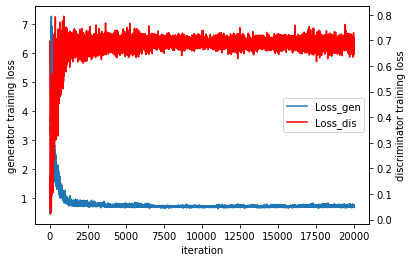

In [6]:
#将上面输出的loss绘制成曲线
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(np.arange(20000), fig_loss_gen, label="Loss_gen")
# 按一定间隔显示实现方法
# ax2.plot(200 * np.arange(len(fig_accuracy)), fig_accuracy, 'r')
lns2 = ax2.plot(np.arange(20000), fig_loss_dis, 'r', label="Loss_dis")
ax1.set_xlabel('iteration')
ax1.set_ylabel('generator training loss')
ax2.set_ylabel('discriminator training loss')
# 合并图例
lns = lns1 + lns2
labels = ["Loss_gen", "Loss_dis"]
# labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc=7)
plt.show()
fig.savefig("loss_cgan_fashion_mnist")

(1, 28, 28, 1)


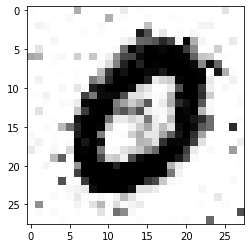

In [30]:
#测试根据输入条件（0—9的数字）生成数据的准确度
for i in range(10)
noise = np.random.normal(0, 1, (1, 100))
sampled_labels=np.array([[9]])  #数字标签
gen_imgs = cgan.generator.predict([noise, sampled_labels])
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[0,:,:,0], cmap="binary")
#fig.savefig("images/%d.png" % epoch)
# plt.close()
print(gen_imgs.shape)

In [1]:
#DCGAN和GAN的模型构建
import numpy as np
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

DC_codings_size = 100

DC_generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[DC_codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
    
])
DC_discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

codings_size = 30
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])  #GAN模型
#gan = keras.models.Sequential([DC_generator, DC_discriminator])  #DCGAN模型

In [2]:
##输出模型结果可视化结果
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

plot_model(gan,to_file='model1_DCGAN.png',show_shapes=True,show_layer_names=True,rankdir='TB')
plt.figure(figsize=(10,10))
img=plt.imread('model1_DCGAN.png')
plt.imshow(img)
plt.axis('off')
plt.show()

<Figure size 1000x1000 with 1 Axes>

In [3]:
#加载数据集
def load_data():
#         fashion_mnist = keras.datasets.fashion_mnist
#         (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        path='.//datasets//mnist.npz'
        f = np.load(path)
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        f.close()
        return (x_train, y_train), (x_test, y_test)

(X_train_full, y_train_full), (X_test, y_test) = load_data()
X_train_full = X_train_full[:1*len(X_train_full)]
y_train = y_train_full[:1*len(y_train_full)]
print(len(X_train_full))
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

60000


In [4]:
#compile模型
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [5]:
#X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale这句话只在DCGAN中使用

In [6]:
#定义Batch_size和切分数据集
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [7]:
#定义绘图函数
import matplotlib.pyplot as plt
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [8]:
#定义训练算法
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=100):
    generator, discriminator = gan.layers
    fig_loss_gen = np.zeros([n_epochs])
    fig_loss_dis = np.zeros([n_epochs])
    fig_accuracy = np.zeros([n_epochs])
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        loss_gen=0
        loss_dis=0
        i=0
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            loss_dis=loss_dis+discriminator.train_on_batch(X_fake_and_real, y1)
            
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            loss_gen=loss_gen+gan.train_on_batch(noise, y2)
            i=i+1
        fig_loss_gen[epoch]=loss_gen/i
        fig_loss_dis[epoch]=loss_dis/i
            
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown
    return fig_loss_gen,fig_loss_dis

Epoch 1/30


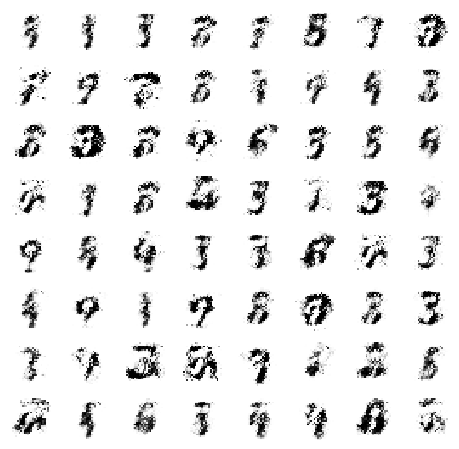

Epoch 2/30


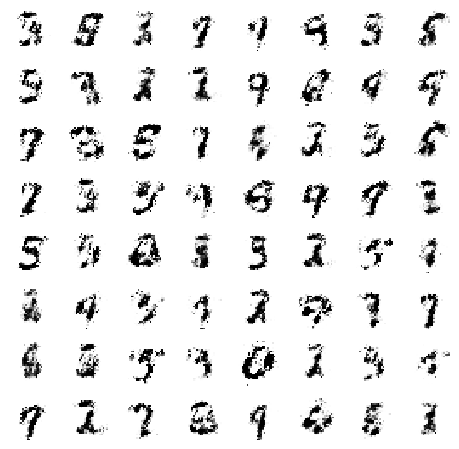

Epoch 3/30


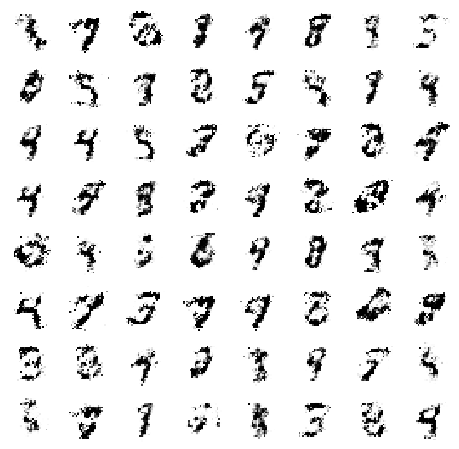

Epoch 4/30


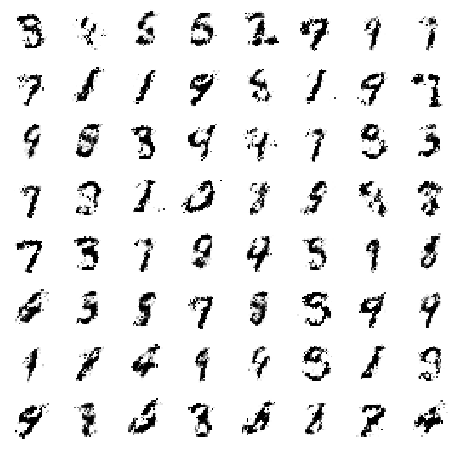

Epoch 5/30


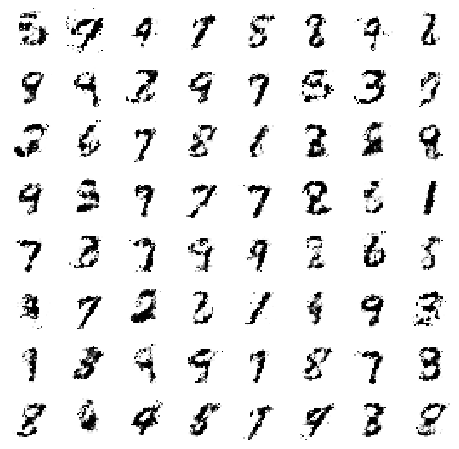

Epoch 6/30


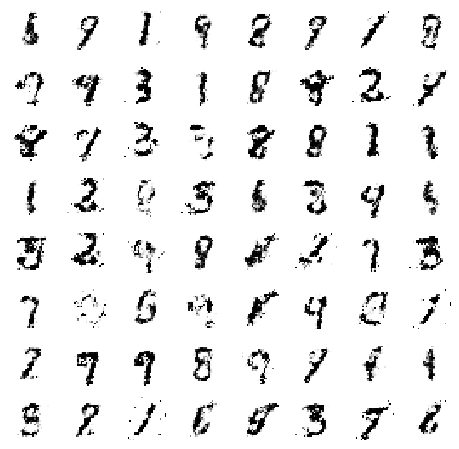

Epoch 7/30


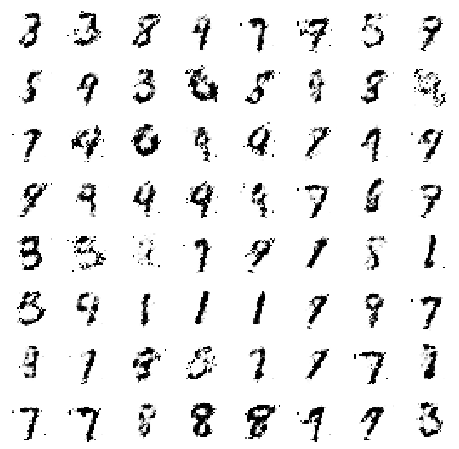

Epoch 8/30


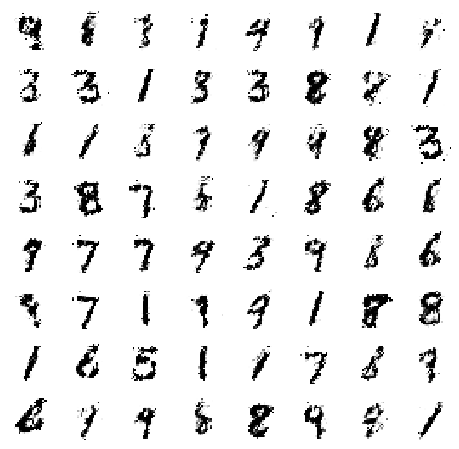

Epoch 9/30


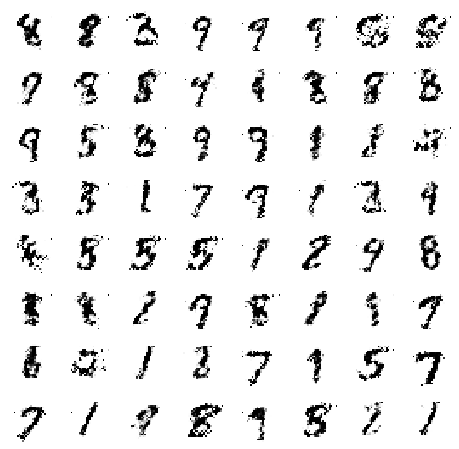

Epoch 10/30


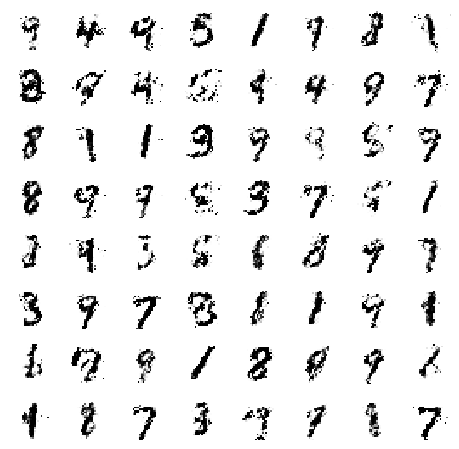

Epoch 11/30


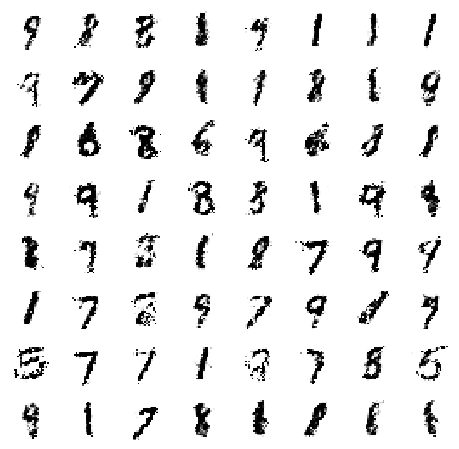

Epoch 12/30


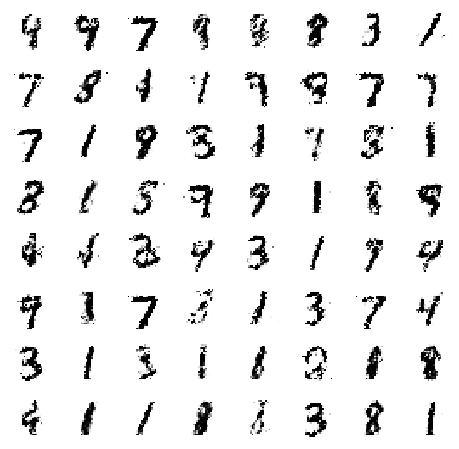

Epoch 13/30


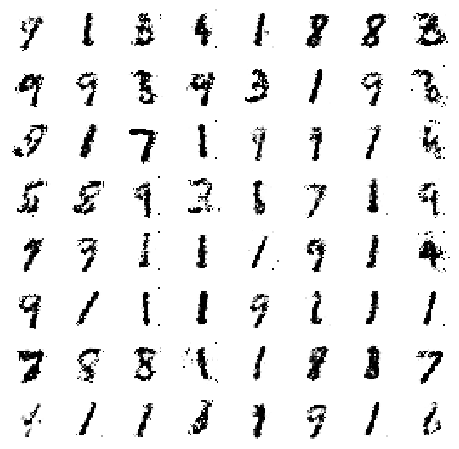

Epoch 14/30


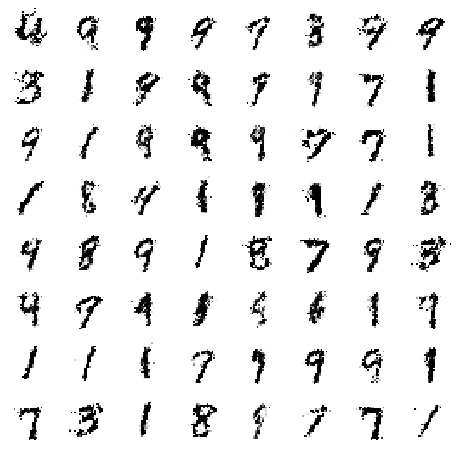

Epoch 15/30


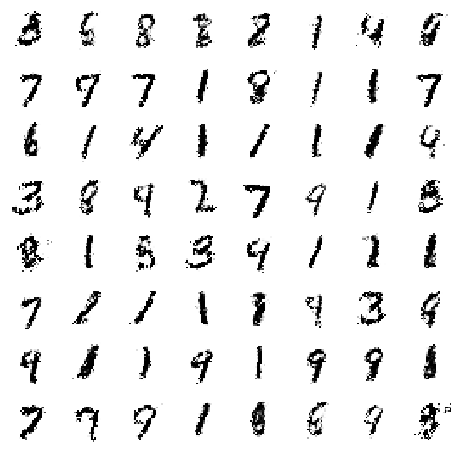

Epoch 16/30


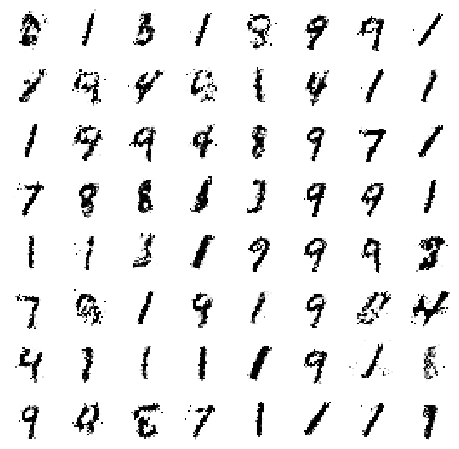

Epoch 17/30


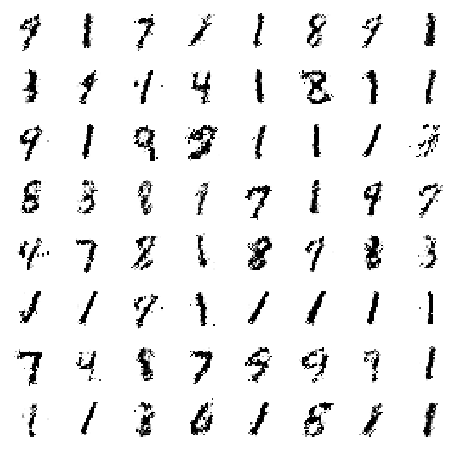

Epoch 18/30


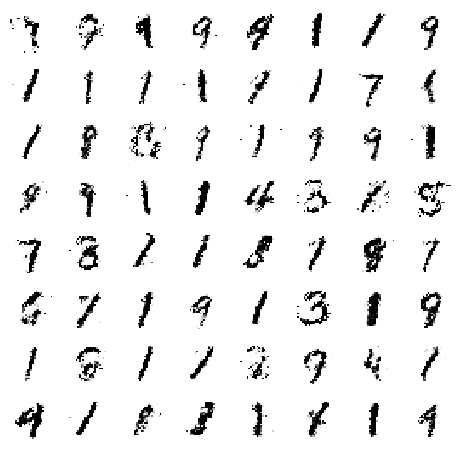

Epoch 19/30


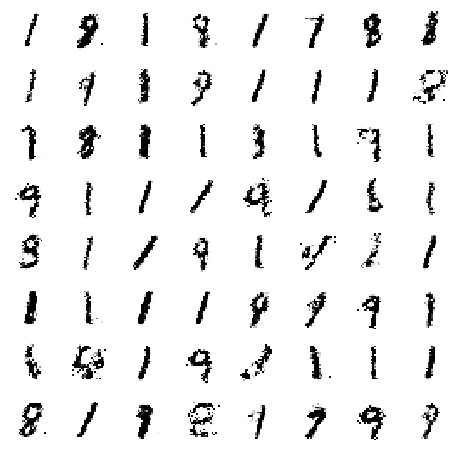

Epoch 20/30


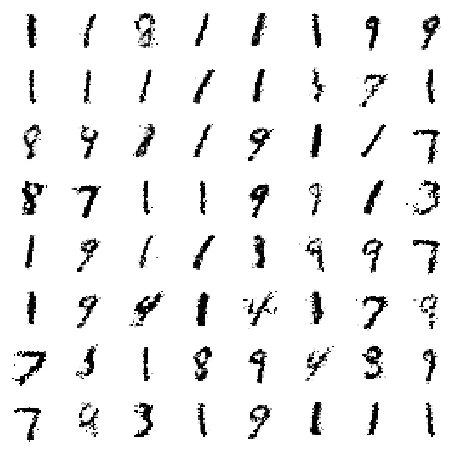

Epoch 21/30


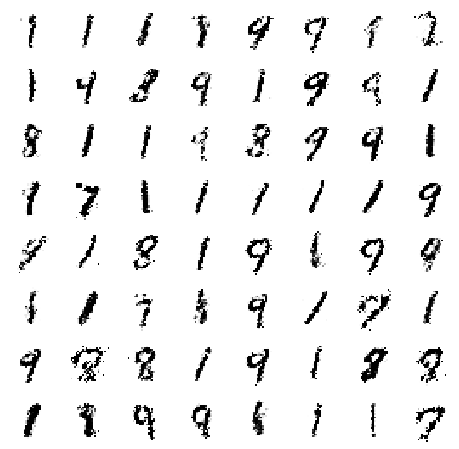

Epoch 22/30


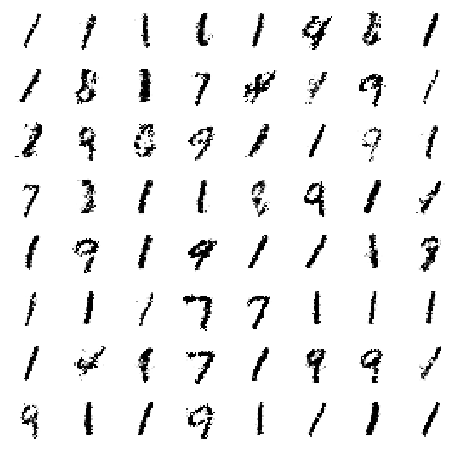

Epoch 23/30


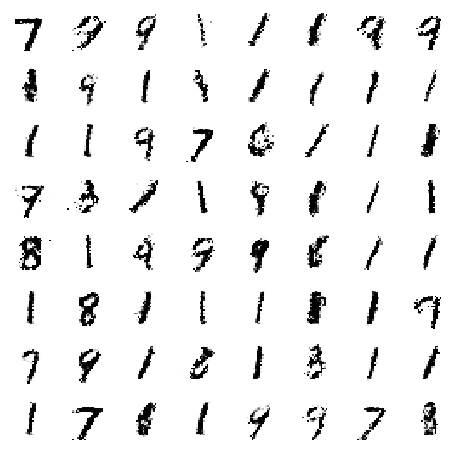

Epoch 24/30


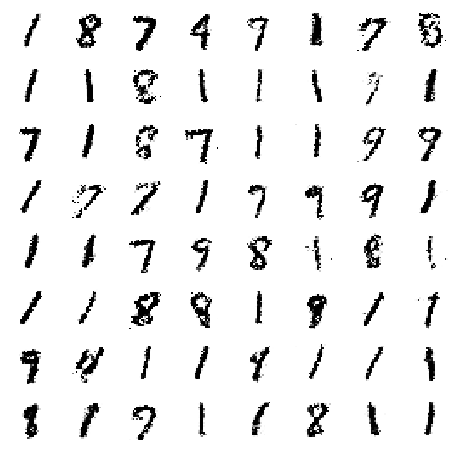

Epoch 25/30


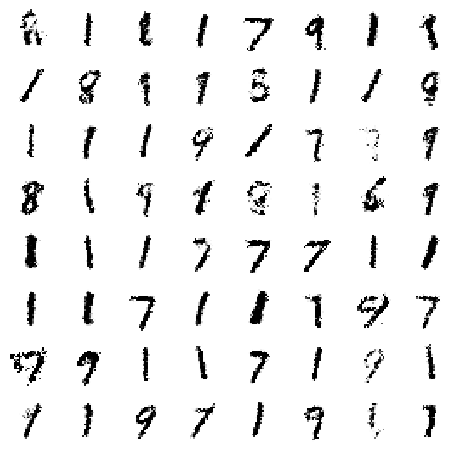

Epoch 26/30


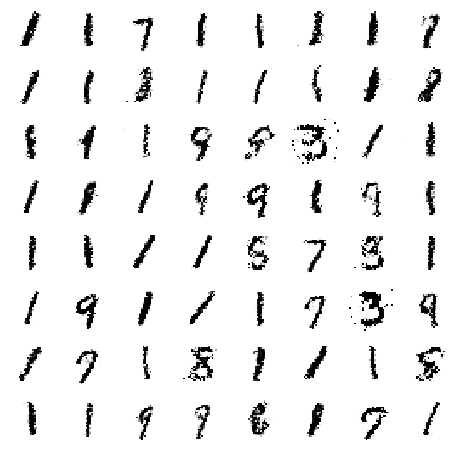

Epoch 27/30


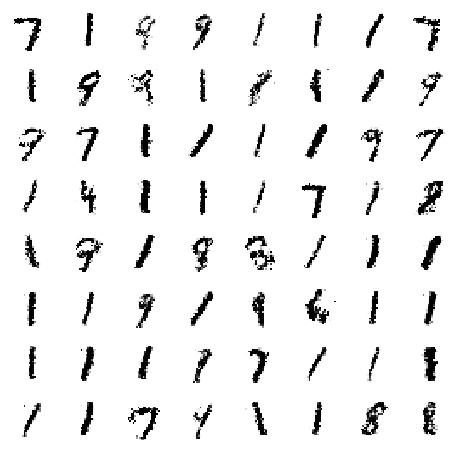

Epoch 28/30


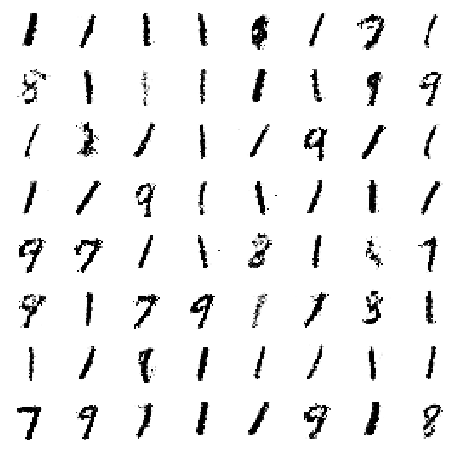

Epoch 29/30


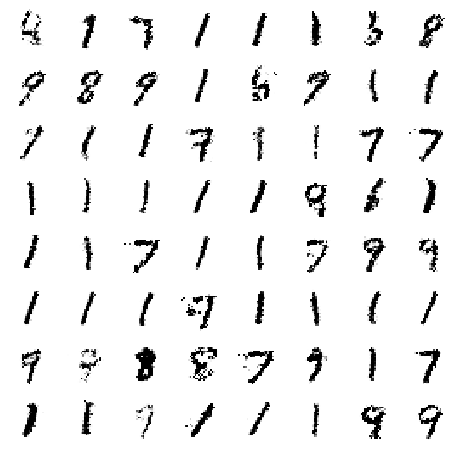

Epoch 30/30


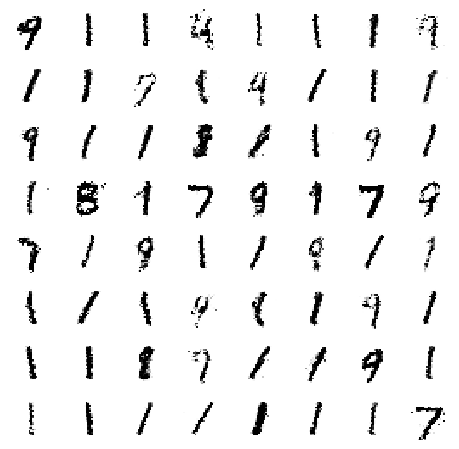

In [9]:
#训练模型
fig_loss_gen,fig_loss_dis=train_gan(gan, dataset, batch_size, codings_size, n_epochs=30)

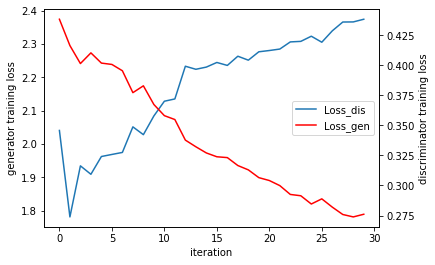

In [14]:
#绘制loss
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(np.arange(30), fig_loss_gen, label="Loss_gen")
# 按一定间隔显示实现方法
# ax2.plot(200 * np.arange(len(fig_accuracy)), fig_accuracy, 'r')
lns2 = ax2.plot(np.arange(30), fig_loss_dis, 'r', label="Loss_dis")
ax1.set_xlabel('iteration')
ax1.set_ylabel('generator training loss')
ax2.set_ylabel('discriminator training loss')
# 合并图例
lns = lns1 + lns2
labels = ["Loss_dis", "Loss_gen"]
# labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc=7)
plt.show()

In [15]:
#定义存图函数
import os.path
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure gan_generated_images_plot


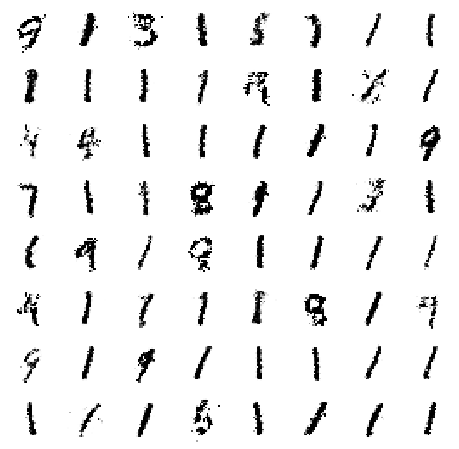

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)


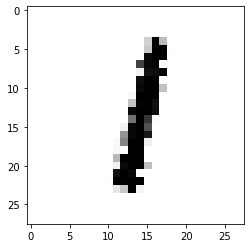

In [17]:
#将GAN或DCGAN生成的图片逐个保存下来
from PIL import Image
def savepic(images):
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    for index, image in enumerate(images):
        plt.imshow(image, cmap="binary")
        path=os.path.join('.','fakepics','GAN_fake_num_60000_batchsize_64',str(index)+'.jpg')
        plt.savefig(path)
        
savepic(generated_images)


In [17]:
import scipy.misc as misc
def get_images(filename):
    x = misc.imread(filename)
    x = misc.imresize(x, size=[299, 299])
    return x

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Epoch 1/300... Discriminator Loss: 0.0358(Real: 0.0092 + Fake: 0.0266)... Generator Loss: 3.5461
Epoch 2/300... Discriminator Loss: 0.2241(Real: 0.1365 + Fake: 0.0876)... Generator Loss: 3.8435
Epoch 3/300... Discriminator Loss: 0.7409(Real: 0.2345 + Fake: 0.5064)... Generator Loss: 3.5316
Epoch 4/300... Discriminator Loss: 0.4299(Real: 0.2026 + Fake: 0.2273)... Generator Loss: 4.7219
Epoch 5/300... Discriminator Loss: 0.3819(Real: 0.2097 + Fake: 0.1722)... Generator Loss: 2.5714
Epoch 6/300... Discriminator Loss: 0.4546(Real: 0.1557 + Fake: 0.2988)... Generator Loss: 3.3776
Epoch 7/300... Discriminator Loss: 1.1246(Real: 0.6490 + Fake: 0.4757)... Generator Loss: 2.3038
Epoch 8/300... Discriminator Loss: 0.6385(Real: 0.3355 + Fake: 0.3030)... Generator Loss: 2.3126
Epoch 9/300... Discriminator L

Epoch 83/300... Discriminator Loss: 1.0798(Real: 0.6855 + Fake: 0.3943)... Generator Loss: 1.6031
Epoch 84/300... Discriminator Loss: 0.9076(Real: 0.5131 + Fake: 0.3945)... Generator Loss: 1.6041
Epoch 85/300... Discriminator Loss: 1.1984(Real: 0.3705 + Fake: 0.8280)... Generator Loss: 0.8248
Epoch 86/300... Discriminator Loss: 0.8734(Real: 0.3647 + Fake: 0.5087)... Generator Loss: 1.1846
Epoch 87/300... Discriminator Loss: 0.8473(Real: 0.5496 + Fake: 0.2977)... Generator Loss: 1.7875
Epoch 88/300... Discriminator Loss: 0.7937(Real: 0.3462 + Fake: 0.4475)... Generator Loss: 1.4581
Epoch 89/300... Discriminator Loss: 0.8939(Real: 0.3901 + Fake: 0.5039)... Generator Loss: 1.2396
Epoch 90/300... Discriminator Loss: 0.9810(Real: 0.5028 + Fake: 0.4782)... Generator Loss: 1.3238
Epoch 91/300... Discriminator Loss: 1.0884(Real: 0.3644 + Fake: 0.7241)... Generator Loss: 0.9091
Epoch 92/300... Discriminator Loss: 0.8018(Real: 0.4419 + Fake: 0.3599)... Generator Loss: 1.3521
Epoch 93/300... Disc

Epoch 166/300... Discriminator Loss: 0.8922(Real: 0.3486 + Fake: 0.5436)... Generator Loss: 1.0590
Epoch 167/300... Discriminator Loss: 0.8392(Real: 0.3956 + Fake: 0.4436)... Generator Loss: 1.6527
Epoch 168/300... Discriminator Loss: 1.0642(Real: 0.5918 + Fake: 0.4723)... Generator Loss: 1.2541
Epoch 169/300... Discriminator Loss: 0.5622(Real: 0.1861 + Fake: 0.3761)... Generator Loss: 1.4704
Epoch 170/300... Discriminator Loss: 0.9124(Real: 0.4550 + Fake: 0.4574)... Generator Loss: 1.3047
Epoch 171/300... Discriminator Loss: 1.0075(Real: 0.6005 + Fake: 0.4069)... Generator Loss: 1.3397
Epoch 172/300... Discriminator Loss: 1.1291(Real: 0.5971 + Fake: 0.5320)... Generator Loss: 1.4683
Epoch 173/300... Discriminator Loss: 0.7543(Real: 0.4291 + Fake: 0.3252)... Generator Loss: 1.5822
Epoch 174/300... Discriminator Loss: 0.9122(Real: 0.4331 + Fake: 0.4791)... Generator Loss: 1.1851
Epoch 175/300... Discriminator Loss: 0.9195(Real: 0.4431 + Fake: 0.4763)... Generator Loss: 1.3756
Epoch 176/

Epoch 249/300... Discriminator Loss: 0.9526(Real: 0.4905 + Fake: 0.4621)... Generator Loss: 1.3535
Epoch 250/300... Discriminator Loss: 0.8698(Real: 0.4702 + Fake: 0.3996)... Generator Loss: 1.4957
Epoch 251/300... Discriminator Loss: 0.7624(Real: 0.2987 + Fake: 0.4637)... Generator Loss: 1.0751
Epoch 252/300... Discriminator Loss: 0.8548(Real: 0.6302 + Fake: 0.2246)... Generator Loss: 1.9387
Epoch 253/300... Discriminator Loss: 1.0193(Real: 0.4565 + Fake: 0.5628)... Generator Loss: 1.4945
Epoch 254/300... Discriminator Loss: 0.8580(Real: 0.5235 + Fake: 0.3345)... Generator Loss: 1.8430
Epoch 255/300... Discriminator Loss: 0.8175(Real: 0.3795 + Fake: 0.4381)... Generator Loss: 1.4395
Epoch 256/300... Discriminator Loss: 0.6948(Real: 0.3910 + Fake: 0.3038)... Generator Loss: 2.0904
Epoch 257/300... Discriminator Loss: 0.9604(Real: 0.3868 + Fake: 0.5736)... Generator Loss: 1.1752
Epoch 258/300... Discriminator Loss: 0.7643(Real: 0.3340 + Fake: 0.4303)... Generator Loss: 1.6269
Epoch 259/

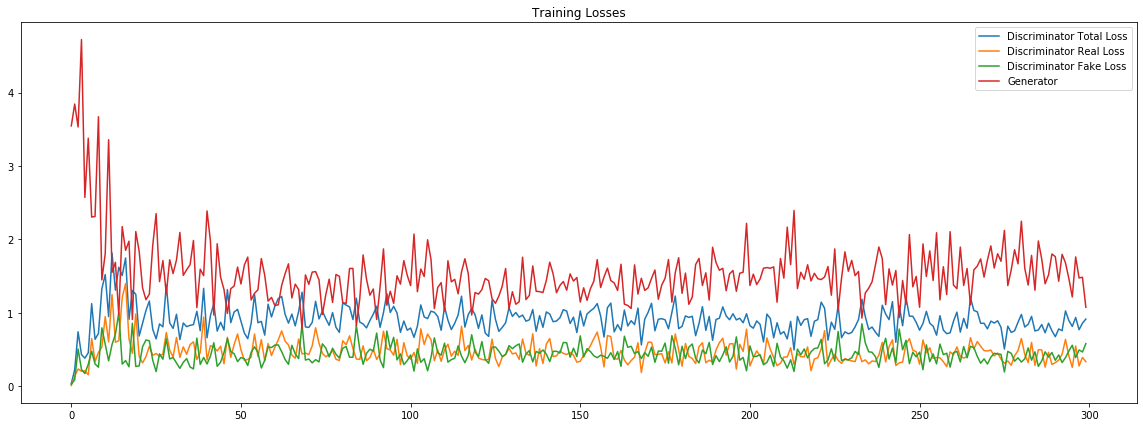

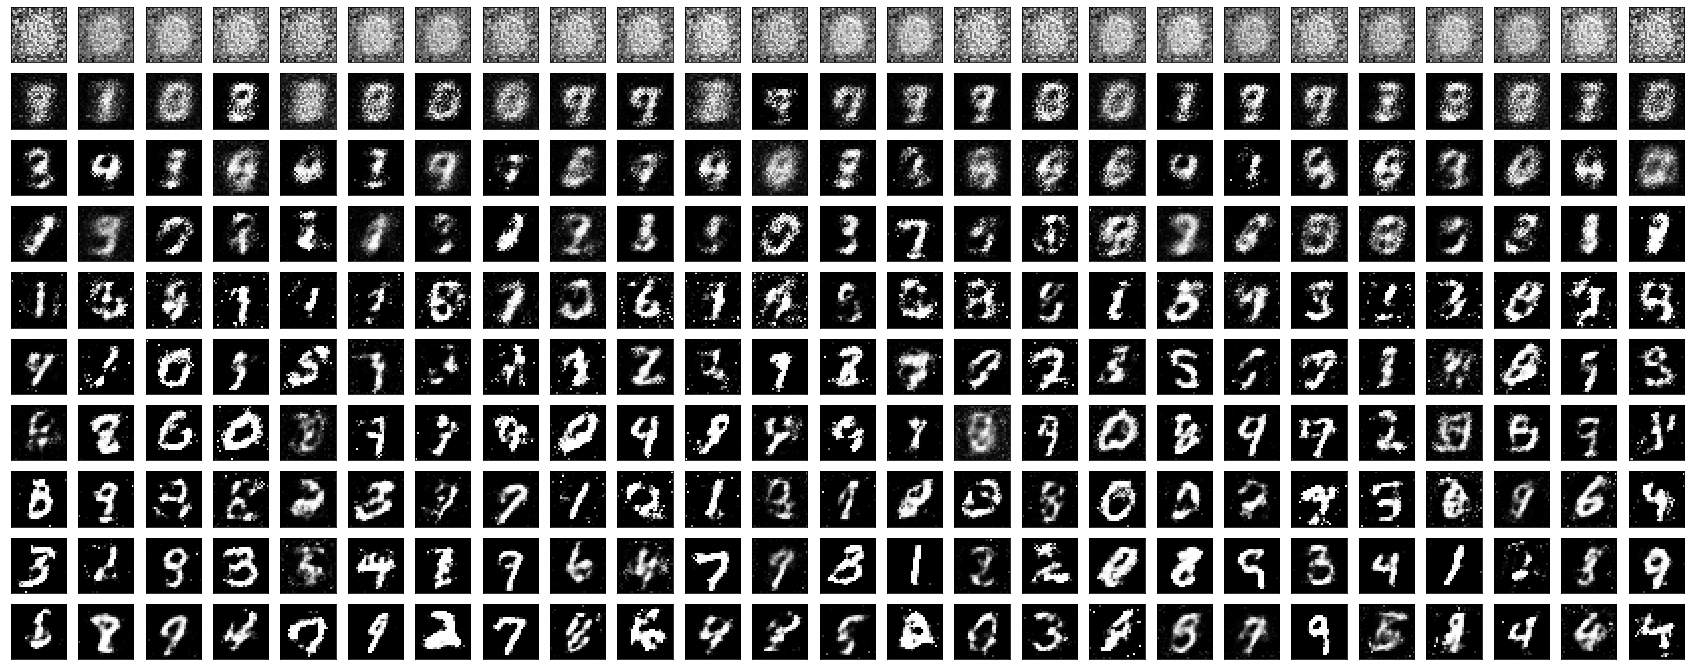

In [27]:
#绘制实验报告图3的模型
import numpy as np
import pickle
import matplotlib.pyplot as plt
 
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

 
def get_inputs(real_size, noise_size):
    #"""
    #真实图像tensor与噪声图像tensor
    #"""
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    #"""
    #生成器    
    #noise_img: 生成器的输入
    #n_units: 隐层单元个数
    #out_dim: 生成器输出tensor的size，这里应该为32*32=784
    #alpha: leaky ReLU系数
    #"""
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)
        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)     
        return logits, outputs
 

def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    #"""
    #判别器
    #
    #n_units: 隐层结点数量
    #alpha: Leaky ReLU系数
    #"""
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs
    
# 定义参数
# 真实图像的size
img_size = mnist.train.images[0].shape[0]
# 传入给generator的噪声size
noise_size = 100
# 生成器隐层参数
g_units = 128
# 判别器隐层参数
d_units = 128
# leaky ReLU的参数
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1
 
tf.reset_default_graph()
 
real_img, noise_img = get_inputs(img_size, noise_size)
 
# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)
 
# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)
 
# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                    labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

train_vars = tf.trainable_variables()
# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]
 
# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
 

#训练
# batch_size
batch_size = 32
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25
 
# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//(batch_size)):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')
 
# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)
    
    
    
    
#    绘制loss曲线   
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)
 
# 指定要查看的轮次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250] # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])
 
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)
 
idx = range(0, epochs, int(epochs/rows))
 
for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

===============判别器第1轮训练================
Train for 15 steps
Epoch 1/2
15/15 [==============================] - 1s 40ms/step - loss: 0.5987 - accuracy: 0.4200
Epoch 2/2
15/15 [==============================] - 0s 6ms/step - loss: 0.3628 - accuracy: 0.9600
===============生成器第1轮训练================
Train on 100 samples
Epoch 1/50
100/100 [==============================] - 1s 10ms/sample - loss: 5.0265
Epoch 2/50
100/100 [==============================] - 0s 280us/sample - loss: 2.9482
Epoch 3/50
100/100 [==============================] - 0s 319us/sample - loss: 1.9528
Epoch 4/50
100/100 [==============================] - 0s 289us/sample - loss: 1.4077
Epoch 5/50
100/100 [==============================] - 0s 289us/sample - loss: 1.1456
Epoch 6/50
100/100 [==============================] - 0s 289us/sample - loss: 0.9993
Epoch 7/50
100/100 [==============================] - 0s 259us/sample - loss: 0.9116
Epoch 8/50
100/100 [==============================] - 0s 269us/sample - loss: 0.8589
Epoch 

100/100 [==============================] - 0s 289us/sample - loss: 0.0681
Epoch 28/50
100/100 [==============================] - 0s 279us/sample - loss: 0.0681
Epoch 29/50
100/100 [==============================] - 0s 289us/sample - loss: 0.0683
Epoch 30/50
100/100 [==============================] - 0s 269us/sample - loss: 0.0680
Epoch 31/50
100/100 [==============================] - 0s 269us/sample - loss: 0.0681
Epoch 32/50
100/100 [==============================] - 0s 269us/sample - loss: 0.0680
Epoch 33/50
100/100 [==============================] - 0s 259us/sample - loss: 0.0680
Epoch 34/50
100/100 [==============================] - 0s 259us/sample - loss: 0.0680
Epoch 35/50
100/100 [==============================] - 0s 249us/sample - loss: 0.0679
Epoch 36/50
100/100 [==============================] - 0s 259us/sample - loss: 0.0680
Epoch 37/50
100/100 [==============================] - 0s 269us/sample - loss: 0.0679
Epoch 38/50
100/100 [==============================] - 0s 259us/sa

100/100 [==============================] - 0s 259us/sample - loss: 0.7418
Epoch 4/50
100/100 [==============================] - 0s 290us/sample - loss: 0.7341
Epoch 5/50
100/100 [==============================] - 0s 269us/sample - loss: 0.7281
Epoch 6/50
100/100 [==============================] - 0s 289us/sample - loss: 0.7231
Epoch 7/50
100/100 [==============================] - 0s 269us/sample - loss: 0.7191
Epoch 8/50
100/100 [==============================] - 0s 269us/sample - loss: 0.7160
Epoch 9/50
100/100 [==============================] - 0s 279us/sample - loss: 0.7134
Epoch 10/50
100/100 [==============================] - 0s 279us/sample - loss: 0.7113
Epoch 11/50
100/100 [==============================] - 0s 279us/sample - loss: 0.7094
Epoch 12/50
100/100 [==============================] - 0s 269us/sample - loss: 0.7078
Epoch 13/50
100/100 [==============================] - 0s 279us/sample - loss: 0.7067
Epoch 14/50
100/100 [==============================] - 0s 279us/sample -

Epoch 45/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6853
Epoch 46/50
100/100 [==============================] - 0s 259us/sample - loss: 0.6853
Epoch 47/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6853
Epoch 48/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6853
Epoch 49/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6853
Epoch 50/50
100/100 [==============================] - 0s 269us/sample - loss: 0.6853
===============判别器第10轮训练================
Train for 15 steps
Epoch 1/2
15/15 [==============================] - 0s 5ms/step - loss: 0.7491 - accuracy: 0.1867
Epoch 2/2
15/15 [==============================] - 0s 5ms/step - loss: 0.6548 - accuracy: 0.5967
===============生成器第10轮训练================
Train on 100 samples
Epoch 1/50
100/100 [==============================] - 1s 6ms/sample - loss: 0.7823
Epoch 2/50
100/100 [==============================] - 0s 250us/sample - loss: 0.7441


100/100 [==============================] - 0s 289us/sample - loss: 0.6930
Epoch 22/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6930
Epoch 23/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6930
Epoch 24/50
100/100 [==============================] - 0s 269us/sample - loss: 0.6930
Epoch 25/50
100/100 [==============================] - 0s 249us/sample - loss: 0.6930
Epoch 26/50
100/100 [==============================] - 0s 269us/sample - loss: 0.6930
Epoch 27/50
100/100 [==============================] - 0s 259us/sample - loss: 0.6930
Epoch 28/50
100/100 [==============================] - 0s 259us/sample - loss: 0.6930
Epoch 29/50
100/100 [==============================] - 0s 269us/sample - loss: 0.6930
Epoch 30/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6930
Epoch 31/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6930
Epoch 32/50
100/100 [==============================] - 0s 269us/sa

100/100 [==============================] - 0s 279us/sample - loss: 0.6485
===============判别器第17轮训练================
Train for 15 steps
Epoch 1/2
15/15 [==============================] - 0s 5ms/step - loss: 0.8098 - accuracy: 0.3900
Epoch 2/2
15/15 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5433
===============生成器第17轮训练================
Train on 100 samples
Epoch 1/50
100/100 [==============================] - 1s 6ms/sample - loss: 0.6951
Epoch 2/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6936
Epoch 3/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6929
Epoch 4/50
100/100 [==============================] - 0s 269us/sample - loss: 0.6926
Epoch 5/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6924
Epoch 6/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6924
Epoch 7/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6923
Epoch 8/50
100/10

100/100 [==============================] - 0s 309us/sample - loss: 0.5541
Epoch 27/50
100/100 [==============================] - 0s 329us/sample - loss: 0.5518
Epoch 28/50
100/100 [==============================] - 0s 309us/sample - loss: 0.5496
Epoch 29/50
100/100 [==============================] - 0s 299us/sample - loss: 0.5472
Epoch 30/50
100/100 [==============================] - 0s 319us/sample - loss: 0.5446
Epoch 31/50
100/100 [==============================] - 0s 309us/sample - loss: 0.5417
Epoch 32/50
100/100 [==============================] - 0s 309us/sample - loss: 0.5385
Epoch 33/50
100/100 [==============================] - 0s 299us/sample - loss: 0.5346
Epoch 34/50
100/100 [==============================] - 0s 339us/sample - loss: 0.5305
Epoch 35/50
100/100 [==============================] - 0s 319us/sample - loss: 0.5259
Epoch 36/50
100/100 [==============================] - 0s 329us/sample - loss: 0.5220
Epoch 37/50
100/100 [==============================] - 0s 319us/sa

100/100 [==============================] - 0s 279us/sample - loss: 0.3986
Epoch 3/50
100/100 [==============================] - 0s 289us/sample - loss: 0.3968
Epoch 4/50
100/100 [==============================] - 0s 279us/sample - loss: 0.3978
Epoch 5/50
100/100 [==============================] - 0s 289us/sample - loss: 0.3974
Epoch 6/50
100/100 [==============================] - 0s 279us/sample - loss: 0.3961
Epoch 7/50
100/100 [==============================] - 0s 289us/sample - loss: 0.3941
Epoch 8/50
100/100 [==============================] - 0s 309us/sample - loss: 0.3918
Epoch 9/50
100/100 [==============================] - 0s 289us/sample - loss: 0.3896
Epoch 10/50
100/100 [==============================] - 0s 279us/sample - loss: 0.3873
Epoch 11/50
100/100 [==============================] - 0s 269us/sample - loss: 0.3848
Epoch 12/50
100/100 [==============================] - 0s 289us/sample - loss: 0.3820
Epoch 13/50
100/100 [==============================] - 0s 289us/sample - 

Epoch 44/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6773
Epoch 45/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6771
Epoch 46/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6769
Epoch 47/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6767
Epoch 48/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6766
Epoch 49/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6765
Epoch 50/50
100/100 [==============================] - 0s 269us/sample - loss: 0.6764
===============判别器第26轮训练================
Train for 15 steps
Epoch 1/2
15/15 [==============================] - 0s 5ms/step - loss: 0.7223 - accuracy: 0.4567
Epoch 2/2
15/15 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.6167
===============生成器第26轮训练================
Train on 100 samples
Epoch 1/50
100/100 [==============================] - 1s 6ms/sample - loss: 0.8147

100/100 [==============================] - 0s 309us/sample - loss: 0.6688
Epoch 20/50
100/100 [==============================] - 0s 319us/sample - loss: 0.6691
Epoch 21/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6685
Epoch 22/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6674
Epoch 23/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6669
Epoch 24/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6666
Epoch 25/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6669
Epoch 26/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6665
Epoch 27/50
100/100 [==============================] - 0s 269us/sample - loss: 0.6657
Epoch 28/50
100/100 [==============================] - 0s 279us/sample - loss: 0.6649
Epoch 29/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6644
Epoch 30/50
100/100 [==============================] - 0s 299us/sa

100/100 [==============================] - 0s 309us/sample - loss: 0.6793
Epoch 49/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6793
Epoch 50/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6793
===============判别器第33轮训练================
Train for 15 steps
Epoch 1/2
15/15 [==============================] - 0s 6ms/step - loss: 0.7495 - accuracy: 0.2600
Epoch 2/2
15/15 [==============================] - 0s 5ms/step - loss: 0.5705 - accuracy: 0.6833
===============生成器第33轮训练================
Train on 100 samples
Epoch 1/50
100/100 [==============================] - 1s 6ms/sample - loss: 1.3536
Epoch 2/50
100/100 [==============================] - 0s 279us/sample - loss: 0.9568
Epoch 3/50
100/100 [==============================] - 0s 269us/sample - loss: 0.8558
Epoch 4/50
100/100 [==============================] - 0s 279us/sample - loss: 0.8053
Epoch 5/50
100/100 [==============================] - 0s 289us/sample - loss: 0.7738
Epoch 6/50
100/

100/100 [==============================] - 0s 249us/sample - loss: 0.6750
Epoch 25/50
100/100 [==============================] - 0s 259us/sample - loss: 0.6740
Epoch 26/50
100/100 [==============================] - 0s 319us/sample - loss: 0.6737
Epoch 27/50
100/100 [==============================] - 0s 339us/sample - loss: 0.6736
Epoch 28/50
100/100 [==============================] - 0s 339us/sample - loss: 0.6733
Epoch 29/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6730
Epoch 30/50
100/100 [==============================] - 0s 389us/sample - loss: 0.6729
Epoch 31/50
100/100 [==============================] - 0s 349us/sample - loss: 0.6727
Epoch 32/50
100/100 [==============================] - 0s 339us/sample - loss: 0.6724
Epoch 33/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6723
Epoch 34/50
100/100 [==============================] - 0s 319us/sample - loss: 0.6722
Epoch 35/50
100/100 [==============================] - 0s 329us/sa

15/15 [==============================] - 0s 5ms/step - loss: 0.6326 - accuracy: 0.7633
===============生成器第40轮训练================
Train on 100 samples
Epoch 1/50
100/100 [==============================] - 1s 6ms/sample - loss: 0.8546
Epoch 2/50
100/100 [==============================] - 0s 289us/sample - loss: 0.7973
Epoch 3/50
100/100 [==============================] - 0s 279us/sample - loss: 0.7922
Epoch 4/50
100/100 [==============================] - 0s 329us/sample - loss: 0.7790
Epoch 5/50
100/100 [==============================] - 0s 359us/sample - loss: 0.7666
Epoch 6/50
100/100 [==============================] - 0s 359us/sample - loss: 0.7554
Epoch 7/50
100/100 [==============================] - 0s 319us/sample - loss: 0.7442
Epoch 8/50
100/100 [==============================] - 0s 544us/sample - loss: 0.7331
Epoch 9/50
100/100 [==============================] - 0s 354us/sample - loss: 0.7208
Epoch 10/50
100/100 [==============================] - 0s 295us/sample - loss: 0.7106
Ep

100/100 [==============================] - 0s 309us/sample - loss: 0.5717
Epoch 42/50
100/100 [==============================] - 0s 339us/sample - loss: 0.5717
Epoch 43/50
100/100 [==============================] - 0s 299us/sample - loss: 0.5717
Epoch 44/50
100/100 [==============================] - 0s 309us/sample - loss: 0.5717
Epoch 45/50
100/100 [==============================] - 0s 339us/sample - loss: 0.5717
Epoch 46/50
100/100 [==============================] - 0s 319us/sample - loss: 0.5717
Epoch 47/50
100/100 [==============================] - 0s 299us/sample - loss: 0.5717
Epoch 48/50
100/100 [==============================] - 0s 299us/sample - loss: 0.5717
Epoch 49/50
100/100 [==============================] - 0s 319us/sample - loss: 0.5716
Epoch 50/50
100/100 [==============================] - 0s 299us/sample - loss: 0.5716
===============判别器第42轮训练================
Train for 15 steps
Epoch 1/2
15/15 [==============================] - 0s 6ms/step - loss: 0.7424 - accuracy: 0.

100/100 [==============================] - 0s 289us/sample - loss: 0.6496
Epoch 18/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6486
Epoch 19/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6478
Epoch 20/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6473
Epoch 21/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6470
Epoch 22/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6468
Epoch 23/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6467
Epoch 24/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6467
Epoch 25/50
100/100 [==============================] - 0s 299us/sample - loss: 0.6466
Epoch 26/50
100/100 [==============================] - 0s 309us/sample - loss: 0.6466
Epoch 27/50
100/100 [==============================] - 0s 289us/sample - loss: 0.6466
Epoch 28/50
100/100 [==============================] - 0s 309us/sa

Epoch 47/50
100/100 [==============================] - 0s 319us/sample - loss: 0.3825
Epoch 48/50
100/100 [==============================] - 0s 319us/sample - loss: 0.3825
Epoch 49/50
100/100 [==============================] - 0s 319us/sample - loss: 0.3825
Epoch 50/50
100/100 [==============================] - 0s 309us/sample - loss: 0.3825
===============判别器第49轮训练================
Train for 15 steps
Epoch 1/2
15/15 [==============================] - 0s 6ms/step - loss: 0.5359 - accuracy: 0.7267
Epoch 2/2
15/15 [==============================] - 0s 5ms/step - loss: 0.4059 - accuracy: 0.9133
===============生成器第49轮训练================
Train on 100 samples
Epoch 1/50
100/100 [==============================] - 1s 6ms/sample - loss: 1.6277
Epoch 2/50
100/100 [==============================] - 0s 259us/sample - loss: 1.3100
Epoch 3/50
100/100 [==============================] - 0s 279us/sample - loss: 1.0447
Epoch 4/50
100/100 [==============================] - 0s 269us/sample - loss: 0.8273
Ep

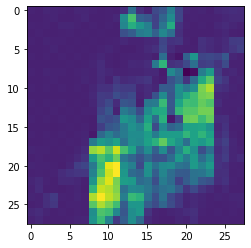

In [7]:
#生成彩色Fashion Mnist数据的模型，实验报告中未提及
import tensorflow as tf
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape,Conv2DTranspose,Conv2D,MaxPool2D,Flatten,BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

(train_x,train_y),(test_x,test_y) = load_data()
train_x = train_x[:150]/255
x_real,y_real = zip(*zip(train_x,np.ones(train_x.shape[0])))

g = Sequential([Dense(4*4*128,input_shape=(10,)),
                Reshape((4,4,128)),
                Conv2DTranspose(64,(4,4),padding="valid",activation="relu"),
                BatchNormalization(),
                Conv2DTranspose(32,(2,2),strides=(2, 2),padding="same",activation="relu"),
                BatchNormalization(),
                Conv2DTranspose(1, (2,2),strides=(2, 2),padding="same",activation="tanh"),
                Reshape((28,28))])

d = Sequential([Reshape((28,28,1),input_shape=(28,28)),
                Conv2D(32,(2,2),padding="same",activation="relu"),
                MaxPool2D((2,2)),
                Conv2D(64,(2,2),padding="same",activation="relu"),
                MaxPool2D((2,2)),
                Conv2D(64,(2,2),padding="valid",activation="relu"),
                MaxPool2D((2,2)),
                Flatten(),
                Dense(1,activation="sigmoid")])
gan = Sequential([g,d])
d.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

for i in range(50):
    print(f"===============判别器第{i+1}轮训练================")
    d.trainable = True
    x_fake,y_fake = zip(*zip(g(tf.random.uniform((train_x.shape[0],10),1,0)),np.zeros(train_x.shape[0])))
    x = x_real + x_fake
    y = y_real + y_fake
    dataset = tf.data.Dataset.from_tensor_slices((np.array(x),np.array(y))).shuffle(150).batch(20)
    d.fit(dataset,epochs=2)
    
    print(f"===============生成器第{i+1}轮训练================")
    d.trainable = False
    gan.compile(optimizer="adam",loss="binary_crossentropy")
    x = tf.random.uniform((100,10),1,0)
    y = 1-d(g(x))
    gan.fit(x,y,epochs=50)

img = g(tf.random.uniform((1,10),1,0))[0]
plt.imshow(img)
plt.show()

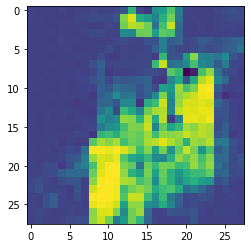

In [10]:
img = g(tf.random.uniform((1,10),1,1))[0]
plt.imshow(img)
plt.show()

In [ ]:
#为了使用FID，将Mnist图片存到本地，FID算法需用cmd，输入指令：python fid.py cd1 cd2   cd1和cd2分别存放生成图像和原始图像.
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from matplotlib.image import imsave
import itertools

def load_data():
        path='D://机器学习//dataset//mnist.npz'
        f = np.load(path)
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        f.close()
        return (x_train, y_train), (x_test, y_test)
# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)
 
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
 
train_path = '.\\MNIST_data\\train'
test_path = '.\\MNIST_data\\test'
 
image_counter = itertools.count(0)
for image, label in zip(X_train, y_train):
    dest_folder = os.path.join(train_path, str(label))
    image_name = next(image_counter)
    image_path = os.path.join(dest_folder, str(image_name) + '.png')
 
    if not os.path.exists(dest_folder):
        os.mkdir(dest_folder)
 
    imsave(image_path, image, cmap='gray')
 
for image, label in zip(X_test, y_test):
    dest_folder = os.path.join(test_path, str(label))
    image_name = next(image_counter)
    image_path = os.path.join(dest_folder, str(image_name) + '.png')
 
    if not os.path.exists(dest_folder):
        os.mkdir(dest_folder)
 
    imsave(image_path, image, cmap='gray')